# Άσκηση 3: Βελτιστοποίηση συναρτήσεων με Γενετικούς Αλγόριθμους

<img src="http://infinity77.net/global_optimization/_images/Alpine01.png" alt="Alpine01" style="width: 500px;"/>

Στόχος της άσκησης είναι η βελτιστοποίηση συναρτήσεων χωρίς παραγώγους (derivative free optimization) με χρήση Γενετικών Αλγόριθμων μέσω της βιβλιοθήκης DEAP. Η βελτιστοποίηση χωρίς παραγώγους είναι ιδιαίτερα χρήσιμη σε περιπτώσεις όπου η αντικειμενική συνάρτηση $f$ δεν είναι διαθέσιμη (black-box optimization) ή σε περίπτωσεις που είναι, είναι δύσκολο ή μη πρακτικό να υπολογιστούν οι παράγωγοί της. Για παράδειγμα η  $f$ μπορεί να μην είναι διαφορίσιμη, η παραγώγιση της μπορεί να είναι δύσκολη ή να απαιτεί πολύ χρόνο,  η $f$ να περιέχει θόρυβο έτσι ώστε οι μέθοδοι που βασίζονται σε απειροστικές διαφορές να μην είναι αποτελεσματικές ή να υπάρχουν πολλά τοπικά ελάχιστα μεταξύ άλλων. 

## 1. Βελτιστοποίηση μη κλιμακούμενης συνάρτησης


Εισάγουμε την βιβλιοθήκη DEAP

In [1]:
!pip install deap
from deap import base, creator, tools
import numpy as np
from math import sqrt
from deap import algorithms

Η μη-κλιμακούμενη (non-scalable) συνάρτηση της ομάδας μας είναι η 107 (Rotated Ellipse Function), όπως φαίνεται παρακάτω.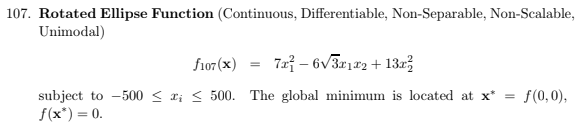

In [2]:
numVariables = 2 

creator.create( "FitnessMin", base.Fitness , weights=(-1.0,))
creator.create( "IndividualContainer", list , fitness= creator.FitnessMin)
toolbox2 = base.Toolbox()
toolbox2.register( "InitialValue", np.random.uniform, -500, 500)
toolbox2.register( "indiv", tools.initRepeat, creator.IndividualContainer, toolbox2.InitialValue, numVariables)
toolbox2.register( "population", tools.initRepeat, list , toolbox2.indiv)

def evalSinFunc( indiv ):
    sum= 7*(( indiv [0])**2) - 6*sqrt(3)*( indiv [0])*( indiv [1]) + 13*(( indiv [1])**2)
    return (sum,)

Ορίζουμε τις συναρτήσεις `feasible` και `distance` με τα κατάλληλα όρια της συνάρτησης.

In [4]:
MIN_BOUND = np.array([-500]*numVariables)
MAX_BOUND = np.array([500]*numVariables)

def feasible( indiv ):
    if any( indiv < MIN_BOUND) or any( indiv > MAX_BOUND):
        return False
    return True

def distance( indiv ) :
    dist = 0.0
    for i in range (len( indiv )) :
        penalty = 0
        if ( indiv [i] < MIN_BOUND[i]) : penalty = 500 - indiv [i]
        if ( indiv [i] > MAX_BOUND[i]) : penalty = indiv [i] - 500
        dist = dist + penalty
    return dist

In [5]:
toolbox2.register( "evaluate", evalSinFunc)
toolbox2.decorate( "evaluate", tools.DeltaPenality (feasible, 1.0, distance))

Χρησιμοποιούμε την συνάρτηση `ea2_with_stats` για την απεικόνιση των στατιστικών των αλγορίθμων.

In [6]:
from deap import algorithms
def ea2_with_stats(algorithm_value):
    import numpy
    
    pop = toolbox2.population(n=200)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    if (algorithm_value==0):
        pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)
    elif (algorithm_value==1):
        pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox2, mu = 200, lambda_ = 200 ,cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)
    elif (algorithm_value==2):
        pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox2, mu = 200, lambda_ = 200 ,cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)
    return pop, logbook, hof

Εκτελούμε όλους τους δυνατούς συνδυασμούς παραμέτρων και γενετικών αλγορίθμων. Οι στρατηγικές που επιλέχθηκαν για `mate` είναι οι `cxBlend` και `cxUniform`, και για `mutate` οι `mutGaussian` και `mutShuffleIndexes`.

In [7]:
import time
mate_values = [tools.cxBlend,tools.cxUniform]
alpha_values = [0.2,0.8]
mutate_values = [tools.mutGaussian,tools.mutShuffleIndexes]
indpb_values = [0.05,0.2]
tournsize_values = [3,10]
algorithm_values = [0,1,2]
averages=[]

for a in algorithm_values:
    for i in mate_values:
        for j in alpha_values:
            for k in mutate_values:
                for l in indpb_values:
                    for m in tournsize_values:
                        if (i==tools.cxBlend):
                            toolbox2.register( "mate", i, alpha = j)
                        else:
                            toolbox2.register( "mate", i, indpb = j)

                        if (k==tools.mutGaussian):
                            toolbox2.register( "mutate", k, mu = 0, sigma=1.0, indpb=l)
                        else:
                            toolbox2.register( "mutate", k, indpb=l)

                        toolbox2.register( "select", tools.selTournament, tournsize=m)
                        start_time = time.time()
                        min_sum=0
                        evals_sum=0
                        success_gen=0
                        success_gen_min=0                        
                        success_counter=0
                        success_evals_total_sum=0
                        for rounds in range(5):
                            success_evals_sum=0
                            pop, log, hof = ea2_with_stats(a)
                            min_sum = min_sum + log[50]['min']
                            if (log[50]['min']< 0.5): #goal+delta
                                success_counter = success_counter + 1
                            flag_gen = False
                            for gen in log:
                                success_evals_sum = success_evals_sum + gen['nevals']
                                evals_sum = evals_sum + gen['nevals']
                                if (flag_gen==False and gen['min']< 0.5):
                                    flag_gen=True
                                    success_gen= success_gen + gen['gen']
                                    success_gen_min = success_gen_min + gen['min']
                                    success_evals_total_sum = success_evals_total_sum + success_evals_sum
                                    
                            print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
                        avg_min = min_sum/5
                        avg_evals = evals_sum/5
                        avg_time = (time.time() - start_time)/5
                        if (success_counter == 0):
                            avg_success_gen = 'None'
                            avg_success_gen_min = 'None'
                            avg_success_evals = 'None'
                        else:
                            avg_success_gen = success_gen/success_counter
                            avg_success_gen_min = success_gen_min/success_counter
                            avg_success_evals = success_evals_total_sum/success_counter
                        operators = [i,j,k,l,'selTournament',m]
                        if (i==tools.cxBlend):
                            operators[0]='cxBlend'
                        else:
                            operators[0]='cxUniform'
                        if (k==tools.mutGaussian):
                            operators[2]='mutGaussian'
                        else:
                            operators[2]='mutShuffleIndexes'
                        algos = ['eaSimple','eaMuPlusLambda','eaMuCommaLambda']
                        if (algos[a]=='eaSimple'):
                            strategy = [algos[a],200,0.5,0.2]
                        else:
                            strategy = [algos[a],200,200,0.5,0.2]
                        info = {
                        "strategy": strategy,
                        "operators": operators,
                        "avg.min":    avg_min,
                        "avg.evals": avg_evals,
                        "avg.time":  avg_time,
                        "successes": success_counter,
                        "s.avg.gens": avg_success_gen,
                        "s.avg.min": avg_success_gen_min,
                        "s.avg.evals": avg_success_evals
                        }
                        averages.append(info)


gen	nevals	min  
0  	200   	15707
1  	113   	500.834
2  	119   	500.834
3  	123   	12.3818
4  	126   	12.3818
5  	111   	12.3818
6  	111   	12.3818
7  	108   	12.3818
8  	127   	12.3818
9  	110   	1.07906
10 	131   	0.234455
11 	108   	0.234455
12 	116   	0.221047
13 	123   	0.102901
14 	119   	0.0039603
15 	105   	0.00123545
16 	117   	0.00123545
17 	105   	0.00123545
18 	111   	2.27979e-05
19 	127   	2.27979e-05
20 	111   	5.41438e-06
21 	120   	2.03912e-05
22 	120   	9.84488e-06
23 	133   	1.66187e-06
24 	107   	1.26524e-06
25 	108   	2.6221e-07 
26 	94    	1.95917e-07
27 	131   	5.5457e-08 
28 	125   	1.77478e-10
29 	133   	1.77478e-10
30 	129   	1.77478e-10
31 	120   	1.52079e-10
32 	118   	7.47059e-11
33 	103   	5.21806e-11
34 	123   	1.16083e-11
35 	130   	1.16083e-11
36 	130   	1.9331e-12 
37 	115   	1.9331e-12 
38 	121   	4.97302e-13
39 	127   	4.97302e-13
40 	130   	1.48686e-13
41 	131   	1.03186e-14
42 	123   	1.03186e-14
43 	123   	1.03186e-14
44 	132   	9.15142e-16
45 	127

31 	115   	9.90135e-07
32 	130   	9.90135e-07
33 	104   	9.90134e-07
34 	138   	9.90134e-07
35 	102   	9.90134e-07
36 	110   	9.90134e-07
37 	125   	9.90134e-07
38 	109   	9.90134e-07
39 	115   	9.90134e-07
40 	111   	9.90134e-07
41 	104   	9.90134e-07
42 	124   	9.90134e-07
43 	131   	9.90134e-07
44 	106   	9.90134e-07
45 	127   	9.90134e-07
46 	128   	9.90134e-07
47 	123   	9.90134e-07
48 	128   	9.90134e-07
49 	117   	9.90134e-07
50 	109   	9.90134e-07
Best individual is: [0.00026949568976971744, 0.000328308907831088]
with fitness: (9.90134454785363e-07,)
gen	nevals	min    
0  	200   	2244.67
1  	122   	1263.12
2  	115   	101.762
3  	104   	6.30089
4  	117   	1.86531
5  	123   	0.0974275
6  	112   	0.000214334
7  	123   	0.000214334
8  	120   	6.94314e-05
9  	123   	1.28606e-05
10 	110   	7.41982e-06
11 	115   	3.3186e-06 
12 	129   	2.61612e-06
13 	123   	2.42845e-07
14 	118   	1.34541e-07
15 	126   	7.94625e-08
16 	122   	7.94625e-08
17 	108   	6.56824e-08
18 	114   	6.11413e-08
1

12 	116   	0.812947
13 	111   	0.0247244
14 	113   	0.0245549
15 	113   	0.0247244
16 	133   	0.00302382
17 	118   	0.00156016
18 	134   	0.00147267
19 	116   	0.000629823
20 	127   	6.42803e-05
21 	113   	6.42803e-05
22 	114   	6.42447e-06
23 	112   	3.94809e-06
24 	109   	3.18515e-07
25 	120   	2.76288e-09
26 	119   	2.76288e-09
27 	129   	8.47079e-10
28 	113   	1.14667e-10
29 	114   	1.14667e-10
30 	116   	1.14667e-10
31 	121   	6.12442e-11
32 	126   	9.37702e-11
33 	122   	2.16256e-12
34 	125   	2.16256e-12
35 	138   	2.16256e-12
36 	118   	1.51631e-12
37 	115   	2.92959e-13
38 	127   	5.50977e-14
39 	118   	1.28011e-13
40 	122   	4.06714e-14
41 	136   	1.92677e-14
42 	126   	1.19568e-14
43 	118   	5.55704e-18
44 	117   	5.55704e-18
45 	121   	5.55704e-18
46 	114   	5.55704e-18
47 	110   	5.55704e-18
48 	123   	1.65494e-18
49 	115   	1.02761e-18
50 	125   	1.65303e-19
Best individual is: [1.685480157382632e-10, 2.3126923141053794e-11]
with fitness: (1.6530297155853409e-19,)
gen	nev

45 	120   	5.32941e-22
46 	112   	5.3294e-22 
47 	124   	5.32939e-22
48 	115   	5.32937e-22
49 	116   	5.32936e-22
50 	117   	5.32936e-22
Best individual is: [-1.0404448756031863e-11, -4.162588821366637e-12]
with fitness: (5.329358466379808e-22,)
gen	nevals	min    
0  	200   	4725.42
1  	115   	356.192
2  	116   	356.192
3  	120   	31.3439
4  	133   	31.3439
5  	118   	3.96833
6  	100   	3.96833
7  	127   	0.569601
8  	129   	2.52538 
9  	120   	2.52538 
10 	104   	0.610687
11 	118   	0.174791
12 	115   	0.0960217
13 	109   	0.0210947
14 	132   	0.00320462
15 	110   	0.00320462
16 	117   	0.00320462
17 	126   	0.000591873
18 	123   	0.000591873
19 	116   	0.000591873
20 	118   	0.000197957
21 	118   	3.65736e-05
22 	116   	1.42396e-05
23 	123   	2.71488e-06
24 	130   	1.54572e-06
25 	119   	9.91894e-07
26 	136   	7.5324e-08 
27 	120   	8.47378e-08
28 	120   	2.0034e-08 
29 	126   	3.47171e-10
30 	106   	3.47171e-10
31 	135   	2.41714e-10
32 	98    	2.41714e-10
33 	125   	6.58928e-11
34

27 	117   	1.2908e-09 
28 	125   	1.29013e-09
29 	125   	1.28948e-09
30 	112   	1.28821e-09
31 	138   	1.28812e-09
32 	135   	1.28805e-09
33 	101   	1.28805e-09
34 	120   	1.28798e-09
35 	128   	1.28797e-09
36 	133   	1.28795e-09
37 	119   	1.28795e-09
38 	115   	1.28795e-09
39 	123   	1.28795e-09
40 	140   	1.28795e-09
41 	133   	1.28795e-09
42 	115   	1.28795e-09
43 	133   	1.28795e-09
44 	120   	1.28795e-09
45 	109   	1.28795e-09
46 	117   	1.28795e-09
47 	125   	1.28795e-09
48 	108   	1.28795e-09
49 	127   	1.28795e-09
50 	103   	1.28795e-09
Best individual is: [-1.6166970163287607e-05, -6.765685134994676e-06]
with fitness: (1.2879480611741534e-09,)
gen	nevals	min    
0  	200   	929.295
1  	114   	570.349
2  	124   	400.012
3  	119   	7.10422
4  	108   	3.20419
5  	128   	1.93959
6  	134   	1.70446
7  	123   	1.68169
8  	117   	1.46753
9  	117   	1.43685
10 	122   	1.43685
11 	116   	1.43145
12 	124   	1.4257 
13 	121   	1.42516
14 	115   	1.42459
15 	114   	1.42412
16 	124   	1.42

13 	127   	0.00612063
14 	128   	0.00127726
15 	122   	3.13065e-05
16 	115   	3.13065e-05
17 	125   	6.11326e-07
18 	123   	6.11326e-07
19 	129   	3.84722e-07
20 	130   	3.84722e-07
21 	136   	7.97041e-08
22 	105   	1.02179e-07
23 	122   	1.55015e-08
24 	95    	8.03353e-09
25 	141   	9.77139e-10
26 	114   	9.77139e-10
27 	118   	1.86832e-10
28 	107   	1.86832e-10
29 	116   	7.01196e-11
30 	102   	7.01196e-11
31 	120   	2.193e-11  
32 	116   	1.3027e-11 
33 	124   	1.28946e-11
34 	117   	3.82476e-12
35 	109   	1.1606e-12 
36 	89    	1.1606e-12 
37 	114   	8.71791e-13
38 	124   	4.67562e-13
39 	108   	2.71057e-13
40 	136   	1.0572e-13 
41 	127   	5.20388e-14
42 	116   	1.11473e-14
43 	119   	6.49782e-16
44 	104   	1.56308e-15
45 	120   	2.86702e-17
46 	128   	2.86702e-17
47 	106   	1.0033e-17 
48 	118   	3.21791e-18
49 	114   	2.36123e-18
50 	118   	5.05785e-19
Best individual is: [1.8625873714137072e-10, 2.34974423111652e-10]
with fitness: (5.057849314684158e-19,)
gen	nevals	min    
0  

7  	123   	501.605
8  	128   	498.692
9  	117   	498.692
10 	124   	498.692
11 	121   	498.692
12 	132   	498.692
13 	111   	498.692
14 	118   	498.692
15 	118   	498.692
16 	124   	498.145
17 	124   	498.309
18 	124   	498.187
19 	126   	498.054
20 	127   	497.945
21 	119   	497.892
22 	116   	497.877
23 	111   	497.877
24 	112   	497.867
25 	106   	497.865
26 	122   	497.865
27 	112   	497.859
28 	126   	497.859
29 	124   	497.859
30 	105   	497.859
31 	111   	497.859
32 	120   	497.859
33 	102   	497.859
34 	109   	497.858
35 	123   	497.858
36 	131   	497.858
37 	109   	497.858
38 	107   	497.858
39 	119   	497.858
40 	122   	497.858
41 	102   	497.858
42 	110   	497.858
43 	111   	497.858
44 	122   	497.858
45 	137   	497.858
46 	118   	497.858
47 	110   	497.858
48 	120   	497.858
49 	118   	497.858
50 	110   	497.858
Best individual is: [-393.2467341178176, 500.00000000041075]
with fitness: (497.85840734682097,)
gen	nevals	min    
0  	200   	8279.93
1  	138   	510.052
2  	127   

32 	120   	3.59162e-15
33 	136   	8.77144e-18
34 	114   	8.77144e-18
35 	123   	3.8903e-18 
36 	129   	1.37888e-18
37 	112   	5.80873e-19
38 	105   	3.21419e-19
39 	111   	7.03148e-22
40 	113   	7.03148e-22
41 	118   	6.5772e-23 
42 	122   	1.77834e-23
43 	115   	2.77041e-24
44 	133   	5.86326e-25
45 	118   	7.92845e-26
46 	140   	1.55124e-26
47 	121   	5.09766e-27
48 	122   	1.71283e-27
49 	139   	2.66146e-28
50 	132   	2.22386e-28
Best individual is: [4.716465379716288e-15, -1.0614042373686427e-15]
with fitness: (2.2238551756159167e-28,)
gen	nevals	min    
0  	200   	15975.3
1  	121   	521.765
2  	112   	507.616
3  	121   	497.931
4  	115   	497.931
5  	104   	497.931
6  	128   	497.931
7  	116   	497.931
8  	134   	497.931
9  	122   	497.931
10 	137   	497.931
11 	101   	497.922
12 	122   	497.921
13 	123   	497.915
14 	118   	497.911
15 	108   	497.907
16 	137   	497.902
17 	114   	497.901
18 	127   	497.898
19 	144   	497.896
20 	120   	497.894
21 	103   	497.893
22 	123   	497.89

13 	114   	0.310106
14 	126   	0.00112815
15 	117   	0.00112815
16 	129   	0.000795262
17 	134   	0.000426791
18 	121   	0.000357418
19 	129   	0.000175349
20 	111   	0.000132046
21 	124   	9.51972e-05
22 	122   	4.79185e-05
23 	127   	2.01488e-05
24 	102   	2.01488e-05
25 	111   	1.39953e-05
26 	123   	1.39953e-05
27 	123   	9.42653e-06
28 	121   	6.47982e-06
29 	123   	1.003e-06  
30 	132   	5.94725e-07
31 	116   	4.36312e-08
32 	114   	2.86142e-08
33 	121   	1.01657e-08
34 	121   	9.03728e-09
35 	129   	1.22848e-10
36 	98    	1.22848e-10
37 	125   	1.74985e-12
38 	123   	6.80122e-13
39 	119   	6.80122e-13
40 	101   	3.9346e-13 
41 	113   	1.16924e-13
42 	119   	8.30969e-14
43 	113   	1.70314e-14
44 	111   	4.6931e-15 
45 	128   	3.74934e-17
46 	122   	9.50595e-19
47 	112   	9.50595e-19
48 	133   	9.33876e-20
49 	121   	8.02348e-21
50 	130   	8.02348e-21
Best individual is: [3.958606071673904e-11, 1.0949352533261717e-11]
with fitness: (8.023482958720711e-21,)
gen	nevals	min    
0  	2

1  	125   	510.865
2  	113   	499.149
3  	123   	499.149
4  	111   	499.149
5  	116   	499.149
6  	123   	498.527
7  	129   	498.527
8  	131   	498.527
9  	106   	498.016
10 	117   	498.016
11 	117   	498.006
12 	123   	498.016
13 	119   	497.917
14 	119   	497.891
15 	115   	497.888
16 	115   	497.885
17 	114   	497.865
18 	123   	497.865
19 	132   	497.864
20 	105   	497.861
21 	132   	497.858
22 	113   	497.859
23 	119   	497.858
24 	118   	497.859
25 	118   	497.858
26 	129   	497.858
27 	101   	497.858
28 	113   	497.858
29 	124   	497.858
30 	130   	497.858
31 	97    	497.858
32 	130   	497.858
33 	125   	497.858
34 	135   	497.858
35 	123   	497.858
36 	140   	497.858
37 	111   	497.858
38 	121   	497.858
39 	142   	497.858
40 	110   	497.858
41 	99    	497.858
42 	126   	497.858
43 	111   	497.858
44 	113   	497.858
45 	138   	355.932
46 	112   	355.932
47 	122   	355.932
48 	115   	497.858
49 	120   	497.858
50 	127   	497.858
Best individual is: [6.293138836895906, -1.0033495

18 	123   	1.19695e-10
19 	130   	1.19695e-10
20 	125   	5.85574e-11
21 	114   	2.19871e-11
22 	131   	6.56224e-12
23 	124   	2.17715e-12
24 	119   	8.64351e-13
25 	117   	6.50051e-13
26 	121   	3.74685e-14
27 	113   	2.16135e-14
28 	124   	8.1369e-15 
29 	126   	3.60678e-16
30 	121   	1.90741e-16
31 	117   	4.45752e-17
32 	121   	3.96346e-18
33 	116   	1.8313e-19 
34 	111   	1.8313e-19 
35 	109   	4.35237e-21
36 	126   	3.26139e-21
37 	108   	1.93646e-21
38 	126   	7.41663e-22
39 	117   	6.34727e-22
40 	127   	4.99472e-22
41 	120   	1.96064e-22
42 	115   	1.37371e-22
43 	107   	6.60111e-23
44 	118   	2.35838e-24
45 	112   	2.35838e-24
46 	123   	8.74921e-25
47 	128   	1.57658e-26
48 	113   	2.72157e-27
49 	125   	8.602e-28  
50 	125   	4.68698e-28
Best individual is: [8.76743487403799e-15, 8.692346882108016e-16]
with fitness: (4.686984720097564e-28,)
gen	nevals	min    
0  	200   	15563.2
1  	112   	538.759
2  	117   	387.398
3  	125   	503.761
4  	125   	503.761
5  	95    	503.761
6  

37 	115   	2.98479e-20
38 	128   	7.22721e-21
39 	126   	4.32014e-21
40 	137   	5.23347e-22
41 	123   	3.45742e-24
42 	107   	3.45742e-24
43 	125   	2.33638e-24
44 	130   	2.63518e-25
45 	123   	1.11786e-25
46 	114   	2.0793e-29 
47 	101   	2.0793e-29 
48 	137   	2.0793e-29 
49 	126   	1.90374e-29
50 	129   	9.78678e-30
Best individual is: [-9.8223474858883e-16, -1.0150716471730077e-15]
with fitness: (9.786782012201562e-30,)
gen	nevals	min    
0  	200   	6003.88
1  	115   	1607.31
2  	120   	122.507
3  	135   	122.507
4  	124   	29.5215
5  	117   	5.70961
6  	111   	3.66337
7  	119   	0.240537
8  	116   	0.15697 
9  	132   	0.0131078
10 	124   	0.00330759
11 	114   	0.000910519
12 	122   	0.000196318
13 	116   	1.00343e-06
14 	118   	1.00343e-06
15 	115   	2.03169e-07
16 	126   	8.64613e-08
17 	125   	2.02727e-08
18 	117   	7.89308e-09
19 	101   	9.12197e-10
20 	133   	5.38087e-10
21 	131   	6.06843e-11
22 	110   	3.50073e-12
23 	121   	1.5938e-12 
24 	104   	6.88615e-13
25 	124   	2.2

50 	144   	299.164
Best individual is: [7.049729179104015, 4.865190908611988]
with fitness: (299.1636801210842,)
gen	nevals	min    
0  	200   	198.086
1  	126   	198.086
2  	127   	137.474
3  	119   	137.474
4  	121   	33.6849
5  	109   	33.6849
6  	126   	33.6849
7  	119   	6.90848
8  	111   	6.90848
9  	125   	5.13358
10 	114   	5.13358
11 	121   	5.13358
12 	117   	3.09164
13 	123   	3.09164
14 	124   	3.09164
15 	127   	3.09164
16 	118   	1.15013
17 	111   	1.15013
18 	117   	1.15013
19 	119   	1.15013
20 	132   	0.115342
21 	97    	0.115342
22 	104   	0.115342
23 	116   	0.115342
24 	125   	0.115342
25 	118   	0.115342
26 	115   	0.115342
27 	131   	0.115342
28 	119   	0.115342
29 	121   	0.115342
30 	125   	0.115342
31 	107   	0.115342
32 	118   	0.115342
33 	109   	0.0756859
34 	137   	0.0756859
35 	125   	0.0756859
36 	116   	0.0311817
37 	127   	0.0201095
38 	128   	0.0201095
39 	121   	0.0201095
40 	122   	0.0201095
41 	123   	0.0201095
42 	117   	0.0201095
43 	117   	0.02010

30 	113   	794.998
31 	106   	730.075
32 	125   	730.075
33 	106   	674.353
34 	118   	665.478
35 	138   	523.999
36 	118   	438.651
37 	103   	438.651
38 	124   	375.792
39 	120   	360.487
40 	127   	297.839
41 	121   	297.839
42 	129   	297.839
43 	129   	261.081
44 	126   	252.91 
45 	130   	197.672
46 	128   	183.912
47 	122   	183.912
48 	133   	149.132
49 	113   	137.247
50 	129   	125.275
Best individual is: [-3.900540091043057, -3.5275439173054597]
with fitness: (125.27473499520102,)
gen	nevals	min    
0  	200   	21365.5
1  	103   	5518.12
2  	111   	5518.12
3  	130   	2423.18
4  	126   	1496.09
5  	110   	1496.09
6  	121   	1496.09
7  	124   	1333.92
8  	109   	1333.92
9  	109   	1323.45
10 	117   	1071.98
11 	124   	1071.98
12 	120   	1047.8 
13 	127   	1071.98
14 	110   	899.895
15 	118   	459.916
16 	114   	459.916
17 	130   	459.916
18 	137   	398.091
19 	122   	298.033
20 	130   	203.027
21 	104   	168.947
22 	139   	105.325
23 	120   	132.992
24 	123   	90.8593
25 	113  

12 	130   	4482.41
13 	126   	4229.36
14 	115   	4034.97
15 	113   	4034.97
16 	96    	3982.1 
17 	118   	3546.72
18 	105   	3546.04
19 	119   	3538.92
20 	111   	3459.53
21 	108   	2986.81
22 	112   	2867.94
23 	132   	2494.57
24 	139   	2494.57
25 	131   	2255.9 
26 	110   	2217.42
27 	120   	2149.14
28 	102   	1982.97
29 	113   	1898.19
30 	108   	1898.19
31 	147   	1690.46
32 	120   	1661.99
33 	140   	1618.13
34 	98    	1485.4 
35 	128   	1378.89
36 	119   	1094.13
37 	137   	1038.7 
38 	114   	926.075
39 	118   	864.675
40 	126   	806.324
41 	128   	613.769
42 	127   	497.025
43 	115   	488.867
44 	112   	447.035
45 	119   	424.739
46 	107   	403.593
47 	123   	364.346
48 	114   	307.17 
49 	121   	284.755
50 	102   	169.121
Best individual is: [5.028755050784763, 3.862761664261872]
with fitness: (169.1214035877198,)
gen	nevals	min  
0  	200   	49805
1  	103   	33276.7
2  	128   	24358  
3  	123   	12858.5
4  	126   	6206.31
5  	134   	6206.31
6  	104   	2392.98
7  	127   	101.06

1  	124   	7434.44
2  	121   	4511.44
3  	136   	4393.34
4  	133   	4393.34
5  	118   	4314.67
6  	129   	4314.67
7  	117   	4314.67
8  	132   	4314.67
9  	118   	4314.67
10 	143   	4314.67
11 	124   	4314.67
12 	115   	4314.67
13 	130   	4314.67
14 	129   	4314.67
15 	124   	4314.67
16 	135   	4314.67
17 	130   	4314.67
18 	125   	4314.67
19 	141   	4314.67
20 	123   	4314.67
21 	100   	4314.67
22 	114   	4314.67
23 	133   	4314.67
24 	123   	4314.67
25 	116   	4314.67
26 	112   	4314.67
27 	113   	4314.67
28 	127   	4314.67
29 	123   	4314.67
30 	117   	4314.67
31 	99    	4314.67
32 	131   	4314.67
33 	122   	4314.67
34 	115   	4314.67
35 	118   	4314.67
36 	97    	4314.67
37 	130   	4314.67
38 	120   	4314.67
39 	126   	4314.67
40 	132   	4314.67
41 	116   	4314.67
42 	128   	4314.67
43 	131   	4314.67
44 	124   	4314.67
45 	119   	4314.67
46 	117   	4314.67
47 	117   	4314.67
48 	117   	4314.67
49 	114   	4314.67
50 	131   	4314.67
Best individual is: [-21.48800039209999, -21.12039

38 	124   	55.3081
39 	128   	55.3081
40 	124   	55.3081
41 	122   	55.3081
42 	126   	55.3081
43 	125   	55.3081
44 	134   	55.3081
45 	130   	55.3081
46 	121   	55.3081
47 	120   	55.3081
48 	115   	55.3081
49 	108   	55.3081
50 	115   	55.3081
Best individual is: [-2.3993001027994296, -2.3993001027994296]
with fitness: (55.30805168188298,)
gen	nevals	min    
0  	200   	3389.62
1  	106   	3389.62
2  	107   	721.822
3  	134   	721.822
4  	123   	721.822
5  	132   	721.822
6  	106   	721.822
7  	137   	721.822
8  	118   	721.822
9  	112   	721.822
10 	114   	721.822
11 	120   	721.822
12 	120   	721.822
13 	114   	721.822
14 	130   	721.822
15 	114   	721.822
16 	115   	721.822
17 	105   	721.822
18 	124   	721.822
19 	134   	721.822
20 	118   	721.822
21 	121   	721.822
22 	111   	721.822
23 	130   	721.822
24 	110   	721.822
25 	123   	721.822
26 	117   	721.822
27 	134   	721.822
28 	126   	721.822
29 	119   	721.822
30 	122   	721.822
31 	133   	721.822
32 	125   	721.822
33 	112  

22 	106   	3572.63
23 	124   	3473.39
24 	113   	3348.31
25 	127   	3348.31
26 	118   	3130.87
27 	131   	3130.87
28 	131   	3086.44
29 	103   	3086.44
30 	119   	3086.44
31 	121   	3086.44
32 	119   	2880.82
33 	105   	2880.82
34 	127   	2880.82
35 	130   	2700.65
36 	130   	2763.66
37 	126   	2763.66
38 	105   	2477.61
39 	123   	2474.81
40 	122   	2474.81
41 	118   	2474.81
42 	119   	2362.76
43 	112   	2243.37
44 	118   	2243.37
45 	127   	2235.06
46 	122   	2235.06
47 	125   	2124.12
48 	118   	2086.24
49 	112   	2086.24
50 	114   	2077.12
Best individual is: [-20.48007827859419, -9.155405074362857]
with fitness: (2077.1213678206045,)
gen	nevals	min  
0  	200   	13562
1  	124   	13562
2  	112   	2599.92
3  	128   	2599.92
4  	119   	2599.92
5  	121   	1268.17
6  	116   	1268.17
7  	122   	1268.17
8  	126   	1268.17
9  	132   	1131.21
10 	129   	1131.21
11 	130   	1117   
12 	127   	1029.99
13 	107   	928.405
14 	114   	928.405
15 	129   	882.493
16 	132   	877.125
17 	110   	877.1

7  	102   	286.063
8  	112   	273.58 
9  	124   	273.58 
10 	121   	140.37 
11 	117   	125.746
12 	135   	113.637
13 	123   	113.637
14 	118   	62.0372
15 	115   	14.7316
16 	114   	26.4718
17 	123   	11.8041
18 	122   	7.85857
19 	125   	7.85857
20 	123   	5.86095
21 	112   	5.86095
22 	104   	5.86095
23 	110   	4.12601
24 	107   	0.321517
25 	136   	0.243467
26 	114   	0.243467
27 	128   	0.243467
28 	124   	0.13347 
29 	130   	0.13347 
30 	123   	0.13347 
31 	121   	0.0701686
32 	120   	0.0575599
33 	118   	0.0575599
34 	122   	0.0575599
35 	119   	0.0575599
36 	124   	0.0575599
37 	118   	0.0575599
38 	125   	0.00173802
39 	127   	0.00173802
40 	131   	0.00173802
41 	119   	0.00173802
42 	137   	0.00151144
43 	133   	0.00151144
44 	105   	0.00151144
45 	136   	0.00151144
46 	105   	0.00151144
47 	124   	0.00151144
48 	117   	0.00151144
49 	120   	0.00151144
50 	108   	0.00151144
Best individual is: [0.01543285104315939, 0.011274326436727617]
with fitness: (0.0015114368281896014,)
g

35 	117   	114.389
36 	108   	89.7769
37 	107   	52.4742
38 	124   	42.9896
39 	117   	39.7078
40 	121   	35.4343
41 	114   	20.5117
42 	131   	7.38649
43 	118   	4.58103
44 	115   	4.58103
45 	112   	0.192583
46 	111   	0.192583
47 	119   	0.192583
48 	125   	0.0551763
49 	124   	0.0551763
50 	131   	0.0551763
Best individual is: [-0.04760778421504369, 0.039160412981723125]
with fitness: (0.05517629582693201,)
gen	nevals	min    
0  	200   	1686.21
1  	109   	1686.21
2  	122   	1640.62
3  	117   	1497.51
4  	110   	1453.6 
5  	122   	1396.2 
6  	127   	1321.36
7  	120   	1224.49
8  	108   	1176.62
9  	116   	1084.21
10 	128   	1017.96
11 	115   	872.249
12 	124   	828.476
13 	121   	723.07 
14 	108   	719.311
15 	100   	525.25 
16 	100   	402.129
17 	124   	391.22 
18 	118   	341.547
19 	135   	243.677
20 	111   	243.677
21 	132   	215.251
22 	129   	144.736
23 	112   	137.69 
24 	129   	39.3912
25 	125   	39.3912
26 	107   	13.4797
27 	116   	13.4797
28 	107   	1.21114
29 	108   	0.76

8  	134   	6545.59
9  	126   	6545.59
10 	115   	6545.59
11 	119   	6545.59
12 	121   	6545.59
13 	120   	6545.59
14 	108   	6545.59
15 	123   	6545.59
16 	110   	6545.59
17 	114   	6545.59
18 	115   	6545.59
19 	122   	6545.59
20 	106   	6545.59
21 	118   	6545.59
22 	117   	6545.59
23 	122   	6545.59
24 	112   	6545.59
25 	113   	6545.59
26 	102   	6545.59
27 	114   	6545.59
28 	132   	6545.59
29 	111   	6545.59
30 	114   	6545.59
31 	132   	6545.59
32 	114   	6545.59
33 	124   	6545.59
34 	121   	6545.59
35 	126   	6545.59
36 	113   	6545.59
37 	111   	6545.59
38 	129   	6545.59
39 	114   	6545.59
40 	122   	6545.59
41 	117   	6545.59
42 	121   	6545.59
43 	108   	6545.59
44 	136   	6545.59
45 	99    	6545.59
46 	114   	6545.59
47 	126   	6545.59
48 	100   	6545.59
49 	113   	6545.59
50 	124   	6545.59
Best individual is: [-36.44212802354218, -13.801235003087186]
with fitness: (6545.591975412267,)
gen	nevals	min    
0  	200   	8797.48
1  	134   	8797.48
2  	133   	6644.25
3  	125   

41 	113   	11.7251
42 	119   	11.7251
43 	109   	11.7251
44 	126   	11.7251
45 	119   	11.7251
46 	118   	11.7251
47 	121   	11.7251
48 	131   	11.7251
49 	128   	11.7251
50 	115   	11.7251
Best individual is: [-1.1047100657627311, -1.1047100657627311]
with fitness: (11.725080608285921,)
gen	nevals	min    
0  	200   	217.744
1  	142   	116.342
2  	97    	116.342
3  	127   	116.342
4  	112   	116.342
5  	127   	57.4553
6  	112   	57.4553
7  	119   	57.4553
8  	120   	57.4553
9  	117   	57.4553
10 	116   	57.4553
11 	110   	57.4553
12 	123   	57.4553
13 	110   	57.4553
14 	127   	57.4553
15 	122   	57.4553
16 	121   	57.4553
17 	123   	57.4553
18 	113   	57.4553
19 	127   	57.4553
20 	118   	57.4553
21 	135   	57.4553
22 	106   	57.4553
23 	107   	57.4553
24 	129   	57.4553
25 	120   	57.4553
26 	119   	57.4553
27 	114   	57.4553
28 	118   	57.4553
29 	124   	57.4553
30 	126   	57.4553
31 	128   	57.4553
32 	126   	57.4553
33 	116   	57.4553
34 	141   	57.4553
35 	113   	57.4553
36 	107 

17 	137   	0.00331404
18 	130   	0.00291768
19 	145   	0.00291768
20 	124   	0.00034374
21 	133   	0.00034374
22 	143   	0.00034374
23 	149   	0.00034374
24 	143   	0.00034374
25 	153   	0.00034374
26 	140   	0.00034374
27 	152   	0.000226303
28 	136   	0.000226303
29 	149   	0.000226303
30 	141   	0.000226303
31 	136   	0.000226303
32 	142   	0.000213613
33 	134   	0.00021072 
34 	143   	0.00021072 
35 	135   	0.00021072 
36 	133   	0.00021072 
37 	151   	0.000205908
38 	139   	0.000205908
39 	137   	0.000205908
40 	135   	0.00020479 
41 	145   	0.00020479 
42 	130   	0.00020479 
43 	141   	0.00020479 
44 	139   	0.000204635
45 	133   	0.000204494
46 	141   	0.000204494
47 	134   	0.000204494
48 	131   	0.000204494
49 	133   	0.000204494
50 	137   	0.000204487
Best individual is: [0.0035029399311532995, 0.00472924516472408]
with fitness: (0.00020448735282874042,)
gen	nevals	min    
0  	200   	14812.4
1  	136   	516.337
2  	143   	516.337
3  	139   	27.3445
4  	143   	27.3445
5  	139  

26 	134   	497.898
27 	154   	497.888
28 	143   	497.888
29 	134   	497.888
30 	151   	497.888
31 	151   	497.888
32 	126   	497.888
33 	136   	497.888
34 	143   	497.888
35 	143   	497.888
36 	150   	497.888
37 	135   	497.888
38 	145   	497.888
39 	140   	497.888
40 	137   	497.888
41 	150   	497.888
42 	146   	497.888
43 	134   	497.888
44 	144   	497.888
45 	138   	497.888
46 	133   	497.888
47 	143   	497.888
48 	138   	497.888
49 	146   	497.877
50 	131   	497.877
Best individual is: [500.01836675757255, -48.70432085388133]
with fitness: (497.87677410398277,)
gen	nevals	min    
0  	200   	15047.6
1  	144   	498.055
2  	142   	498.055
3  	138   	498.055
4  	133   	498.055
5  	138   	498.055
6  	138   	498.055
7  	142   	497.927
8  	131   	497.927
9  	142   	497.924
10 	131   	497.904
11 	143   	497.9  
12 	143   	497.9  
13 	138   	497.9  
14 	136   	497.9  
15 	148   	497.9  
16 	156   	497.9  
17 	135   	497.9  
18 	143   	497.9  
19 	148   	497.9  
20 	141   	497.9  
21 	149   

gen	nevals	min    
0  	200   	305.172
1  	149   	305.172
2  	145   	305.172
3  	148   	238.946
4  	139   	181.614
5  	143   	164.933
6  	130   	102.634
7  	130   	100.079
8  	144   	74.4098
9  	141   	59.5508
10 	134   	37.2165
11 	141   	36.9571
12 	154   	29.8187
13 	130   	23.1054
14 	143   	18.3307
15 	133   	14.5818
16 	149   	10.7277
17 	148   	7.60209
18 	143   	6.68073
19 	145   	4.18615
20 	138   	2.74122
21 	136   	0.0443524
22 	146   	0.00416891
23 	137   	0.00416891
24 	144   	7.86745e-05
25 	137   	2.77484e-05
26 	136   	1.6422e-05 
27 	137   	9.25087e-07
28 	145   	6.14329e-08
29 	136   	8.88867e-09
30 	148   	4.3428e-09 
31 	139   	1.18975e-09
32 	144   	2.294e-10  
33 	141   	1.33901e-10
34 	156   	6.61197e-12
35 	141   	4.5224e-13 
36 	134   	2.35705e-13
37 	137   	2.30473e-14
38 	141   	2.30473e-14
39 	146   	1.71557e-14
40 	137   	1.71557e-14
41 	136   	1.37957e-14
42 	141   	1.37957e-14
43 	144   	1.37957e-14
44 	147   	1.36066e-14
45 	141   	1.36066e-14
46 	142   	

6  	133   	498.578
7  	135   	498.578
8  	139   	498.578
9  	148   	497.902
10 	137   	497.902
11 	127   	497.902
12 	148   	497.902
13 	132   	497.902
14 	141   	497.902
15 	136   	497.902
16 	139   	497.898
17 	134   	497.898
18 	153   	497.898
19 	116   	497.898
20 	133   	497.898
21 	145   	497.898
22 	140   	497.897
23 	144   	497.897
24 	145   	497.897
25 	145   	497.897
26 	142   	497.897
27 	141   	497.897
28 	146   	497.897
29 	144   	497.897
30 	130   	497.897
31 	142   	497.897
32 	132   	497.897
33 	147   	497.897
34 	146   	497.897
35 	140   	497.897
36 	129   	497.897
37 	145   	497.897
38 	140   	497.897
39 	134   	497.897
40 	147   	497.897
41 	149   	497.897
42 	143   	497.897
43 	147   	497.897
44 	158   	497.897
45 	131   	497.897
46 	135   	497.897
47 	143   	497.897
48 	138   	497.897
49 	147   	497.897
50 	146   	497.897
Best individual is: [-0.815883059674519, -0.9357038072194683]
with fitness: (8.107953029032448,)
gen	nevals	min    
0  	200   	12321.1
1  	143   

39 	140   	497.859
40 	145   	497.859
41 	143   	497.859
42 	136   	497.859
43 	128   	497.859
44 	127   	497.859
45 	133   	497.859
46 	153   	497.859
47 	138   	497.859
48 	146   	497.859
49 	145   	497.859
50 	156   	497.859
Best individual is: [500.000138848695, 251.72312387729536]
with fitness: (497.8585461951052,)
gen	nevals	min    
0  	200   	14752.8
1  	131   	503.832
2  	140   	503.832
3  	128   	503.832
4  	147   	503.832
5  	137   	503.832
6  	133   	503.218
7  	141   	503.157
8  	126   	502.901
9  	136   	502.901
10 	150   	502.901
11 	137   	502.901
12 	152   	502.865
13 	138   	502.865
14 	150   	502.863
15 	136   	502.863
16 	145   	502.849
17 	152   	502.849
18 	126   	502.849
19 	140   	502.847
20 	143   	502.846
21 	130   	502.846
22 	145   	502.846
23 	143   	502.846
24 	131   	502.846
25 	143   	502.846
26 	129   	502.846
27 	134   	502.154
28 	133   	502.154
29 	133   	502.154
30 	152   	502.154
31 	136   	502.154
32 	134   	502.154
33 	140   	501.289
34 	155   	50

41 	136   	498.031
42 	152   	498.031
43 	127   	498.031
44 	144   	498.031
45 	138   	498.031
46 	136   	498.031
47 	148   	498.031
48 	137   	498.031
49 	154   	498.031
50 	139   	498.031
Best individual is: [500.17270955711723, 281.7733132936528]
with fitness: (498.03111690352745,)
gen	nevals	min    
0  	200   	567.315
1  	155   	510.505
2  	131   	510.505
3  	146   	290.629
4  	132   	290.629
5  	137   	290.209
6  	148   	218.893
7  	134   	202.709
8  	138   	179.498
9  	130   	179.498
10 	140   	172.284
11 	135   	172.284
12 	128   	171.201
13 	134   	171.201
14 	138   	171.083
15 	152   	171.083
16 	148   	171.078
17 	128   	171.075
18 	143   	171.073
19 	138   	171.073
20 	144   	171.073
21 	142   	171.073
22 	134   	171.073
23 	139   	171.073
24 	138   	171.073
25 	139   	171.073
26 	131   	171.073
27 	134   	171.073
28 	133   	171.073
29 	141   	171.073
30 	138   	171.073
31 	150   	171.073
32 	145   	171.073
33 	139   	171.073
34 	142   	171.073
35 	144   	171.073
36 	141   	

20 	138   	497.86 
21 	141   	497.86 
22 	147   	497.86 
23 	142   	497.86 
24 	145   	497.858
25 	135   	497.858
26 	132   	497.858
27 	138   	497.858
28 	139   	497.858
29 	134   	497.858
30 	141   	497.858
31 	148   	497.858
32 	140   	497.858
33 	144   	497.858
34 	140   	497.858
35 	139   	497.858
36 	133   	497.858
37 	146   	497.858
38 	129   	497.858
39 	147   	497.858
40 	138   	497.858
41 	140   	497.858
42 	143   	497.858
43 	129   	497.858
44 	139   	497.858
45 	136   	497.858
46 	139   	497.858
47 	140   	497.858
48 	135   	497.858
49 	134   	497.858
50 	130   	497.858
Best individual is: [500.0000011572224, 89.68379220308435]
with fitness: (497.85840850363263,)
gen	nevals	min    
0  	200   	13324.4
1  	142   	500.415
2  	145   	60.2116
3  	127   	60.2116
4  	144   	58.728 
5  	130   	24.2511
6  	135   	24.2511
7  	134   	13.8882
8  	125   	5.14682
9  	140   	3.24246
10 	154   	2.18212
11 	133   	1.04231
12 	133   	0.121257
13 	148   	0.00905303
14 	134   	0.000555524
15 	

41 	126   	497.858
42 	146   	497.858
43 	141   	497.858
44 	133   	497.858
45 	139   	497.858
46 	131   	497.858
47 	143   	497.858
48 	148   	497.858
49 	133   	497.858
50 	138   	497.858
Best individual is: [500.00000000009277, -92.41258451657127]
with fitness: (497.858407346503,)
gen	nevals	min    
0  	200   	29805.2
1  	152   	508.728
2  	137   	507.696
3  	139   	507.696
4  	145   	498.159
5  	136   	498.159
6  	141   	504.208
7  	130   	503.356
8  	145   	499.206
9  	153   	499.206
10 	133   	498.387
11 	142   	498.387
12 	141   	498.387
13 	131   	498.387
14 	139   	498.117
15 	133   	497.864
16 	143   	497.864
17 	152   	497.864
18 	138   	497.864
19 	144   	497.864
20 	149   	497.861
21 	148   	497.859
22 	134   	497.859
23 	141   	497.859
24 	131   	497.859
25 	146   	497.859
26 	147   	497.858
27 	131   	497.858
28 	141   	497.858
29 	131   	497.858
30 	145   	497.858
31 	132   	497.858
32 	141   	497.858
33 	145   	497.858
34 	143   	497.858
35 	130   	497.858
36 	138   	4

20 	142   	497.858
21 	142   	497.858
22 	144   	497.858
23 	128   	497.858
24 	133   	497.858
25 	139   	497.858
26 	141   	497.858
27 	140   	497.858
28 	151   	497.858
29 	144   	497.858
30 	140   	497.858
31 	139   	497.858
32 	141   	497.858
33 	137   	497.858
34 	141   	497.858
35 	149   	497.858
36 	160   	497.858
37 	135   	497.858
38 	138   	497.858
39 	136   	497.858
40 	139   	497.858
41 	138   	497.858
42 	142   	497.858
43 	140   	497.858
44 	150   	497.858
45 	144   	497.858
46 	147   	497.858
47 	140   	497.858
48 	141   	497.858
49 	133   	497.858
50 	130   	497.858
Best individual is: [500.00000000000006, -208.42266533423208]
with fitness: (497.8584073464103,)
gen	nevals	min    
0  	200   	26656.1
1  	136   	505.05 
2  	146   	505.05 
3  	137   	505.05 
4  	140   	505.05 
5  	128   	502.093
6  	140   	502.093
7  	131   	502.093
8  	137   	502.093
9  	136   	502.129
10 	140   	502.129
11 	141   	502.129
12 	141   	502.129
13 	144   	502.129
14 	129   	502.129
15 	129   

11 	149   	497.883
12 	144   	497.863
13 	129   	497.862
14 	141   	497.859
15 	137   	497.859
16 	137   	497.858
17 	147   	497.858
18 	122   	497.858
19 	154   	497.858
20 	135   	497.858
21 	138   	497.858
22 	138   	497.858
23 	133   	497.858
24 	136   	497.858
25 	141   	497.858
26 	129   	497.858
27 	142   	497.858
28 	145   	497.858
29 	129   	497.858
30 	146   	497.858
31 	140   	497.858
32 	139   	497.858
33 	130   	497.858
34 	140   	497.858
35 	146   	497.858
36 	142   	497.858
37 	132   	497.858
38 	148   	497.858
39 	140   	497.858
40 	130   	497.858
41 	139   	497.858
42 	133   	497.858
43 	133   	497.858
44 	141   	497.858
45 	139   	497.858
46 	136   	497.858
47 	136   	497.858
48 	145   	497.858
49 	148   	497.858
50 	145   	497.858
Best individual is: [500.00000000000006, 379.434002121456]
with fitness: (497.8584073464103,)
gen	nevals	min    
0  	200   	15727.2
1  	139   	506.754
2  	148   	506.754
3  	144   	505.512
4  	147   	504.773
5  	137   	503.4  
6  	147   	50

50 	145   	499.501
Best individual is: [501.64243341359395, -338.2184850663094]
with fitness: (499.50084076000417,)
gen	nevals	min    
0  	200   	10533.6
1  	142   	523.46 
2  	138   	512.4  
3  	142   	499.795
4  	142   	499.795
5  	137   	499.795
6  	148   	499.795
7  	146   	499.795
8  	137   	499.795
9  	147   	499.795
10 	145   	499.795
11 	149   	499.795
12 	140   	499.795
13 	138   	499.795
14 	138   	499.795
15 	134   	499.795
16 	141   	499.795
17 	140   	499.795
18 	134   	499.795
19 	145   	499.795
20 	145   	499.795
21 	141   	499.795
22 	141   	499.795
23 	149   	499.795
24 	137   	499.795
25 	145   	499.795
26 	141   	499.795
27 	141   	499.795
28 	134   	499.795
29 	136   	499.795
30 	145   	499.795
31 	128   	499.795
32 	144   	499.795
33 	145   	499.795
34 	132   	499.795
35 	142   	499.795
36 	138   	499.795
37 	151   	499.795
38 	140   	499.795
39 	142   	499.795
40 	147   	499.795
41 	135   	499.795
42 	139   	499.795
43 	144   	499.795
44 	150   	499.795
45 	140   

31 	136   	1037.59
32 	146   	1037.59
33 	150   	1037.59
34 	133   	862.533
35 	135   	852.42 
36 	144   	852.42 
37 	128   	852.42 
38 	141   	852.42 
39 	131   	677.468
40 	145   	677.468
41 	140   	677.468
42 	145   	677.468
43 	146   	677.468
44 	140   	677.468
45 	137   	578.482
46 	143   	578.482
47 	142   	553.717
48 	140   	553.717
49 	134   	553.717
50 	143   	551.726
Best individual is: [10.577875377088244, 4.487594133286715]
with fitness: (551.7261302968404,)
gen	nevals	min    
0  	200   	16919.8
1  	132   	32582.5
2  	138   	32582.5
3  	138   	32582.5
4  	147   	20239.1
5  	144   	20239.1
6  	144   	619.468
7  	144   	619.468
8  	136   	619.468
9  	149   	619.468
10 	142   	619.468
11 	140   	560.787
12 	149   	560.787
13 	145   	522.923
14 	140   	522.923
15 	137   	496.407
16 	132   	496.407
17 	139   	496.407
18 	143   	462.92 
19 	137   	410.046
20 	144   	410.046
21 	137   	397.074
22 	134   	352.092
23 	145   	352.092
24 	133   	330.94 
25 	139   	330.94 
26 	139   	2

14 	149   	478.865
15 	147   	462.565
16 	141   	389.708
17 	146   	389.708
18 	143   	387.316
19 	142   	328.954
20 	147   	328.954
21 	127   	328.954
22 	149   	284.588
23 	128   	259.385
24 	138   	237.028
25 	137   	236.875
26 	140   	181.927
27 	138   	142.261
28 	135   	142.261
29 	140   	142.261
30 	137   	142.261
31 	149   	142.261
32 	136   	103.658
33 	141   	88.4558
34 	137   	88.4558
35 	143   	88.4558
36 	147   	88.4558
37 	133   	69.2334
38 	150   	62.2546
39 	138   	53.9763
40 	137   	36.2218
41 	129   	36.2218
42 	143   	36.2218
43 	143   	33.1682
44 	131   	11.9587
45 	143   	7.72393
46 	146   	7.72393
47 	141   	7.30482
48 	143   	5.26445
49 	135   	4.59992
50 	136   	4.59992
Best individual is: [0.9412226472954338, 0.5116759511193251]
with fitness: (4.599915792957991,)
gen	nevals	min    
0  	200   	36375.6
1  	141   	12633.5
2  	135   	12633.5
3  	124   	10287.2
4  	141   	10287.2
5  	137   	8478.51
6  	142   	1744.46
7  	137   	1744.46
8  	149   	1494.36
9  	148   	

42 	146   	0.031601 
43 	141   	0.00763923
44 	136   	0.00763923
45 	135   	0.00763923
46 	129   	0.00763923
47 	143   	0.00763923
48 	133   	0.00763923
49 	138   	0.00363892
50 	136   	0.00363892
Best individual is: [-0.0010822607969844245, -0.01715004870199075]
with fitness: (0.0036389234797818684,)
gen	nevals	min    
0  	200   	7012.48
1  	137   	7012.48
2  	137   	7012.48
3  	130   	7003.02
4  	139   	6557.96
5  	139   	6233.99
6  	148   	6212.88
7  	136   	6067.51
8  	141   	5697.48
9  	138   	5521.12
10 	136   	4701.84
11 	138   	4701.84
12 	129   	4369.53
13 	141   	4021.16
14 	142   	3816   
15 	143   	3400.92
16 	138   	3217.9 
17 	135   	3090.37
18 	133   	3076.17
19 	146   	3072.06
20 	148   	2911.43
21 	134   	2636.5 
22 	143   	2496.26
23 	136   	2496.26
24 	140   	2144.48
25 	146   	2144.48
26 	147   	1966.03
27 	136   	1966.03
28 	138   	1537.13
29 	147   	1537.13
30 	138   	1451.03
31 	140   	1451.03
32 	135   	1344.69
33 	144   	1245.73
34 	141   	1020.22
35 	147   	10

17 	139   	27.9174
18 	141   	27.9174
19 	125   	27.9174
20 	137   	27.9174
21 	140   	27.9174
22 	146   	27.9174
23 	147   	27.9174
24 	138   	27.9174
25 	130   	27.9174
26 	144   	27.9174
27 	137   	27.9174
28 	150   	27.9174
29 	151   	27.9174
30 	148   	27.9174
31 	151   	27.9174
32 	154   	27.9174
33 	146   	27.9174
34 	141   	27.9174
35 	134   	27.9174
36 	128   	27.9174
37 	132   	27.9174
38 	140   	27.9174
39 	142   	27.9174
40 	135   	27.9174
41 	136   	27.9174
42 	133   	27.9174
43 	143   	27.9174
44 	148   	27.9174
45 	136   	27.9174
46 	143   	27.9174
47 	156   	27.9174
48 	139   	27.9174
49 	140   	27.9174
50 	158   	27.9174
Best individual is: [1.7046220418715166, 1.7046220418715166]
with fitness: (27.917428624148645,)
gen	nevals	min    
0  	200   	2004.42
1  	136   	2004.42
2  	141   	2004.42
3  	135   	2004.42
4  	138   	1639.64
5  	145   	1639.64
6  	147   	1639.64
7  	147   	1639.64
8  	136   	1639.64
9  	140   	1639.64
10 	144   	1639.64
11 	142   	1639.64
12 	139   

12 	152   	89.2007
13 	143   	89.2007
14 	144   	89.2007
15 	131   	89.2007
16 	145   	89.2007
17 	137   	89.2007
18 	134   	89.2007
19 	143   	89.2007
20 	117   	89.2007
21 	136   	89.2007
22 	131   	89.2007
23 	148   	89.2007
24 	139   	89.2007
25 	134   	89.2007
26 	144   	89.2007
27 	146   	89.2007
28 	146   	89.2007
29 	147   	89.2007
30 	130   	89.2007
31 	138   	89.2007
32 	142   	89.2007
33 	145   	89.2007
34 	137   	89.2007
35 	139   	89.2007
36 	124   	89.2007
37 	128   	89.2007
38 	142   	89.2007
39 	135   	89.2007
40 	136   	89.2007
41 	140   	89.2007
42 	143   	89.2007
43 	149   	89.2007
44 	148   	89.2007
45 	136   	89.2007
46 	138   	89.2007
47 	137   	89.2007
48 	145   	89.2007
49 	146   	89.2007
50 	149   	89.2007
Best individual is: [-4.23225464863043, -1.4117275657219466]
with fitness: (89.20068242323794,)
gen	nevals	min    
0  	200   	9870.05
1  	133   	17628.7
2  	138   	17628.7
3  	141   	17628.7
4  	130   	2810.95
5  	129   	2810.95
6  	141   	2810.95
7  	140   	

2  	129   	1829.77
3  	135   	1428.41
4  	138   	353.436
5  	146   	353.436
6  	150   	154.814
7  	140   	154.814
8  	132   	154.814
9  	141   	154.814
10 	143   	123.16 
11 	141   	123.16 
12 	147   	123.16 
13 	138   	116.557
14 	148   	116.557
15 	144   	116.557
16 	146   	59.8404
17 	134   	59.8404
18 	135   	59.8404
19 	145   	26.2759
20 	132   	26.2759
21 	135   	23.2221
22 	145   	23.2221
23 	159   	23.2221
24 	130   	23.2221
25 	126   	16.2415
26 	144   	11.2444
27 	136   	11.2444
28 	146   	11.2444
29 	130   	7.71412
30 	145   	7.71412
31 	126   	4.49156
32 	140   	0.0297244
33 	143   	0.0297244
34 	136   	0.0297244
35 	133   	0.0297244
36 	140   	0.0297244
37 	134   	0.0297244
38 	132   	0.0297244
39 	132   	0.0297244
40 	144   	0.0297244
41 	148   	0.0297244
42 	148   	0.0297244
43 	143   	0.0297244
44 	142   	0.0297244
45 	129   	0.0297244
46 	136   	0.0297244
47 	154   	0.0297244
48 	138   	0.0297244
49 	128   	0.0297244
50 	145   	0.0297244
Best individual is: [0.07619570

33 	140   	1858.81
34 	136   	1858.81
35 	150   	1632.74
36 	140   	1563.41
37 	141   	1441.57
38 	135   	1279.52
39 	137   	1279.52
40 	139   	958.334
41 	142   	760.771
42 	136   	558.035
43 	139   	558.035
44 	137   	386.328
45 	137   	386.328
46 	124   	386.328
47 	136   	252.91 
48 	139   	251.564
49 	139   	192.252
50 	143   	140.069
Best individual is: [3.233547113690732, -1.3180742942918626]
with fitness: (140.06852480048042,)
gen	nevals	min    
0  	200   	2133.81
1  	140   	2133.81
2  	135   	2103.34
3  	145   	2103.34
4  	151   	1922.55
5  	144   	1887.79
6  	142   	1887.79
7  	141   	1658.78
8  	141   	1658.78
9  	140   	1658.78
10 	148   	1474.13
11 	141   	1474.13
12 	133   	1474.13
13 	143   	1396.06
14 	130   	1396.06
15 	136   	1357.7 
16 	139   	1357.7 
17 	152   	1104.29
18 	135   	1104.29
19 	135   	1054.23
20 	140   	1054.23
21 	148   	950.225
22 	135   	870.804
23 	130   	863.638
24 	134   	820.577
25 	141   	598.627
26 	144   	573.942
27 	139   	573.942
28 	134   

14 	152   	31.6429
15 	134   	31.6429
16 	136   	30.2215
17 	138   	4.23087
18 	129   	4.23087
19 	143   	4.23087
20 	139   	4.07684
21 	137   	2.21808
22 	140   	0.445486
23 	146   	0.445486
24 	135   	0.345514
25 	130   	0.102241
26 	141   	0.0434276
27 	146   	0.0434276
28 	144   	0.0434276
29 	150   	0.0109726
30 	138   	0.0109726
31 	142   	0.0109726
32 	148   	0.0109726
33 	133   	0.0109726
34 	146   	0.0109726
35 	134   	0.0109726
36 	144   	0.0109726
37 	145   	0.0109726
38 	149   	0.000323118
39 	131   	0.000323118
40 	150   	0.000323118
41 	135   	0.000323118
42 	142   	0.000323118
43 	148   	0.000323118
44 	141   	0.000323118
45 	134   	9.3672e-05 
46 	148   	9.3672e-05 
47 	145   	9.3672e-05 
48 	146   	9.3672e-05 
49 	145   	9.3672e-05 
50 	131   	9.3672e-05 
Best individual is: [-0.0030751574496431537, -0.003132924212636258]
with fitness: (9.367202748847547e-05,)
gen	nevals	min    
0  	200   	3291.26
1  	145   	3291.26
2  	127   	3291.26
3  	145   	1133.87
4  	141   	1133

42 	135   	481.934
43 	150   	481.934
44 	129   	481.934
45 	140   	481.934
46 	138   	481.934
47 	139   	481.934
48 	130   	481.934
49 	151   	481.934
50 	138   	481.934
Best individual is: [9.608411509850896, 5.293043617926287]
with fitness: (481.9338913210758,)
gen	nevals	min    
0  	200   	9692.44
1  	136   	9692.44
2  	140   	9034.23
3  	132   	9034.23
4  	146   	6524.46
5  	143   	1142.36
6  	147   	1142.36
7  	130   	1142.36
8  	145   	1142.36
9  	124   	1142.36
10 	151   	1142.36
11 	135   	1142.36
12 	149   	1142.36
13 	140   	1142.36
14 	138   	1142.36
15 	138   	1142.36
16 	142   	1142.36
17 	137   	1142.36
18 	144   	1142.36
19 	141   	1142.36
20 	132   	1142.36
21 	141   	1142.36
22 	132   	1142.36
23 	138   	1142.36
24 	137   	1142.36
25 	126   	1142.36
26 	144   	1142.36
27 	134   	1142.36
28 	146   	1142.36
29 	148   	1142.36
30 	140   	1142.36
31 	135   	1142.36
32 	135   	1142.36
33 	142   	1142.36
34 	137   	1142.36
35 	145   	1142.36
36 	129   	1142.36
37 	146   	11

25 	152   	254.531
26 	150   	254.531
27 	143   	254.531
28 	144   	254.531
29 	130   	254.531
30 	153   	254.531
31 	138   	254.531
32 	141   	254.531
33 	134   	254.531
34 	138   	254.531
35 	140   	254.531
36 	137   	254.531
37 	140   	254.531
38 	144   	254.531
39 	132   	254.531
40 	149   	254.531
41 	136   	254.531
42 	130   	254.531
43 	143   	254.531
44 	135   	254.531
45 	143   	254.531
46 	138   	254.531
47 	131   	254.531
48 	139   	254.531
49 	140   	254.531
50 	140   	254.531
Best individual is: [-5.147079157239091, -5.147079157239091]
with fitness: (254.53113226540648,)
gen	nevals	min   
0  	200   	9178.5
1  	132   	8846.25
2  	135   	8846.25
3  	141   	8846.25
4  	148   	8846.25
5  	136   	8846.25
6  	136   	8161.39
7  	146   	8161.39
8  	136   	8161.39
9  	123   	4566.14
10 	139   	4566.14
11 	143   	4566.14
12 	136   	4566.14
13 	136   	4566.14
14 	144   	4566.14
15 	135   	4566.14
16 	138   	4566.14
17 	146   	4566.14
18 	143   	4566.14
19 	140   	4566.14
20 	148   	4

2  	139   	3614.61
3  	138   	3614.61
4  	148   	1929.47
5  	135   	0.444453
6  	127   	0.444453
7  	148   	0.444453
8  	138   	0.444453
9  	130   	0.444453
10 	131   	0.444453
11 	137   	0.444453
12 	137   	0.444453
13 	145   	0.444453
14 	145   	0.444453
15 	146   	0.444453
16 	150   	0.444453
17 	148   	0.444453
18 	137   	0.444453
19 	151   	0.444453
20 	147   	0.444453
21 	148   	0.444453
22 	128   	0.444453
23 	144   	0.444453
24 	140   	0.444453
25 	149   	0.444453
26 	153   	0.444453
27 	139   	0.444453
28 	148   	0.444453
29 	140   	0.444453
30 	141   	0.444453
31 	144   	0.444453
32 	143   	0.444453
33 	134   	0.444453
34 	139   	0.444453
35 	125   	0.444453
36 	142   	0.444453
37 	131   	0.444453
38 	148   	0.444453
39 	152   	0.444453
40 	142   	0.444453
41 	132   	0.444453
42 	127   	0.444453
43 	139   	0.444453
44 	145   	0.444453
45 	142   	0.444453
46 	147   	0.444453
47 	140   	0.444453
48 	134   	0.444453
49 	147   	0.444453
50 	142   	0.444453
Best individual is: [-0

24 	147   	497.859
25 	132   	497.859
26 	137   	497.859
27 	150   	497.859
28 	136   	497.859
29 	143   	497.859
30 	149   	497.859
31 	127   	497.859
32 	132   	497.859
33 	131   	497.859
34 	138   	497.859
35 	146   	497.859
36 	142   	497.859
37 	129   	497.859
38 	139   	497.859
39 	139   	497.859
40 	136   	497.859
41 	147   	497.859
42 	149   	497.859
43 	140   	497.859
44 	140   	497.859
45 	138   	497.859
46 	136   	497.859
47 	142   	497.859
48 	134   	497.859
49 	136   	497.859
50 	140   	497.859
Best individual is: [500.00028006703656, -124.64169720838507]
with fitness: (497.8586874134468,)
gen	nevals	min    
0  	200   	1661.84
1  	146   	529.009
2  	145   	460.4  
3  	153   	402.022
4  	143   	402.022
5  	143   	55.1375
6  	136   	3.05483
7  	152   	0.572485
8  	138   	0.0756532
9  	125   	0.00628528
10 	133   	0.00487913
11 	141   	0.000419111
12 	134   	8.75513e-05
13 	145   	7.37619e-06
14 	134   	2.5507e-06 
15 	137   	1.176e-07  
16 	137   	5.60533e-09
17 	144   	9.17

43 	146   	2.99282e-09
44 	140   	7.84145e-11
45 	149   	6.33436e-11
46 	135   	5.07048e-11
47 	146   	5.07729e-11
48 	138   	5.21261e-12
49 	140   	2.78729e-12
50 	145   	1.99548e-13
Best individual is: [1.6859424728782725e-07, 1.3510576284511942e-07]
with fitness: (1.995480295134152e-13,)
gen	nevals	min    
0  	200   	8465.78
1  	138   	535.374
2  	141   	509.894
3  	142   	509.894
4  	139   	509.894
5  	135   	503.948
6  	136   	503.948
7  	135   	503.911
8  	140   	503.911
9  	133   	501.078
10 	141   	501.078
11 	126   	502.574
12 	137   	502.574
13 	143   	502.511
14 	133   	502.108
15 	149   	502.015
16 	148   	501.928
17 	140   	501.928
18 	142   	501.565
19 	146   	501.205
20 	144   	501.205
21 	131   	501.205
22 	132   	501.168
23 	145   	501.129
24 	135   	501.129
25 	135   	501.078
26 	139   	501.025
27 	137   	501.025
28 	137   	501.06 
29 	137   	501.068
30 	144   	501.031
31 	120   	501.027
32 	143   	501.021
33 	140   	501.006
34 	127   	501    
35 	131   	501    
36 	1

11 	139   	8.75813
12 	141   	7.49686
13 	147   	7.12117
14 	136   	6.61092
15 	132   	5.4535 
16 	135   	4.88532
17 	134   	4.30717
18 	131   	4.28082
19 	138   	3.99351
20 	142   	3.79408
21 	131   	3.74764
22 	140   	3.64663
23 	140   	3.62809
24 	142   	3.50014
25 	132   	3.30518
26 	136   	3.27937
27 	145   	3.12413
28 	147   	3.11492
29 	132   	3.11492
30 	148   	3.08236
31 	145   	3.08007
32 	149   	3.08007
33 	134   	3.06848
34 	152   	3.06848
35 	153   	3.06321
36 	135   	3.05879
37 	140   	3.05879
38 	148   	3.05879
39 	136   	3.05556
40 	143   	3.05556
41 	139   	3.05476
42 	136   	3.05404
43 	128   	3.05391
44 	136   	3.0533 
45 	143   	3.05223
46 	133   	3.05171
47 	144   	3.05048
48 	151   	3.05015
49 	143   	3.04999
50 	146   	3.04974
Best individual is: [0.7533446883948086, 0.4413757257473827]
with fitness: (3.0497353350549448,)
gen	nevals	min    
0  	200   	43801.9
1  	144   	521.856
2  	143   	522.513
3  	133   	501.23 
4  	142   	51.3138
5  	150   	117.372
6  	148   

23 	146   	67.1052
24 	140   	67.1052
25 	136   	67.1052
26 	155   	67.1052
27 	130   	67.1052
28 	124   	67.1052
29 	140   	67.1052
30 	142   	67.1052
31 	148   	67.1052
32 	145   	67.1052
33 	142   	67.1052
34 	149   	67.1052
35 	143   	67.1052
36 	135   	67.1052
37 	134   	67.1052
38 	131   	67.1052
39 	147   	67.1052
40 	150   	67.1052
41 	139   	67.1052
42 	135   	67.1052
43 	132   	67.1052
44 	136   	67.1052
45 	137   	67.1052
46 	141   	67.1052
47 	133   	67.1052
48 	144   	67.1052
49 	145   	67.1052
50 	143   	67.1052
Best individual is: [3.4467259373235195, 2.19193918728846]
with fitness: (67.10519905851686,)
gen	nevals	min    
0  	200   	2737.66
1  	139   	501.753
2  	149   	501.753
3  	128   	501.358
4  	133   	499.29 
5  	152   	498.862
6  	135   	498.314
7  	130   	498.314
8  	143   	498.314
9  	136   	498.227
10 	146   	498.22 
11 	133   	498.22 
12 	146   	498.215
13 	133   	498.215
14 	141   	498.215
15 	142   	498.215
16 	137   	498.215
17 	149   	498.215
18 	145   	49

42 	138   	391.132
43 	137   	391.132
44 	133   	391.132
45 	139   	391.132
46 	138   	391.132
47 	136   	391.132
48 	148   	391.132
49 	145   	391.132
50 	137   	391.132
Best individual is: [8.895755757363846, 3.900569856911442]
with fitness: (391.1315173046688,)
gen	nevals	min   
0  	200   	5039.8
1  	130   	532.898
2  	144   	508.861
3  	141   	507.453
4  	135   	503.492
5  	133   	500.395
6  	132   	499.167
7  	125   	498.991
8  	142   	498.851
9  	138   	498.851
10 	140   	498.804
11 	140   	498.803
12 	139   	498.803
13 	139   	498.798
14 	136   	498.798
15 	140   	498.798
16 	147   	498.798
17 	143   	498.798
18 	142   	498.798
19 	136   	498.798
20 	137   	498.798
21 	141   	498.798
22 	136   	498.798
23 	141   	498.798
24 	133   	498.798
25 	147   	498.798
26 	139   	498.798
27 	140   	498.798
28 	156   	498.798
29 	138   	498.798
30 	147   	498.798
31 	141   	498.798
32 	139   	498.798
33 	139   	498.798
34 	137   	498.798
35 	146   	498.798
36 	145   	498.002
37 	139   	497.

24 	147   	497.858
25 	136   	497.858
26 	144   	497.858
27 	144   	497.858
28 	142   	497.858
29 	139   	497.858
30 	142   	497.858
31 	143   	497.858
32 	128   	497.858
33 	140   	497.858
34 	127   	497.858
35 	150   	497.858
36 	158   	497.858
37 	136   	497.858
38 	136   	497.858
39 	151   	497.858
40 	147   	497.858
41 	151   	497.858
42 	136   	497.858
43 	149   	497.858
44 	139   	497.858
45 	155   	497.858
46 	151   	497.858
47 	136   	497.858
48 	134   	497.858
49 	146   	497.858
50 	146   	497.858
Best individual is: [500.0000000000002, -366.33376404490974]
with fitness: (497.85840734641044,)
gen	nevals	min    
0  	200   	10788.4
1  	137   	515.245
2  	144   	499.624
3  	143   	499.624
4  	132   	499.624
5  	140   	499.624
6  	139   	498.097
7  	143   	498.097
8  	139   	498.097
9  	148   	498.097
10 	135   	498.046
11 	144   	497.873
12 	138   	497.873
13 	136   	497.865
14 	137   	497.861
15 	136   	497.861
16 	137   	497.859
17 	151   	497.859
18 	135   	497.859
19 	148   

6  	156   	500.786
7  	135   	498.275
8  	151   	499.733
9  	138   	499.733
10 	138   	499.733
11 	138   	499.361
12 	147   	498.726
13 	134   	498.662
14 	146   	497.903
15 	139   	497.903
16 	144   	497.872
17 	142   	497.873
18 	143   	497.868
19 	138   	497.86 
20 	147   	497.858
21 	137   	497.858
22 	146   	497.858
23 	154   	497.858
24 	141   	497.858
25 	147   	497.858
26 	136   	497.858
27 	141   	497.858
28 	131   	497.858
29 	139   	497.858
30 	131   	497.858
31 	139   	497.858
32 	140   	497.858
33 	130   	497.858
34 	137   	497.858
35 	136   	497.858
36 	154   	497.858
37 	148   	497.858
38 	147   	497.858
39 	141   	497.858
40 	139   	497.858
41 	140   	497.858
42 	143   	497.858
43 	144   	497.858
44 	139   	497.858
45 	138   	497.858
46 	137   	497.858
47 	145   	497.858
48 	141   	497.858
49 	138   	497.858
50 	148   	497.858
Best individual is: [-124.86427746550225, 500.00000000000034]
with fitness: (497.85840734641056,)
gen	nevals	min    
0  	200   	8779.89
1  	141  

39 	148   	497.858
40 	137   	497.858
41 	138   	497.858
42 	142   	497.858
43 	141   	497.858
44 	137   	497.858
45 	144   	497.858
46 	148   	497.858
47 	140   	497.858
48 	135   	497.858
49 	147   	497.858
50 	134   	497.858
Best individual is: [-105.5066014643814, 500.00000000000006]
with fitness: (497.8584073464103,)
gen	nevals	min    
0  	200   	6156.95
1  	138   	503.261
2  	155   	502.688
3  	128   	501.44 
4  	136   	501.44 
5  	148   	501.26 
6  	139   	500.136
7  	138   	500.136
8  	143   	499.519
9  	137   	498.378
10 	142   	497.992
11 	143   	497.868
12 	138   	497.861
13 	142   	497.86 
14 	132   	497.859
15 	131   	497.858
16 	126   	497.858
17 	140   	497.858
18 	138   	497.858
19 	136   	497.858
20 	150   	497.858
21 	151   	497.858
22 	140   	497.858
23 	126   	497.858
24 	139   	497.858
25 	147   	497.858
26 	142   	497.858
27 	134   	497.858
28 	139   	497.858
29 	138   	497.858
30 	154   	497.858
31 	123   	497.858
32 	138   	497.858
33 	134   	497.858
34 	133   	

21 	129   	498.169
22 	136   	498.169
23 	137   	498.169
24 	139   	498.169
25 	127   	498.169
26 	138   	498.169
27 	131   	498.169
28 	138   	498.169
29 	145   	498.169
30 	140   	498.169
31 	142   	498.169
32 	145   	498.169
33 	133   	498.169
34 	125   	498.169
35 	147   	498.169
36 	145   	498.169
37 	141   	498.169
38 	145   	498.169
39 	139   	498.169
40 	138   	498.169
41 	132   	498.169
42 	137   	498.169
43 	125   	498.169
44 	138   	498.169
45 	138   	498.169
46 	133   	498.169
47 	141   	498.169
48 	137   	498.169
49 	148   	498.169
50 	142   	498.169
Best individual is: [323.4214750969081, 500.3105016987729]
with fitness: (498.1689090451831,)
gen	nevals	min    
0  	200   	13616.7
1  	143   	506.552
2  	140   	323.234
3  	141   	323.234
4  	138   	323.234
5  	144   	323.234
6  	151   	323.234
7  	142   	323.234
8  	137   	323.234
9  	143   	323.234
10 	146   	323.234
11 	154   	323.234
12 	131   	323.234
13 	145   	323.234
14 	148   	323.234
15 	136   	323.234
16 	139   	32

4  	134   	498.218
5  	144   	500.608
6  	135   	500.608
7  	142   	500.608
8  	150   	500.608
9  	149   	500.608
10 	138   	498.593
11 	146   	498.003
12 	151   	498.003
13 	138   	498.003
14 	149   	497.966
15 	143   	497.966
16 	138   	497.918
17 	141   	497.918
18 	144   	497.918
19 	140   	497.918
20 	145   	497.966
21 	150   	497.898
22 	130   	497.866
23 	137   	497.866
24 	124   	497.862
25 	149   	497.861
26 	140   	497.859
27 	139   	497.859
28 	146   	497.858
29 	145   	497.858
30 	137   	497.858
31 	132   	497.859
32 	138   	497.858
33 	144   	497.858
34 	128   	497.858
35 	140   	497.858
36 	131   	497.858
37 	133   	497.858
38 	140   	497.858
39 	135   	497.858
40 	138   	497.858
41 	137   	497.858
42 	142   	497.858
43 	133   	497.858
44 	135   	497.858
45 	140   	497.858
46 	144   	497.858
47 	139   	497.858
48 	149   	497.858
49 	143   	497.858
50 	145   	497.858
Best individual is: [14.269368315916665, 500.00000000145576]
with fitness: (497.858407347866,)
gen	nevals	m

37 	132   	5021.21
38 	147   	4993.51
39 	138   	5016.77
40 	146   	4788.44
41 	135   	4411.09
42 	130   	4411.09
43 	135   	4411.09
44 	147   	4411.09
45 	137   	4174.68
46 	126   	3985.06
47 	145   	3953.23
48 	130   	3953.23
49 	152   	3855   
50 	131   	3855   
Best individual is: [25.605955897935218, 17.180237185199765]
with fitness: (3854.9966983403574,)
gen	nevals	min    
0  	200   	17637.9
1  	132   	38311.2
2  	140   	35155.8
3  	139   	38311.2
4  	138   	5701.47
5  	142   	5146.53
6  	137   	5009.99
7  	149   	5009.99
8  	134   	5009.99
9  	139   	5009.99
10 	145   	4705.52
11 	147   	4597.59
12 	140   	4597.59
13 	135   	4597.59
14 	135   	4452.27
15 	121   	4292.32
16 	138   	4163.43
17 	146   	3886.13
18 	139   	3886.13
19 	151   	3886.13
20 	144   	3886.13
21 	148   	3680.82
22 	140   	3123.29
23 	153   	3465.08
24 	134   	3465.08
25 	148   	3268.96
26 	147   	3141.1 
27 	137   	3137.21
28 	142   	3011.74
29 	132   	2964.8 
30 	149   	2852.37
31 	144   	2735.56
32 	144   

13 	137   	6608.87
14 	133   	6356.66
15 	140   	6055.58
16 	146   	6055.58
17 	145   	5583.27
18 	137   	5573.04
19 	130   	5503.86
20 	150   	5237.02
21 	143   	5237.02
22 	149   	5206.3 
23 	135   	5206.3 
24 	139   	4863.01
25 	141   	4863.01
26 	134   	4834.98
27 	145   	4834.98
28 	138   	4675.82
29 	139   	4675.82
30 	122   	4174.25
31 	137   	4174.25
32 	133   	4138.8 
33 	146   	4136.88
34 	138   	4136.88
35 	134   	3798.93
36 	140   	3798.93
37 	141   	3783.4 
38 	143   	3783.4 
39 	130   	3689.03
40 	146   	3671.56
41 	136   	3520.73
42 	145   	3520.73
43 	136   	3503.8 
44 	145   	3242.15
45 	144   	3242.15
46 	141   	3235.84
47 	137   	3211.1 
48 	143   	2508.31
49 	139   	2497.46
50 	147   	2397.79
Best individual is: [-14.552600643601199, -16.026784078938853]
with fitness: (2397.787114559481,)
gen	nevals	min    
0  	200   	4905.92
1  	140   	4905.92
2  	152   	4905.92
3  	140   	4905.92
4  	132   	4175.65
5  	146   	4175.65
6  	146   	4175.65
7  	139   	4175.65
8  	129  

35 	129   	249.947
36 	139   	194.42 
37 	128   	179.516
38 	148   	117.826
39 	145   	117.826
40 	149   	43.3745
41 	137   	28.8037
42 	139   	25.6855
43 	139   	25.6855
44 	148   	1.17768
45 	145   	1.17768
46 	135   	1.17768
47 	141   	1.09675
48 	152   	0.454102
49 	137   	0.367148
50 	143   	0.367148
Best individual is: [0.2717430943822632, 0.12527460130736331]
with fitness: (0.36714848110619214,)
gen	nevals	min    
0  	200   	2168.83
1  	134   	2168.83
2  	128   	1669.14
3  	128   	1373.37
4  	141   	1373.37
5  	139   	1131.92
6  	135   	970.327
7  	149   	878.312
8  	142   	831.472
9  	140   	719.962
10 	135   	678.329
11 	149   	507.089
12 	148   	507.089
13 	133   	501.035
14 	139   	333.911
15 	150   	268.898
16 	141   	252.46 
17 	143   	168.592
18 	148   	122.873
19 	139   	122.873
20 	131   	65.721 
21 	138   	49.5593
22 	127   	44.0529
23 	140   	18.7953
24 	131   	18.2331
25 	139   	13.3181
26 	156   	1.17198
27 	148   	1.17198
28 	144   	1.17198
29 	150   	0.629613
30 	

gen	nevals	min    
0  	200   	1796.63
1  	142   	2774.79
2  	128   	2774.79
3  	145   	2774.79
4  	146   	1925.9 
5  	146   	1925.9 
6  	145   	177.78 
7  	137   	177.78 
8  	137   	177.78 
9  	139   	177.78 
10 	143   	177.78 
11 	130   	177.78 
12 	134   	177.78 
13 	142   	177.78 
14 	129   	177.78 
15 	139   	177.78 
16 	143   	177.78 
17 	139   	177.78 
18 	136   	177.78 
19 	138   	177.78 
20 	135   	177.78 
21 	151   	177.78 
22 	151   	177.78 
23 	139   	177.78 
24 	141   	177.78 
25 	150   	177.78 
26 	137   	177.78 
27 	133   	177.78 
28 	138   	177.78 
29 	144   	177.78 
30 	140   	177.78 
31 	131   	177.78 
32 	144   	177.78 
33 	129   	177.78 
34 	129   	177.78 
35 	143   	177.78 
36 	142   	177.78 
37 	139   	177.78 
38 	139   	177.78 
39 	134   	177.78 
40 	144   	177.78 
41 	142   	177.78 
42 	147   	177.78 
43 	137   	177.78 
44 	131   	177.78 
45 	139   	177.78 
46 	128   	177.78 
47 	138   	177.78 
48 	138   	177.78 
49 	142   	177.78 
50 	144   	177.78 
Best individ

31 	140   	3299.58
32 	127   	3299.58
33 	143   	3299.58
34 	145   	3299.58
35 	135   	3299.58
36 	138   	3299.58
37 	136   	3299.58
38 	146   	3299.58
39 	129   	3299.58
40 	148   	3299.58
41 	144   	3299.58
42 	144   	3299.58
43 	140   	3299.58
44 	138   	3299.58
45 	132   	3299.58
46 	135   	3299.58
47 	142   	3299.58
48 	136   	3299.58
49 	151   	3299.58
50 	136   	3299.58
Best individual is: [-18.531889891483786, -18.531889891483786]
with fitness: (3299.5798065166264,)
gen	nevals	min    
0  	200   	6026.46
1  	138   	3925.32
2  	138   	3925.32
3  	135   	2411.84
4  	147   	127.394
5  	153   	127.394
6  	138   	127.394
7  	131   	127.394
8  	143   	127.394
9  	131   	127.394
10 	134   	127.394
11 	144   	127.394
12 	135   	127.394
13 	144   	127.394
14 	125   	127.394
15 	137   	127.394
16 	146   	127.394
17 	146   	127.394
18 	155   	127.394
19 	137   	127.394
20 	149   	127.394
21 	136   	127.394
22 	141   	127.394
23 	148   	127.394
24 	137   	127.394
25 	141   	127.394
26 	143 

11 	143   	2136.36
12 	131   	2136.36
13 	157   	2136.36
14 	155   	2136.36
15 	131   	2136.36
16 	134   	2136.36
17 	138   	2136.36
18 	122   	2136.36
19 	139   	2136.36
20 	136   	2136.36
21 	139   	2136.36
22 	134   	2136.36
23 	147   	2136.36
24 	137   	2136.36
25 	136   	2136.36
26 	125   	2136.36
27 	130   	2136.36
28 	142   	2136.36
29 	142   	2136.36
30 	139   	2136.36
31 	146   	2136.36
32 	153   	2136.36
33 	138   	2136.36
34 	137   	2136.36
35 	131   	2136.36
36 	139   	2136.36
37 	146   	2136.36
38 	143   	2136.36
39 	136   	2136.36
40 	140   	2136.36
41 	151   	2136.36
42 	143   	2136.36
43 	143   	2136.36
44 	150   	2136.36
45 	146   	2136.36
46 	140   	2136.36
47 	138   	2136.36
48 	128   	2136.36
49 	142   	2136.36
50 	137   	2136.36
Best individual is: [-18.386277361594807, -1.3229172374862515]
with fitness: (2136.3603281675805,)
gen	nevals	min    
0  	200   	5075.64
1  	136   	22825.1
2  	145   	11195.1
3  	146   	11195.1
4  	145   	3862.76
5  	146   	3862.76
6  	134 

41 	157   	8590.22
42 	139   	8488.43
43 	150   	8425.91
44 	148   	8322.05
45 	138   	8262.08
46 	140   	7408.65
47 	137   	7408.65
48 	135   	7408.65
49 	134   	7292.8 
50 	146   	7008.7 
Best individual is: [-23.52114922280284, -27.55688925600804]
with fitness: (7008.701957694277,)
gen	nevals	min    
0  	200   	15097.3
1  	124   	15097.3
2  	136   	15097.3
3  	153   	9689.75
4  	134   	9689.75
5  	146   	9683.79
6  	142   	9194.75
7  	141   	9181.74
8  	139   	8390.82
9  	144   	8365.73
10 	147   	8333.69
11 	138   	8333.69
12 	139   	8329.17
13 	132   	7967.16
14 	127   	7936.04
15 	148   	7657.58
16 	151   	7625.87
17 	142   	6535.1 
18 	141   	6477.81
19 	137   	6461.3 
20 	138   	6460.02
21 	129   	6460.02
22 	137   	5823.87
23 	136   	5798.08
24 	152   	5711.81
25 	139   	5160.85
26 	145   	5059.27
27 	137   	4989.9 
28 	144   	4880.69
29 	135   	4880.69
30 	144   	4501.84
31 	134   	4232.97
32 	146   	4202.11
33 	143   	4202.11
34 	138   	4202.11
35 	139   	3870.68
36 	134   	

22 	134   	54.9265
23 	134   	54.9265
24 	136   	54.9265
25 	147   	51.064 
26 	139   	22.9945
27 	154   	22.9931
28 	135   	22.9931
29 	144   	9.21658
30 	136   	9.21658
31 	137   	5.86234
32 	132   	2.29835
33 	145   	2.29835
34 	139   	0.595502
35 	136   	0.595502
36 	145   	0.595502
37 	143   	0.431186
38 	145   	0.431186
39 	131   	0.431186
40 	141   	0.431186
41 	150   	0.431186
42 	135   	0.431186
43 	145   	0.431186
44 	138   	0.431186
45 	136   	0.306112
46 	139   	0.179672
47 	144   	0.179672
48 	144   	0.179672
49 	154   	0.179672
50 	130   	0.179672
Best individual is: [-0.18352216235962904, -0.10600765788830786]
with fitness: (0.17967205392237182,)
gen	nevals	min  
0  	200   	26918
1  	147   	26651
2  	130   	22367.5
3  	133   	523.522
4  	126   	507.128
5  	141   	256.396
6  	147   	183.858
7  	149   	151    
8  	142   	146.064
9  	148   	78.2686
10 	135   	26.6954
11 	140   	26.6954
12 	149   	21.8022
13 	137   	21.8022
14 	143   	14.0406
15 	141   	4.00074
16 	137   	4.

47 	140   	0.879021
48 	131   	0.879021
49 	122   	0.879021
50 	143   	0.879021
Best individual is: [-0.30247534633576834, -0.30247534633576834]
with fitness: (0.8790208573203092,)
gen	nevals	min    
0  	200   	4219.28
1  	146   	22005  
2  	128   	22005  
3  	140   	22005  
4  	154   	13251.2
5  	137   	4239.25
6  	138   	4239.25
7  	138   	4239.25
8  	131   	4239.25
9  	131   	4239.25
10 	153   	4239.25
11 	150   	4239.25
12 	123   	4239.25
13 	142   	4239.25
14 	140   	4239.25
15 	148   	4239.25
16 	140   	4239.25
17 	138   	4239.25
18 	149   	4239.25
19 	132   	4239.25
20 	131   	4239.25
21 	133   	4239.25
22 	145   	4239.25
23 	135   	4239.25
24 	143   	4239.25
25 	132   	4239.25
26 	143   	4239.25
27 	132   	4239.25
28 	154   	4239.25
29 	137   	4239.25
30 	139   	4239.25
31 	145   	4239.25
32 	143   	4239.25
33 	152   	4239.25
34 	131   	4239.25
35 	144   	4239.25
36 	143   	4239.25
37 	135   	4239.25
38 	149   	4239.25
39 	139   	4239.25
40 	123   	4239.25
41 	139   	4239.25
42

3  	147   	17168.7
4  	135   	17168.7
5  	131   	17168.7
6  	142   	17168.7
7  	137   	17168.7
8  	147   	17168.7
9  	142   	17168.7
10 	135   	17168.7
11 	142   	17168.7
12 	137   	17168.7
13 	139   	17168.7
14 	137   	17168.7
15 	144   	17168.7
16 	148   	17168.7
17 	143   	17168.7
18 	148   	17168.7
19 	135   	17168.7
20 	140   	17168.7
21 	141   	17168.7
22 	137   	17168.7
23 	147   	17168.7
24 	129   	17168.7
25 	133   	17168.7
26 	127   	17168.7
27 	139   	17168.7
28 	135   	17168.7
29 	136   	17168.7
30 	140   	17168.7
31 	155   	17168.7
32 	134   	17168.7
33 	145   	17168.7
34 	134   	17168.7
35 	153   	17168.7
36 	131   	17168.7
37 	136   	17168.7
38 	134   	17168.7
39 	147   	17168.7
40 	146   	17168.7
41 	138   	17168.7
42 	135   	17168.7
43 	138   	17168.7
44 	142   	17168.7
45 	146   	17168.7
46 	146   	17168.7
47 	138   	17168.7
48 	148   	17168.7
49 	138   	17168.7
50 	133   	17168.7
Best individual is: [58.05457233620746, 17.8556246083657]
with fitness: (16964.366913723

Στη συνέχεια τυπώνουμε τα ζητούμενα στατιστικά στοιχεία σε μορφή πίνακα.

In [12]:
from operator import itemgetter

def format_as_table(data,
                    keys,
                    header=None,
                    sort_by_key=None,
                    sort_order_reverse=False):
    # Sort the data if a sort key is specified (default sort order
    # is ascending)
    if sort_by_key:
        data = sorted(data,
                      key=itemgetter(sort_by_key),
                      reverse=sort_order_reverse)

    # If header is not empty, add header to data
    if header:
        # Get the length of each header and create a divider based
        # on that length
        header_divider = []
        for name in header:
            header_divider.append('-' * len(name))

        # Create a list of dictionary from the keys and the header and
        # insert it at the beginning of the list. Do the same for the
        # divider and insert below the header.
        header_divider = dict(zip(keys, header_divider))
        data.insert(0, header_divider)
        header = dict(zip(keys, header))
        data.insert(0, header)

    column_widths = []
    for key in keys:
        column_widths.append(max(len(str(column[key])) for column in data))

    # Create a tuple pair of key and the associated column width for it
    key_width_pair = zip(keys, column_widths)

    format = ('%-*s ' * len(keys)).strip() + '\n'
    formatted_data = ''
    for element in data:
        data_to_format = []
        # Create a tuple that will be used for the formatting in
        # width, value format
        for pair in key_width_pair:
            data_to_format.append(pair[1])
            data_to_format.append(element[pair[0]])
        formatted_data += format % tuple(data_to_format)
    return formatted_data

keys=['operators','strategy','successes','s.avg.min','s.avg.evals','s.avg.gens','avg.evals','avg.min','avg.time']
header=['operators','strategy','successes','s.avg.min','s.avg.evals','s.avg.gens','avg.evals','avg.min','avg.time']
print format_as_table(averages,
                          keys,
                          header)


operators                                                          strategy                                successes s.avg.min            s.avg.evals s.avg.gens avg.evals avg.min                avg.time      
---------                                                          --------                                --------- ---------            ----------- ---------- --------- -------                --------      
operators                                                          strategy                                successes s.avg.min            s.avg.evals s.avg.gens avg.evals avg.min                avg.time      
---------                                                          --------                                --------- ---------            ----------- ---------- --------- -------                --------      
operators                                                          strategy                                successes s.avg.min            s.avg.evals s.avg.gens avg

Επιλέγουμε τον βέλτιστο συνδυασμό παραμέτρων και δοκιμάζουμε για κάθε δυνατό συνδυασμό `cxpb` και `mutpb` με τιμές [0.1,0.9]

In [21]:
import numpy
toolbox2.register( "mate", tools.cxBlend, alpha = 0.2)
toolbox2.register( "mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=0.05)
toolbox2.register( "select", tools.selTournament, tournsize=10)
pop = toolbox2.population(n=200)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", numpy.min)
lst=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cx_lst=[]
mut_lst=[]
min_lst=[]
for cx in lst:
    mut = 1-cx
    pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=cx, mutpb=mut, ngen=50, stats=stats, halloffame=hof, verbose=True)
    cx_lst.append(cx)
    mut_lst.append(mut)
    min_lst.append(logbook[50]['min'])

gen	nevals	min    
0  	200   	3296.69
1  	185   	638.104
2  	185   	638.104
3  	179   	47.4582
4  	172   	47.4582
5  	188   	2.59635
6  	175   	0.812956
7  	182   	0.201654
8  	185   	0.0322643
9  	186   	0.0114599
10 	176   	0.000714882
11 	180   	0.000280679
12 	182   	0.000214116
13 	192   	9.52362e-06
14 	186   	9.26408e-06
15 	181   	2.5898e-06 
16 	191   	2.02768e-06
17 	182   	1.89626e-06
18 	177   	1.83512e-06
19 	187   	1.42652e-06
20 	191   	1.42652e-06
21 	181   	1.38413e-06
22 	181   	1.34936e-06
23 	176   	1.27837e-06
24 	171   	1.27837e-06
25 	181   	1.2779e-06 
26 	177   	1.27762e-06
27 	185   	1.27703e-06
28 	184   	1.27703e-06
29 	185   	1.27703e-06
30 	183   	1.27703e-06
31 	185   	1.27703e-06
32 	181   	1.27703e-06
33 	192   	1.27703e-06
34 	187   	1.27703e-06
35 	176   	1.27703e-06
36 	182   	1.27703e-06
37 	186   	1.27703e-06
38 	179   	1.27703e-06
39 	181   	1.27703e-06
40 	181   	1.27703e-06
41 	181   	1.27703e-06
42 	178   	1.27703e-06
43 	183   	1.27703e-06
44 

5  	172   	1.27703e-06
6  	155   	1.27703e-06
7  	161   	1.27703e-06
8  	176   	1.27703e-06
9  	172   	1.27703e-06
10 	181   	1.27703e-06
11 	170   	1.27703e-06
12 	160   	1.27703e-06
13 	171   	1.27703e-06
14 	163   	1.27703e-06
15 	171   	1.27703e-06
16 	180   	1.27703e-06
17 	163   	1.27703e-06
18 	175   	1.27703e-06
19 	164   	1.27703e-06
20 	171   	1.27703e-06
21 	169   	1.27703e-06
22 	176   	1.27703e-06
23 	180   	1.27703e-06
24 	162   	1.27703e-06
25 	173   	1.27703e-06
26 	161   	1.27703e-06
27 	161   	1.27703e-06
28 	177   	1.27703e-06
29 	166   	1.27703e-06
30 	179   	1.27703e-06
31 	163   	1.27703e-06
32 	170   	1.27703e-06
33 	175   	1.27703e-06
34 	176   	1.27703e-06
35 	160   	1.27703e-06
36 	165   	1.27703e-06
37 	165   	1.27703e-06
38 	164   	1.27703e-06
39 	163   	1.27703e-06
40 	158   	1.27703e-06
41 	169   	1.27703e-06
42 	162   	1.27703e-06
43 	176   	1.27703e-06
44 	167   	1.27703e-06
45 	171   	1.27703e-06
46 	169   	1.27703e-06
47 	177   	1.27703e-06
48 	182   	

Βρίσκουμε τον καλύτερο συνδυασμό `cxpb` και `mutpb`.

In [22]:
minimum= 99999
min_i=-1
for i in range(9):
    if (min_lst[i]<minimum):
        minimum = min_lst[i]
        min_i=i
print cx_lst[min_i],mut_lst[min_i],min_lst[min_i]

0.9 0.1 1.2770297351171878e-06


Χρησιμοποιούμε πλέον τον καλύτερο συνδυασμό αυτή τη φορά για μεγαλύτερο πληθυσμό (population) και γενιές (ngen).

In [26]:
import numpy
toolbox2.register( "mate", tools.cxBlend, alpha = 0.2)
toolbox2.register( "mutate", tools.mutGaussian, mu = 0, sigma=1.0, indpb=0.05)
toolbox2.register( "select", tools.selTournament, tournsize=10)
pop = toolbox2.population(n=1000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", numpy.min)
pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=0.9, mutpb=0.1, ngen=1000,stats=stats, halloffame=hof, verbose=True)

gen	nevals	min    
0  	1000  	1522.97
1  	887   	66.2082
2  	917   	19.0795
3  	917   	2.19911
4  	921   	0.212584
5  	907   	0.0174666
6  	895   	0.000336019
7  	901   	0.000129454
8  	914   	1.13667e-06
9  	916   	8.03046e-07
10 	916   	5.84437e-08
11 	902   	1.69278e-10
12 	935   	1.69278e-10
13 	899   	8.8931e-11 
14 	901   	7.33925e-13
15 	889   	1.36636e-13
16 	919   	6.28521e-14
17 	926   	6.10943e-16
18 	905   	4.55209e-16
19 	923   	1.67032e-17
20 	903   	1.12378e-18
21 	906   	6.16471e-20
22 	922   	2.85389e-22
23 	915   	3.32037e-23
24 	905   	2.12367e-23
25 	901   	3.05262e-24
26 	920   	1.45e-24   
27 	915   	8.95366e-26
28 	922   	2.83837e-27
29 	916   	1.04849e-28
30 	912   	2.83238e-29
31 	907   	3.54321e-30
32 	884   	1.50726e-32
33 	928   	1.31837e-32
34 	922   	4.74027e-34
35 	917   	1.66643e-34
36 	904   	3.69696e-36
37 	925   	2.67297e-37
38 	898   	4.23836e-39
39 	913   	4.23836e-39
40 	903   	3.69413e-40
41 	901   	1.80714e-41
42 	919   	1.97259e-42
43 	925   	6.

345	893   	-2.47033e-323
346	906   	-2.47033e-323
347	913   	-2.47033e-323
348	928   	-2.47033e-323
349	908   	-2.47033e-323
350	906   	-2.47033e-323
351	933   	-2.47033e-323
352	915   	-2.47033e-323
353	911   	-2.47033e-323
354	926   	-2.47033e-323
355	894   	-2.47033e-323
356	924   	-2.47033e-323
357	906   	-2.47033e-323
358	919   	-2.47033e-323
359	896   	-2.47033e-323
360	909   	-2.47033e-323
361	886   	-2.47033e-323
362	911   	-2.47033e-323
363	913   	-2.47033e-323
364	888   	-2.47033e-323
365	912   	-2.47033e-323
366	901   	-2.47033e-323
367	913   	-2.47033e-323
368	932   	-2.47033e-323
369	928   	-2.47033e-323
370	895   	-2.47033e-323
371	906   	-2.47033e-323
372	910   	-2.47033e-323
373	919   	-2.47033e-323
374	913   	-2.47033e-323
375	910   	-2.47033e-323
376	910   	-2.47033e-323
377	918   	-2.47033e-323
378	917   	-2.47033e-323
379	895   	-2.47033e-323
380	911   	-2.47033e-323
381	902   	-2.47033e-323
382	904   	-2.47033e-323
383	889   	-2.47033e-323
384	919   	-2.47033e-323


676	913   	-2.47033e-323
677	907   	-2.47033e-323
678	902   	-2.47033e-323
679	930   	-2.47033e-323
680	902   	-2.47033e-323
681	927   	-2.47033e-323
682	878   	-2.47033e-323
683	911   	-2.47033e-323
684	916   	-2.47033e-323
685	897   	-2.47033e-323
686	889   	-2.47033e-323
687	908   	-2.47033e-323
688	918   	-2.47033e-323
689	915   	-2.47033e-323
690	907   	-2.47033e-323
691	919   	-2.47033e-323
692	919   	-2.47033e-323
693	930   	-2.47033e-323
694	899   	-2.47033e-323
695	918   	-2.47033e-323
696	892   	-2.47033e-323
697	917   	-2.47033e-323
698	908   	-2.47033e-323
699	918   	-2.47033e-323
700	915   	-2.47033e-323
701	919   	-2.47033e-323
702	904   	-2.47033e-323
703	921   	-2.47033e-323
704	933   	-2.47033e-323
705	909   	-2.47033e-323
706	908   	-2.47033e-323
707	908   	-2.47033e-323
708	915   	-2.47033e-323
709	915   	-2.47033e-323
710	912   	-2.47033e-323
711	918   	-2.47033e-323
712	922   	-2.47033e-323
713	925   	-2.47033e-323
714	917   	-2.47033e-323
715	917   	-2.47033e-323


In [27]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

Best individual is: [-1.4783170176516952e-162, -1.5701886581737274e-162]
with fitness: (-2.5e-323,)


## 2. Μελέτη κλιμακούμενης συνάρτησης


Η κλιμακούμενη (scalable) συνάρτηση της ομάδας μας είναι η 124 (Schwefel), όπως φαίνεται παρακάτω.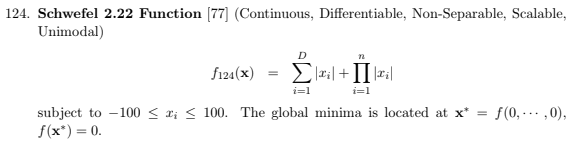
### Για D=2

In [4]:
! pip install deap

Δημιουργούμε μια μορφή 2 διαστάσεων της συνάρτησης.

In [5]:
from numpy import arange
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

def D2SchwefelFunc(x,y): 
    return (abs(x)+abs(y))+(abs(x)*abs(y))
 
x = arange(-100.0,100.0,0.5)
y = arange(-100.0,100.0,0.5)
X,Y = meshgrid(x, y) # grid of point
Z = D2SchwefelFunc(X, Y) # evaluation of the function on the grid

Απεικονίζουμε ένα “3D” γράφημα της συνάρτησης.

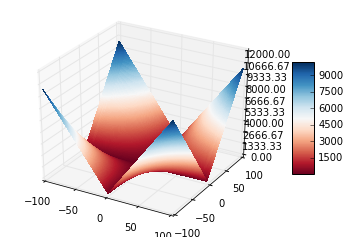

In [6]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, 
                      cmap=cm.RdBu,linewidth=0, antialiased=False)

ax.zaxis.set_major_locator(LinearLocator(10))
ax.zaxis.set_major_formatter(FormatStrFormatter('%.02f'))

fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

Ορίζουμε την συνάρτηση για κάθε αριθμό διαστάσεων.

In [7]:
import numpy as np
from deap import base, creator
from deap import tools

numVariables = 2 

creator.create( "FitnessMin", base.Fitness , weights=(-1.0,))
creator.create( "IndividualContainer", list , fitness= creator.FitnessMin)
toolbox2 = base.Toolbox()
toolbox2.register( "InitialValue", np.random.uniform, -100, 100)
toolbox2.register( "indiv", tools.initRepeat, creator.IndividualContainer, toolbox2.InitialValue, numVariables)
toolbox2.register( "population", tools.initRepeat, list , toolbox2.indiv)

def SchwefelFunc(indiv):
    
    D=len(indiv)
    sum_=0
    product_=1
    
    for i in range(0,D):
        sum_=sum_+abs(indiv[i])
        product_=product_*abs(indiv[i])
        
    sum = sum_+product_
    
    return (sum,)

Ορίζουμε τις συνασρτήσεις `feasible` και `distance` με τα κατάλληλα όρια της συνάρτησης.

In [8]:
MIN_BOUND = np.array([-100]*numVariables)
MAX_BOUND = np.array([100]*numVariables)

def feasible( indiv ):
    if any( indiv < MIN_BOUND) or any( indiv > MAX_BOUND):
        return False
    return True

def distance( indiv ) :
    dist = 0.0
    for i in range (len( indiv )) :
        penalty = 0
        if ( indiv [i] < MIN_BOUND[i]) : penalty = 100 - indiv [i]
        if ( indiv [i] > MAX_BOUND[i]) : penalty = indiv [i] - 100
        dist = dist + penalty
    return dist

In [9]:
toolbox2.register( "evaluate", SchwefelFunc)
toolbox2.decorate( "evaluate", tools.DeltaPenality (feasible, 0.5, distance))

In [10]:
from deap import algorithms

def ea2_with_stats(algorithm_value):
    import numpy
      
    pop = toolbox2.population(n=200)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", numpy.mean)
    stats.register("min", numpy.min)
    stats.register("max", numpy.max)
    
    if algorithm_value==0:
        pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)
    elif algorithm_value==1:
        pop, logbook = algorithms.eaMuPlusLambda(pop, toolbox2, 200, 100, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)
    else:
        pop, logbook = algorithms.eaMuCommaLambda(pop, toolbox2, 200, 200, cxpb=0.5, mutpb=0.2, ngen=50, stats=stats, halloffame=hof, verbose=True)
    
    return pop, logbook, hof

Εκτελούμε ,όπως και για την μη-κλιμακούμενη συνάρτηση, κάθε δυνατό συνδυασμό παραμέτρων και γενετικών αλγορίθμων.

In [11]:
import time
mate_values = [tools.cxBlend,tools.cxUniform]
alpha_values = [0.2,0.8]
mutate_values = [tools.mutGaussian,tools.mutShuffleIndexes]
indpb_values = [0.05,0.2]
tournsize_values = [3,10]
algorithm_values = [0,1,2]
averages=[]

for a in algorithm_values:
    for i in mate_values:
        for j in alpha_values:
            for k in mutate_values:
                for l in indpb_values:
                    for m in tournsize_values:
                        if (i==tools.cxBlend):
                            toolbox2.register( "mate", i, alpha = j)
                        else:
                            toolbox2.register( "mate", i, indpb = j)

                        if (k==tools.mutGaussian):
                            toolbox2.register( "mutate", k, mu = 0, sigma=1.0, indpb=l)
                        else:
                            toolbox2.register( "mutate", k, indpb=l)

                        toolbox2.register( "select", tools.selTournament, tournsize=m)
                        start_time = time.time()
                        min_sum=0
                        evals_sum=0
                        success_gen=0
                        success_gen_min=0                        
                        success_counter=0
                        success_evals_total_sum=0
                        for rounds in range(5):
                            success_evals_sum=0
                            pop, log, hof = ea2_with_stats(a)
                            min_sum = min_sum + log[50]['min']
                            if (log[50]['min']< 0.5): #goal+delta
                                success_counter = success_counter + 1
                            flag_gen = False
                            for gen in log:
                                success_evals_sum = success_evals_sum + gen['nevals']
                                evals_sum = evals_sum + gen['nevals']
                                if (flag_gen==False and gen['min']< 0.5):
                                    flag_gen=True
                                    success_gen= success_gen + gen['gen']
                                    success_gen_min = success_gen_min + gen['min']
                                    success_evals_total_sum = success_evals_total_sum + success_evals_sum
                                    
                            print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
                        avg_min = min_sum/5
                        avg_evals = evals_sum/5
                        avg_time = (time.time() - start_time)/5
                        if (success_counter == 0):
                            avg_success_gen = 'None'
                            avg_success_gen_min = 'None'
                            avg_success_evals = 'None'
                        else:
                            avg_success_gen = success_gen/success_counter
                            avg_success_gen_min = success_gen_min/success_counter
                            avg_success_evals = success_evals_total_sum/success_counter
                        operators = [i,j,k,l,'selTournament',m]
                        if (i==tools.cxBlend):
                            operators[0]='cxBlend'
                        else:
                            operators[0]='cxUniform'
                        if (k==tools.mutGaussian):
                            operators[2]='mutGaussian'
                        else:
                            operators[2]='mutShuffleIndexes'
                        algos = ['eaSimple','eaMuPlusLambda','eaMuCommaLambda']
                        if (algos[a]=='eaSimple'):
                            strategy = [algos[a],200,0.5,0.2]
                        else:
                            strategy = [algos[a],200,200,0.5,0.2]
                        info = {
                        "strategy": strategy,
                        "operators": operators,
                        "avg.min":    avg_min,
                        "avg.evals": avg_evals,
                        "avg.time":  avg_time,
                        "successes": success_counter,
                        "s.avg.gens": avg_success_gen,
                        "s.avg.min": avg_success_gen_min,
                        "s.avg.evals": avg_success_evals
                        }
                        averages.append(info)

gen	nevals	avg    	min    	max   
0  	200   	2691.33	10.0778	9720.3
1  	117   	785.09 	10.0778	5169.13
2  	122   	309.858	2.85904	3839.83
3  	127   	87.4929	2.61078	798.793
4  	150   	34.5437	0.360924	317.174
5  	122   	12.1198	0.498813	130.084
6  	117   	4.66894	0.297934	42.0332
7  	133   	2.2355 	0.0151054	12.0763
8  	132   	0.957536	0.0339676	4.1733 
9  	125   	0.478442	0.0139938	1.68661
10 	119   	0.236374	0.0105846	0.798042
11 	122   	0.121535	0.0105846	2.07011 
12 	119   	0.0621996	0.00393597	1.48992 
13 	119   	0.0366795	0.00426739	1.31877 
14 	123   	0.0337193	0.000945994	1.45196 
15 	96    	0.0226321	0.000438512	1.47284 
16 	130   	0.012574 	0.000230862	1.68172 
17 	148   	0.0203977	3.58883e-05	1.99769 
18 	116   	0.0397343	0.000153028	4.46967 
19 	130   	0.0211101	6.08148e-05	1.17158 
20 	112   	0.00402649	2.70741e-05	0.739524
21 	125   	0.0192429 	2.57586e-05	1.02033 
22 	139   	0.0190665 	7.57479e-06	1.49497 
23 	130   	0.0293554 	2.82468e-06	2.40152 
24 	121   	0.013446  	

37 	133   	0.0341745 	3.99816e-09	1.70194 
38 	119   	0.0241083 	2.32746e-09	1.59067 
39 	137   	0.0160407 	1.94755e-09	1.50536 
40 	111   	0.00455255	1.04695e-09	0.910507
41 	137   	0.0108516 	1.04695e-09	1.19171 
42 	109   	0.00452553	1.15827e-10	0.573851
43 	124   	0.0140009 	1.88553e-10	2.16457 
44 	111   	0.0534787 	1.76516e-10	4.84012 
45 	125   	0.0183378 	5.11818e-11	1.35177 
46 	140   	0.00556004	1.40277e-11	0.904135
47 	124   	0.0091503 	2.45055e-11	1.28696 
48 	117   	0.011883  	1.45059e-11	1.27433 
49 	116   	0.00371061	6.55415e-12	0.742122
50 	111   	0.000620098	4.5565e-12 	0.12402 
Best individual is: [-1.7141529866688657e-12, 2.842344562970374e-12]
with fitness: (4.556497549644113e-12,)
gen	nevals	avg    	min  	max    
0  	200   	2735.12	16.89	9275.73
1  	110   	897.601	16.89	5330.04
2  	106   	335.426	13.9243	2324.55
3  	129   	114.458	3.5013 	1134.37
4  	122   	48.8972	0.46763	846.447
5  	124   	20.7423	0.830073	230.066
6  	108   	8.75112	0.260202	42.2948
7  	109   	3.

13 	121   	0.00991908	6.22912e-05	1.43603  
14 	124   	0.0136562 	7.26448e-06	1.6632   
15 	129   	0.011876  	7.26448e-06	1.23687  
16 	127   	0.00836657	3.61351e-06	0.984239 
17 	120   	0.0039549 	5.81248e-07	0.385917 
18 	139   	0.0108678 	3.69329e-07	0.903172 
19 	123   	0.0237029 	1.393e-07  	1.8881   
20 	120   	0.00281709	3.57694e-08	0.407124 
21 	132   	0.0131863 	9.37548e-09	1.57403  
22 	126   	0.00936205	7.41012e-09	1.72699  
23 	114   	0.0104978 	2.20368e-09	1.08035  
24 	113   	0.0149872 	6.49808e-10	1.50526  
25 	113   	0.0173447 	1.21317e-10	2.51896  
26 	118   	0.0259049 	1.56724e-11	1.80189  
27 	113   	0.010503  	1.56724e-11	1.39013  
28 	125   	0.0248979 	6.95391e-12	1.92806  
29 	128   	0.000680306	1.34236e-12	0.111248 
30 	125   	0.0218369  	1.07241e-12	2.47236  
31 	110   	0.011699   	3.20833e-13	0.979629 
32 	103   	0.0148654  	2.68375e-13	1.57626  
33 	118   	0.0191189  	1.63239e-14	1.09204  
34 	121   	0.0463436  	1.35032e-14	3.04242  
35 	119   	0.00952068 	3.1

12 	126   	0.144195	0.00257237	1.35866
13 	117   	0.0989892	0.00221665	2.18132
14 	116   	0.142353 	0.00221665	7.25917
15 	112   	0.0748339	0.000954862	4.64128
16 	121   	0.0658283	0.000540413	2.07187
17 	109   	0.0718532	0.000540413	2.53987
18 	122   	0.0585435	0.000225601	2.1151 
19 	113   	0.0749162	0.00024233 	2.29787
20 	117   	0.0508166	8.58791e-05	2.49927
21 	123   	0.0645818	5.98775e-05	2.22621
22 	115   	0.0996266	0.00010521 	3.56116
23 	125   	0.0404478	1.78678e-05	1.35969
24 	117   	0.0905328	1.78678e-05	2.36578
25 	134   	0.110734 	2.62844e-06	3.34719
26 	117   	0.0819741	2.62844e-06	4.1008 
27 	141   	0.0927694	2.62844e-06	2.80665
28 	136   	0.111167 	9.58304e-07	5.1974 
29 	125   	0.0860516	1.77419e-07	6.12436
30 	124   	0.0711609	5.39461e-07	3.13806
31 	117   	0.0683052	1.55982e-07	2.0301 
32 	111   	0.0750395	1.55982e-07	1.85575
33 	100   	0.0422592	6.49728e-08	1.55134
34 	115   	0.0920968	6.49728e-08	2.56461
35 	113   	0.101177 	1.97849e-08	3.88335
36 	114   	0.0846186

7  	133   	0.0636659	0.00117254	2.12844
8  	117   	0.0360773	0.00117254	1.45834
9  	130   	0.0514967	0.000908377	2.19331
10 	119   	0.104776 	0.000908377	3.06628
11 	124   	0.0426432	0.000908377	1.60113
12 	112   	0.060672 	0.000905881	2.31116
13 	116   	0.0553205	0.000904694	2.05109
14 	128   	0.0642795	0.000904329	1.95244
15 	112   	0.0856876	0.000903994	2.54628
16 	115   	0.0837549	0.000903615	3.61119
17 	123   	0.0645931	0.000903615	3.63217
18 	124   	0.0683548	0.000903278	2.49297
19 	110   	0.0967896	0.000903169	6.80865
20 	111   	0.0577835	0.000903132	3.17998
21 	113   	0.0975033	0.000903117	2.279  
22 	118   	0.0833295	0.000903085	2.22525
23 	116   	0.0658827	0.000903069	3.34891
24 	122   	0.0764957	0.000903048	2.86049
25 	125   	0.0715036	0.000903048	2.0275 
26 	110   	0.0606457	0.000903044	2.23992
27 	130   	0.0531627	0.000903044	5.99652
28 	114   	0.0632042	0.000903043	2.72965
29 	112   	0.0850246	0.000903043	3.00446
30 	122   	0.0852086	0.000903042	2.12807
31 	118   	0.08232

8  	119   	0.0985186	0.00281395	2.81785
9  	114   	0.0788327	0.00281395	3.34772
10 	116   	0.0442069	0.00122474	1.46864
11 	119   	0.0288368	0.000327815	1.02199
12 	119   	0.043564 	0.000126828	1.79749
13 	138   	0.0953749	2.2755e-05 	3.97788
14 	114   	0.0358983	8.69526e-06	1.80305
15 	113   	0.103594 	1.2179e-06 	3.44783
16 	108   	0.068163 	1.2179e-06 	2.42809
17 	111   	0.0792787	5.69274e-07	4.89432
18 	112   	0.0520532	3.68859e-07	2.42152
19 	117   	0.16523  	5.88259e-08	11.7384
20 	130   	0.0334256	5.82215e-08	1.02946
21 	118   	0.101127 	1.94926e-08	2.7932 
22 	129   	0.0737684	6.24754e-09	3.00029
23 	126   	0.0687262	1.27021e-09	2.09277
24 	107   	0.0622782	4.49143e-10	3.63767
25 	131   	0.0680241	2.0938e-10 	4.34284
26 	123   	0.065483 	2.96375e-11	3.89477
27 	125   	0.0998848	2.89938e-11	3.91675
28 	113   	0.0873567	4.198e-12  	6.4255 
29 	122   	0.104646 	5.7141e-13 	3.68494
30 	104   	0.0879847	5.42567e-13	3.37752
31 	127   	0.0753256	3.53393e-13	2.06298
32 	123   	0.066629

39 	120   	2.19974e-09	3.62789e-10	8.87217e-09
40 	114   	1.27957e-09	4.75611e-11	2.90692e-09
41 	110   	8.22239e-10	4.75611e-11	2.07968e-09
42 	124   	5.13321e-10	4.75611e-11	1.20233e-09
43 	108   	3.11792e-10	2.84577e-11	8.27039e-10
44 	123   	1.64606e-10	2.35547e-12	4.45731e-10
45 	124   	8.81127e-11	2.35547e-12	2.96243e-10
46 	104   	4.68952e-11	2.35547e-12	1.10236e-10
47 	113   	2.58194e-11	2.35547e-12	5.90192e-11
48 	120   	1.48557e-11	6.71053e-13	4.16149e-11
49 	121   	7.54814e-12	6.71053e-13	2.56145e-11
50 	137   	3.5978e-12 	9.62732e-14	1.3292e-11 
Best individual is: [4.77955830044854e-15, 9.149359850985107e-14]
with fitness: (9.627315681030005e-14,)
gen	nevals	avg    	min    	max    
0  	200   	2666.72	33.0928	9673.47
1  	114   	933.189	4.18163	4912.04
2  	115   	301.232	4.18163	2366.59
3  	112   	119.945	1.75207	991.411
4  	123   	45.8788	1.75207	393.541
5  	100   	16.8063	1.30741	118.71 
6  	131   	6.93589	0.471219	94.9509
7  	134   	2.6686 	0.0829092	12.3377
8  	123   	1.

9  	119   	0.00243476	0.000803629	0.00689779
10 	100   	0.0012267 	0.000313303	0.001699  
11 	125   	0.000835601	0.000304311	0.0018978 
12 	126   	0.000545469	0.000149976	0.00103157
13 	121   	0.000308627	0.000149976	0.000523193
14 	102   	0.000218187	6.0086e-05 	0.000386214
15 	119   	0.000135969	1.60221e-05	0.00024334 
16 	116   	6.863e-05  	1.04129e-05	0.000174745
17 	111   	2.26176e-05	1.51646e-06	7.08555e-05
18 	115   	1.18402e-05	1.51646e-06	2.12232e-05
19 	110   	5.15159e-06	1.51646e-06	1.17011e-05
20 	122   	1.87923e-06	8.87939e-07	5.00879e-06
21 	138   	1.48982e-06	6.33507e-07	2.66468e-06
22 	112   	1.19512e-06	4.82729e-08	2.71532e-06
23 	124   	6.362e-07  	3.62644e-08	1.26511e-06
24 	114   	2.10983e-07	8.63603e-09	8.17888e-07
25 	119   	3.78344e-08	4.21205e-09	1.20515e-07
26 	134   	1.67611e-08	1.20741e-09	5.09251e-08
27 	124   	5.31652e-09	2.46224e-10	1.6436e-08 
28 	123   	2.03327e-09	2.46224e-10	5.40795e-09
29 	110   	5.65902e-10	7.8386e-11 	1.68128e-09
30 	115   	2.13457e

29 	106   	3.14004e-10	9.8924e-11 	5.37241e-10
30 	131   	1.88902e-10	3.65639e-11	3.19824e-10
31 	116   	1.10482e-10	6.65142e-12	2.1442e-10 
32 	145   	4.59116e-11	4.08688e-12	1.15157e-10
33 	111   	1.54598e-11	1.23084e-12	3.65639e-11
34 	119   	4.49817e-12	3.46226e-14	1.25063e-11
35 	116   	1.29211e-12	3.46226e-14	4.08688e-12
36 	116   	2.22005e-13	9.93369e-15	1.11444e-12
37 	115   	3.68641e-14	6.69438e-15	2.24924e-13
38 	110   	1.48598e-14	3.69101e-15	3.46226e-14
39 	128   	6.75273e-15	4.66619e-16	1.36907e-14
40 	110   	2.97521e-15	2.98324e-16	7.79737e-15
41 	111   	7.41776e-16	4.29564e-17	2.67395e-15
42 	122   	2.74146e-16	2.06631e-17	5.42927e-16
43 	101   	7.76318e-17	1.69411e-17	2.93502e-16
44 	130   	3.07767e-17	1.15381e-17	5.35379e-17
45 	117   	1.88895e-17	7.23077e-18	3.28235e-17
46 	113   	1.2139e-17 	4.58161e-18	2.14688e-17
47 	129   	7.69037e-18	2.40843e-18	1.76812e-17
48 	114   	4.54019e-18	1.55127e-18	7.93715e-18
49 	120   	2.59379e-18	3.32413e-19	5.09579e-18
50 	138   	1.

14 	110   	0.017967 	0.000744473	0.0458226
15 	119   	0.00980832	0.000487735	0.0306218
16 	106   	0.00550484	0.000505154	0.016969 
17 	114   	0.00322651	0.000257472	0.00766971
18 	118   	0.00164624	0.000140459	0.00560227
19 	111   	0.00077071	0.000130282	0.00272272
20 	113   	0.000379665	3.51883e-05	0.00077796
21 	111   	0.000241509	2.93141e-05	0.000556646
22 	119   	0.000138652	1.19163e-05	0.000400364
23 	122   	6.91927e-05	5.8151e-06 	0.000257472
24 	137   	3.73232e-05	3.53282e-06	8.67433e-05
25 	126   	2.09264e-05	2.63981e-06	4.88846e-05
26 	109   	1.15068e-05	1.05021e-06	2.95061e-05
27 	110   	6.72495e-06	7.3993e-07 	2.0624e-05 
28 	109   	3.94133e-06	1.32981e-07	9.51103e-06
29 	132   	2.42594e-06	1.32981e-07	5.25065e-06
30 	127   	1.37817e-06	9.86678e-08	3.5508e-06 
31 	116   	7.37471e-07	7.0289e-08 	2.03937e-06
32 	117   	4.04158e-07	4.74958e-08	1.1228e-06 
33 	127   	2.03306e-07	3.5427e-08 	6.10061e-07
34 	128   	9.98673e-08	1.6805e-08 	2.38966e-07
35 	108   	6.61137e-08	1.6805e

50 	124   	4.44305e-20	1.98663e-21	1.27456e-19
Best individual is: [1.7409338385763455e-21, 2.4569548875522947e-22]
with fitness: (1.986629327331575e-21,)
gen	nevals	avg    	min    	max    
0  	200   	2656.87	6.41557	8758.93
1  	119   	315.267	2.47126	3564.16
2  	119   	150.221	0.602734	4378.64
3  	116   	79.3899	0.281196	3897.19
4  	131   	0.899607	0.0879661	3.5446 
5  	115   	0.252746	0.0343576	0.59148
6  	109   	0.100675	0.00905447	0.234327
7  	124   	0.0380702	0.00189314	0.101202
8  	138   	0.0121064	0.00189314	0.0326944
9  	111   	0.00431451	0.001074  	0.0103333
10 	110   	0.0018234 	0.000401057	0.00319328
11 	129   	0.00123143	0.000277918	0.00262872
12 	97    	0.000617661	0.000141483	0.00116803
13 	108   	0.00032157 	2.89946e-05	0.000837438
14 	119   	0.000124883	1.46414e-05	0.000328128
15 	124   	4.64689e-05	9.61415e-06	0.000112358
16 	139   	1.80826e-05	1.04914e-07	4.25768e-05
17 	121   	6.62649e-06	1.04914e-07	2.27855e-05
18 	118   	1.59087e-06	8.25474e-08	4.57356e-06
19 	118 

18 	126   	0.0314158	0.00192933	0.636476
19 	128   	0.0474005	0.000510779	2.07499 
20 	125   	0.0184564	0.000510779	0.979214
21 	95    	0.0240875	0.000473225	0.981733
22 	129   	0.0160906	0.000384948	1.86035 
23 	126   	0.0130993	0.000248068	0.966631
24 	110   	0.0294901	0.000248068	1.60521 
25 	112   	0.0097042	5.99615e-05	0.511341
26 	120   	0.00777577	5.59636e-05	0.918138
27 	130   	0.0463347 	5.59636e-05	2.42833 
28 	132   	0.00380327	1.63551e-05	0.510577
29 	132   	0.0188924 	1.58548e-05	2.34611 
30 	104   	0.00857429	7.60607e-06	0.803919
31 	121   	0.000916587	4.16835e-06	0.170341
32 	115   	0.0183466  	2.75628e-06	1.04063 
33 	123   	0.0239947  	2.09821e-06	1.82854 
34 	125   	0.0232892  	1.39231e-06	3.04928 
35 	129   	0.00864297 	6.70947e-07	1.72705 
36 	123   	0.00959086 	6.70947e-07	1.26018 
37 	107   	0.00568792 	6.31869e-07	1.13701 
38 	119   	0.0322722  	1.82753e-07	1.82471 
39 	116   	0.0103458  	1.82753e-07	0.741174
40 	100   	0.0132589  	1.82274e-07	1.90627 
41 	110   

9  	124   	201.854	0.189237 	3415.18
10 	127   	144.576	0.189237 	3775.99
11 	120   	140.161	0.172923 	5146.08
12 	103   	99.6332	0.0862227	5007.16
13 	126   	80.4474	0.0414639	6352.44
14 	128   	0.347846	0.0414639	2.25197
15 	111   	0.189934	0.00684469	1.92945
16 	117   	0.157686	0.00684469	1.60516
17 	108   	0.112652	0.00684469	2.08057
18 	113   	0.0707512	0.00399873	1.53487
19 	138   	0.0495776	0.00479275	1.48608
20 	139   	0.0470403	0.00198943	1.84597
21 	127   	0.0329137	0.000676425	1.96707
22 	105   	0.0385415	0.000676425	1.88853
23 	124   	0.0331904	0.000478792	1.73288
24 	135   	0.0109617	0.000159733	0.875477
25 	113   	0.0156875	0.000314912	1.36702 
26 	107   	0.0178146	0.000138078	1.75967 
27 	128   	0.0165144	0.000124746	0.954881
28 	110   	0.00761719	9.20948e-05	1.06834 
29 	120   	0.0150114 	8.24503e-05	0.851613
30 	109   	0.0253792 	2.52795e-05	1.92438 
31 	113   	0.0184081 	1.84463e-05	1.31425 
32 	111   	0.0204349 	9.85563e-06	1.27722 
33 	115   	0.0335608 	9.85563e-06	

45 	124   	0.0225236  	6.41212e-18	2.41023    
46 	113   	0.00639915 	2.50295e-18	1.26182    
47 	129   	0.0078137  	6.45137e-19	1.01574    
48 	129   	0.00742233 	3.08286e-20	0.85588    
49 	134   	0.0250057  	3.08286e-20	2.09687    
50 	123   	0.0185069  	3.26234e-21	0.971489   
Best individual is: [2.2622629595666392e-21, 1.0000765529406158e-21]
with fitness: (3.262339512507255e-21,)
gen	nevals	avg    	min    	max    
0  	200   	2481.82	31.2766	9239.68
1  	121   	375.041	6.11371	3175.53
2  	121   	199.78 	1.43223	5747.33
3  	126   	128.289	0.861605	4458.39
4  	109   	113.076	0.251748	2861.56
5  	108   	206.423	0.251748	3694.24
6  	108   	73.2434	0.241204	2205.82
7  	122   	38.0665	0.105825	1698.86
8  	138   	0.271449	0.0342503	2.11658
9  	112   	0.221491	0.0257276	1.60115
10 	121   	0.0882368	0.0109778	0.95532
11 	119   	0.0481688	0.00531611	1.11164
12 	109   	0.0304344	0.000623445	1.18825
13 	118   	0.0322054	0.000623445	2.24175
14 	121   	0.0121735	0.000286884	0.963587
15 	114   	

32 	121   	34.0154	0.5     	1082.57
33 	122   	19.7396	0.5     	1010.8 
34 	121   	28.0806	0.5     	2393.12
35 	122   	27.936 	0.5     	1120.91
36 	106   	22.5186	0.5     	1468.85
37 	120   	31.08  	0.5     	1267.53
38 	125   	39.7642	0.5     	1309.16
39 	110   	12.4084	0.5     	1614.87
40 	112   	11.3299	0.5     	1114.31
41 	116   	25.2337	0.5     	1093.24
42 	128   	8.94642	0.5     	855.133
43 	136   	13.7706	0.5     	1415.88
44 	118   	34.5132	0.5     	1285.74
45 	129   	11.7609	0.5     	1508.53
46 	115   	14.9107	0.5     	1257.79
47 	128   	15.3808	0.5     	1063.8 
48 	108   	26.6904	0.5     	2453.76
49 	102   	12.5613	0.5     	1786.26
50 	131   	37.7369	0.5     	1642.68
Best individual is: [-7.424274165435275, 100.00000006276903]
with fitness: (0.5000000627690326,)
gen	nevals	avg    	min    	max    
0  	200   	2391.98	19.0151	8612.38
1  	112   	999.136	1.34791	5538.04
2  	115   	472.274	1.34791	6689.44
3  	109   	350.213	1.34791	4817.28
4  	128   	344.682	0.85914	7015.2 
5  	134  

33 	128   	0.0573881	2.35127e-12	2.05873
34 	96    	0.0679643	2.34131e-12	2.74548
35 	120   	0.0937336	9.3133e-13 	3.68328
36 	117   	0.0338822	4.77869e-13	1.49787
37 	117   	0.0948947	2.28536e-13	2.60947
38 	118   	0.0890941	2.12598e-14	2.57257
39 	126   	0.0825818	2.12598e-14	2.28561
40 	115   	0.0284955	3.57299e-15	2.00479
41 	114   	0.0476965	3.57299e-15	1.40625
42 	133   	0.0939547	2.32613e-15	2.54904
43 	129   	0.0786256	9.89856e-16	4.58972
44 	124   	0.0624669	2.84162e-16	2.61621
45 	127   	0.0595889	6.87896e-17	1.96017
46 	113   	0.0333935	4.77032e-17	1.99251
47 	129   	0.13816  	2.23169e-17	3.43557
48 	109   	0.0584648	1.46371e-17	2.25027
49 	106   	0.0351471	4.78828e-18	1.67046
50 	127   	0.0595712	2.10037e-19	1.9383 
Best individual is: [-1.7706249535817374e-19, -3.2974476511384076e-20]
with fitness: (2.1003697186955781e-19,)
gen	nevals	avg    	min    	max    
0  	200   	2682.12	7.94303	9308.37
1  	102   	359.389	3.59219	8196.18
2  	114   	61.4811	2.7292 	1552.3 
3  	117   	

32 	137   	0.0872117	3.47484e-11	4.15218
33 	117   	0.0885853	2.14688e-11	3.07481
34 	108   	0.0443953	5.74965e-12	1.70446
35 	122   	0.0810889	1.72037e-12	2.15357
36 	111   	0.0537271	1.72037e-12	3.32595
37 	132   	0.0886094	7.12362e-13	1.9048 
38 	134   	0.0314254	4.41358e-13	1.42688
39 	125   	0.0549768	1.14126e-13	2.96586
40 	129   	0.117291 	1.06975e-13	3.07688
41 	122   	0.0730609	5.36962e-14	2.60375
42 	103   	0.077615 	8.35309e-15	2.10027
43 	123   	0.0481049	6.50021e-15	2.24392
44 	121   	0.140691 	3.19514e-15	10.5354
45 	112   	0.108814 	1.38821e-15	3.23501
46 	130   	0.109935 	6.48513e-16	4.28919
47 	118   	0.0663013	5.34463e-16	6.37603
48 	124   	0.0986392	2.27852e-16	2.36351
49 	120   	0.0404235	1.09906e-16	1.80897
50 	129   	0.101669 	3.96687e-17	2.35925
Best individual is: [-3.909906374899274e-17, 5.696527955086381e-19]
with fitness: (3.9668716544501377e-17,)
gen	nevals	avg    	min	max    
0  	200   	2567.38	19 	9806.66
1  	117   	945.645	1.22775	5176.47
2  	134   	365.4

35 	104   	0.00539215	0.000668349	0.0142407
36 	115   	0.00341915	0.000668349	0.0134197
37 	120   	0.00217578	0.0003733  	0.00539778
38 	113   	0.0015405 	6.52413e-05	0.00436009
39 	129   	0.000990774	6.52413e-05	0.00321812
40 	116   	0.000635117	6.20475e-05	0.0019132 
41 	125   	0.000439094	5.62136e-05	0.00108235
42 	121   	0.000267429	1.54001e-05	0.000749864
43 	110   	0.000145033	1.54001e-05	0.000663421
44 	115   	9.09357e-05	8.33763e-06	0.000221941
45 	118   	5.5614e-05 	4.23928e-06	0.000224869
46 	111   	3.15459e-05	3.3938e-06 	0.000111117
47 	117   	1.65704e-05	2.09062e-06	5.06635e-05
48 	129   	1.00395e-05	8.83053e-07	4.93144e-05
49 	125   	5.64612e-06	8.44691e-07	2.63105e-05
50 	116   	3.13032e-06	1.64071e-07	7.80366e-06
Best individual is: [1.76230075179657e-08, 1.4644819123737124e-07]
with fitness: (1.640712013361945e-07,)
gen	nevals	avg    	min   	max    
0  	200   	2288.98	17.859	9354.39
1  	117   	1045.83	6.92008	5637.72
2  	102   	504.575	6.92008	7097.57
3  	125   	427.24

20 	130   	1.122e-06  	6.94114e-08	3.48343e-06
21 	143   	4.36934e-07	3.84357e-08	1.59952e-06
22 	111   	1.66847e-07	2.09994e-08	5.21002e-07
23 	122   	5.70213e-08	8.88654e-09	1.91368e-07
24 	115   	2.76581e-08	2.23609e-09	7.06621e-08
25 	139   	1.05961e-08	6.01831e-10	4.13237e-08
26 	140   	4.09102e-09	2.93782e-10	1.17444e-08
27 	127   	1.20079e-09	2.80634e-11	4.41664e-09
28 	113   	4.83069e-10	2.80634e-11	1.08902e-09
29 	115   	2.11284e-10	2.80634e-11	6.10402e-10
30 	109   	6.22445e-11	6.22966e-12	3.83494e-10
31 	120   	2.65341e-11	2.53581e-12	6.01131e-11
32 	142   	1.5757e-11 	2.53581e-12	4.47902e-11
33 	124   	6.02245e-12	2.33448e-12	2.35245e-11
34 	116   	2.87103e-12	2.27732e-13	7.54918e-12
35 	115   	2.1865e-12 	1.79338e-13	7.3125e-12 
36 	120   	9.62827e-13	1.79338e-13	4.2729e-12 
37 	116   	2.90613e-13	3.04913e-14	9.84923e-13
38 	131   	1.50568e-13	2.79477e-14	3.28389e-13
39 	122   	7.43441e-14	5.93991e-15	2.16853e-13
40 	135   	3.12698e-14	2.15831e-15	1.12532e-13
41 	110   	1.

13 	121   	393.081	0.518696	9112.39
14 	136   	511.256	0.503715	9701.31
15 	123   	580.001	0.502102	9258.2 
16 	120   	414.077	0.501666	9480.06
17 	117   	382.941	0.501666	9607.75
18 	126   	359.344	0.500318	7984.62
19 	121   	367.464	0.500035	9882.05
20 	122   	331.861	0.500035	9958.57
21 	121   	120.723	0.500192	6378.48
22 	127   	375.163	0.500009	9725.22
23 	109   	277.473	0.500009	9731.86
24 	126   	231.824	0.500009	8892.34
25 	117   	174.573	0.500001	7359.21
26 	124   	150.358	0.500001	5314.37
27 	117   	150.486	0.500001	6439.4 
28 	115   	185.947	0.500001	5974.7 
29 	124   	268.763	0.5     	7388.83
30 	116   	280.549	0.5     	7320.49
31 	133   	266.217	0.5     	5202.4 
32 	111   	127.772	0.5     	5297.49
33 	106   	144.722	0.5     	4881.31
34 	117   	154.438	0.5     	5800.91
35 	132   	280.845	0.5     	6919.38
36 	118   	206.509	0.5     	6600.04
37 	126   	228.646	0.5     	9355.72
38 	126   	310.161	0.5     	8738.04
39 	125   	376.157	0.5     	6334.11
40 	117   	207.4  	0.5     	

18 	129   	1.01083e-05	2.39149e-06	2.65203e-05
19 	120   	3.66334e-06	1.08943e-06	1.06788e-05
20 	117   	2.40276e-06	4.85504e-07	4.31393e-06
21 	127   	1.45908e-06	3.75448e-07	3.8896e-06 
22 	113   	7.7449e-07 	1.01487e-07	2.26829e-06
23 	151   	3.95332e-07	1.86086e-08	1.26433e-06
24 	134   	1.40593e-07	7.35186e-09	4.13293e-07
25 	131   	4.90855e-08	2.82381e-09	1.57547e-07
26 	114   	1.44528e-08	5.15191e-10	4.98047e-08
27 	126   	4.80897e-09	5.15191e-10	1.2296e-08 
28 	133   	1.72949e-09	2.72108e-10	5.84604e-09
29 	102   	5.82786e-10	7.10692e-11	3.08835e-09
30 	117   	3.89576e-10	5.89888e-11	1.20978e-09
31 	123   	2.20059e-10	1.87734e-11	6.60125e-10
32 	122   	7.8115e-11 	9.75327e-12	2.47839e-10
33 	112   	3.58644e-11	9.27997e-12	9.54299e-11
34 	130   	1.61679e-11	1.11222e-12	3.95149e-11
35 	132   	8.33101e-12	1.11222e-12	2.25175e-11
36 	128   	3.50504e-12	3.17904e-13	1.01991e-11
37 	112   	1.17419e-12	9.66719e-14	4.34929e-12
38 	121   	3.94236e-13	3.94015e-14	1.17115e-12
39 	111   	1.

0  	200   	2179.92	34.6234	8429.07
1  	109   	323.719	1.0645 	4252.08
2  	117   	149.671	1.0645 	3264.95
3  	118   	161.329	0.999428	4415.86
4  	99    	214.296	0.596409	5702.9 
5  	123   	208.063	0.596409	4655.35
6  	114   	147.685	0.528933	7058.52
7  	126   	212.764	0.502437	6307.14
8  	121   	206.514	0.502437	8009   
9  	116   	121.402	0.500279	4371.42
10 	143   	116.988	0.500069	3424.02
11 	117   	141.06 	0.500046	3322.93
12 	123   	232.762	0.500007	6037.52
13 	120   	57.9576	0.500006	5737.22
14 	112   	36.2128	0.5     	1894.25
15 	109   	62.9642	0.5     	2014.26
16 	105   	116.342	0.5     	2473.95
17 	121   	80.9061	0.5     	1565.64
18 	125   	19.2884	0.5     	1037.89
19 	113   	111.569	0.5     	6383.62
20 	119   	75.1978	0.5     	3228.7 
21 	123   	157.73 	0.5     	6043.24
22 	123   	208.482	0.5     	7168.83
23 	113   	229.103	0.5     	7990.04
24 	112   	51.7134	0.5     	1488.89
25 	109   	153.219	0.5     	4488.61
26 	127   	164.985	0.5     	6700.48
27 	112   	240.117	0.5     	467

4  	108   	64.1485	1.83435	2619.21
5  	108   	18.8295	1.83435	97.4529
6  	130   	7.19321	0.941962	30.3786
7  	103   	4.6948 	0.941962	10.4231
8  	134   	3.91919	0.941962	8.36234
9  	136   	2.58283	0.941962	6.54679
10 	105   	1.60598	0.941962	4.8904 
11 	111   	1.26443	0.364788	3.40706
12 	128   	1.01133	0.297135	4.36029
13 	125   	0.903792	0.292381	2.68037
14 	121   	0.823861	0.219735	3.24345
15 	118   	0.649837	0.219735	2.37955
16 	127   	0.417945	0.219735	1.02491
17 	120   	0.311162	0.0999913	1.88624
18 	124   	0.260847	0.0999913	1.50991
19 	123   	0.229747	0.0999913	2.48723
20 	127   	0.185811	0.0999913	2.00858
21 	121   	0.122016	0.0999913	1.03675
22 	114   	0.123328	0.0999913	1.99524
23 	115   	0.10167 	0.0999913	0.435783
24 	123   	0.108872	0.0989463	1.18352 
25 	131   	0.100258	0.0167891	0.240738
26 	114   	0.12266 	0.0167891	2.95586 
27 	122   	0.110169	0.0167891	1.00994 
28 	121   	0.098495	0.0167891	1.83345 
29 	130   	0.0634271	0.0167891	1.76243 
30 	107   	0.0385369	0.01678

9  	112   	0.230554	0.190386	3.23264
10 	125   	0.199321	0.0615348	1.37326
11 	120   	0.206629	0.0615348	2.19491
12 	129   	0.138177	0.0615348	1.40245
13 	133   	0.0764024	0.0615348	1.53722
14 	129   	0.0688842	0.0615348	0.970782
15 	108   	0.0761761	0.0615348	1.377   
16 	128   	0.0788338	0.0615348	1.92059 
17 	128   	0.0965147	0.0615348	3.85779 
18 	111   	0.069658 	0.0615348	0.933396
19 	111   	0.0753303	0.0615348	0.939616
20 	116   	0.0879672	0.0615348	1.833   
21 	126   	0.0815189	0.0615348	1.96532 
22 	123   	0.0748238	0.0615348	1.42312 
23 	137   	0.0818364	0.0615348	1.61997 
24 	130   	0.0777868	0.0615348	1.53135 
25 	116   	0.0683924	0.0615348	0.99091 
26 	105   	0.0850375	0.0615348	2.05823 
27 	131   	0.0654879	0.0615348	0.809218
28 	109   	0.0782447	0.0615348	1.77055 
29 	117   	0.0780167	0.0615348	1.99143 
30 	108   	0.0687436	0.0615348	1.25902 
31 	116   	0.0896094	0.0615348	1.81525 
32 	106   	0.0807338	0.0615348	1.3458  
33 	109   	0.0699154	0.0615348	1.04481 
34 	121   

8  	126   	2.51656	0.789944	11.7248
9  	115   	1.58934	0.583732	4.33796
10 	119   	1.35436	0.583732	5.04334
11 	108   	1.15663	0.494424	3.91868
12 	116   	0.956946	0.32349 	4.08464
13 	133   	0.768781	0.0498779	3.60831
14 	113   	0.580758	0.0498779	3.6395 
15 	118   	0.532668	0.0498779	5.9627 
16 	120   	0.385934	0.0231012	3.31411
17 	122   	0.295369	0.0231012	5.20867
18 	113   	0.153815	0.0231012	3.65936
19 	113   	0.10597 	0.0231012	2.03558
20 	112   	0.0717026	0.0231012	1.52671
21 	129   	0.0792235	0.0231012	3.41443
22 	116   	0.0816527	0.0231012	2.8974 
23 	125   	0.0926835	0.0092792	2.26109
24 	131   	0.0566678	0.0092792	1.17682
25 	114   	0.0958508	0.0092792	2.73933
26 	119   	0.124847 	0.0092792	4.39707
27 	124   	0.0887354	0.0092792	1.62385
28 	124   	0.0523149	0.0092792	2.73281
29 	106   	0.0738431	0.0092792	3.15795
30 	123   	0.0686448	0.0092792	2.38489
31 	120   	0.0718492	0.0092792	1.92487
32 	108   	0.0462614	0.0092792	1.33337
33 	116   	0.113325 	0.0092792	9.7372 
34 	115

14 	124   	0.0828275	0.0328925	2.24377
15 	108   	0.096746 	0.0328925	3.07249
16 	115   	0.117089 	0.0328925	4.23373
17 	128   	0.104977 	0.0328925	2.8776 
18 	118   	0.0944614	0.0328925	2.13985
19 	116   	0.096174 	0.0328925	2.08005
20 	112   	0.0812826	0.0328925	2.50915
21 	130   	0.0842325	0.0328925	1.63989
22 	116   	0.0795308	0.0328925	1.39838
23 	129   	0.075761 	0.0328925	2.12411
24 	125   	0.0894058	0.0328925	1.49925
25 	118   	0.127501 	0.0328925	4.33339
26 	113   	0.178986 	0.0328925	3.09935
27 	114   	0.0617958	0.0328925	1.78835
28 	126   	0.0880117	0.0328925	2.1414 
29 	115   	0.10767  	0.0328925	1.66647
30 	139   	0.17484  	0.0328925	10.1991
31 	117   	0.111199 	0.0328925	2.3939 
32 	119   	0.101826 	0.0328925	3.05785
33 	116   	0.096645 	0.0328925	2.92019
34 	118   	0.125037 	0.0328925	4.56525
35 	122   	0.0927286	0.0328925	4.45025
36 	119   	0.0671243	0.0328925	1.40259
37 	114   	0.0797961	0.0328925	1.38748
38 	138   	0.134048 	0.0328925	5.25291
39 	101   	0.0900677	0.02

13 	116   	0.0999367	0.0144096	2.14161
14 	113   	0.069553 	0.0144096	1.9694 
15 	129   	0.0781276	0.0144096	4.94528
16 	126   	0.0738646	0.00417927	2.04361
17 	113   	0.0602325	0.00417927	1.91974
18 	125   	0.118042 	0.00417927	3.28381
19 	111   	0.0732855	0.00417927	3.93713
20 	121   	0.0759783	0.00417927	2.70284
21 	121   	0.139857 	0.00417927	6.0691 
22 	118   	0.0604555	0.00417927	3.44157
23 	113   	0.105513 	0.00417927	4.754  
24 	118   	0.100554 	0.00417927	2.17265
25 	109   	0.10389  	0.00417927	2.76593
26 	137   	0.124196 	0.00417927	3.2713 
27 	115   	0.0878704	0.00417927	2.87733
28 	119   	0.0682196	0.00417927	2.4523 
29 	121   	0.0786307	0.00417927	3.67419
30 	127   	0.0642076	0.00417927	2.47743
31 	112   	0.0872194	0.00417927	2.90818
32 	119   	0.0680985	0.00417927	2.18686
33 	122   	0.0708929	0.00417927	2.03542
34 	118   	0.0530632	0.00417927	1.77588
35 	121   	0.0556608	0.00417927	2.27524
36 	122   	0.0907948	0.00417927	4.26242
37 	130   	0.091572 	0.00417927	3.75334
38 

8  	117   	1.15288	0.181975	2.39669
9  	132   	0.931303	0.181975	2.39669
10 	113   	0.75718 	0.181975	1.0037 
11 	105   	0.502446	0.181975	1.0037 
12 	128   	0.247712	0.181975	1.0037 
13 	106   	0.181975	0.181975	0.181975
14 	116   	0.181975	0.181975	0.181975
15 	122   	0.181975	0.181975	0.181975
16 	131   	0.181975	0.181975	0.181975
17 	107   	0.181975	0.181975	0.181975
18 	133   	0.181975	0.181975	0.181975
19 	114   	0.181975	0.181975	0.181975
20 	123   	0.181975	0.181975	0.181975
21 	122   	0.181975	0.181975	0.181975
22 	134   	0.181975	0.181975	0.181975
23 	102   	0.181975	0.181975	0.181975
24 	125   	0.181975	0.181975	0.181975
25 	125   	0.181975	0.181975	0.181975
26 	130   	0.181975	0.181975	0.181975
27 	104   	0.181975	0.181975	0.181975
28 	132   	0.181975	0.181975	0.181975
29 	116   	0.181975	0.181975	0.181975
30 	119   	0.181975	0.181975	0.181975
31 	113   	0.181975	0.181975	0.181975
32 	117   	0.181975	0.181975	0.181975
33 	111   	0.181975	0.181975	0.181975
34 	125   	0.18197

17 	107   	0.491373	0.491373	0.491373
18 	123   	0.491373	0.491373	0.491373
19 	126   	0.491373	0.491373	0.491373
20 	108   	0.491373	0.491373	0.491373
21 	125   	0.491373	0.491373	0.491373
22 	130   	0.491373	0.491373	0.491373
23 	125   	0.491373	0.491373	0.491373
24 	114   	0.491373	0.491373	0.491373
25 	117   	0.491373	0.491373	0.491373
26 	116   	0.491373	0.491373	0.491373
27 	116   	0.491373	0.491373	0.491373
28 	118   	0.491373	0.491373	0.491373
29 	125   	0.491373	0.491373	0.491373
30 	116   	0.491373	0.491373	0.491373
31 	113   	0.491373	0.491373	0.491373
32 	109   	0.491373	0.491373	0.491373
33 	115   	0.491373	0.491373	0.491373
34 	128   	0.491373	0.491373	0.491373
35 	111   	0.491373	0.491373	0.491373
36 	128   	0.491373	0.491373	0.491373
37 	132   	0.491373	0.491373	0.491373
38 	114   	0.491373	0.491373	0.491373
39 	117   	0.491373	0.491373	0.491373
40 	108   	0.491373	0.491373	0.491373
41 	112   	0.491373	0.491373	0.491373
42 	119   	0.491373	0.491373	0.491373
43 	125   	0

38 	126   	0.0484416	0.0484416	0.0484416
39 	133   	0.0484416	0.0484416	0.0484416
40 	116   	0.0484416	0.0484416	0.0484416
41 	134   	0.0484416	0.0484416	0.0484416
42 	109   	0.0484416	0.0484416	0.0484416
43 	117   	0.0484416	0.0484416	0.0484416
44 	110   	0.0484416	0.0484416	0.0484416
45 	129   	0.0484416	0.0484416	0.0484416
46 	122   	0.0484416	0.0484416	0.0484416
47 	117   	0.0484416	0.0484416	0.0484416
48 	131   	0.0484416	0.0484416	0.0484416
49 	124   	0.0484416	0.0484416	0.0484416
50 	116   	0.0484416	0.0484416	0.0484416
Best individual is: [-0.02393436383658809, -0.02393436383658809]
with fitness: (0.04844158144543836,)
gen	nevals	avg    	min    	max    
0  	200   	2526.34	7.74144	8635.31
1  	129   	1030.1 	5.67776	5787.44
2  	131   	377.802	1.66066	2672.92
3  	126   	130.19 	1.66066	2166.05
4  	119   	32.7028	0.882856	727.465
5  	122   	7.49986	0.882856	54.7923
6  	123   	3.03907	0.438351	12.2427
7  	106   	1.49532	0.438351	6.37581
8  	111   	0.977075	0.438351	2.17411
9  	110  

2  	129   	19.5954	1.89403	533.302
3  	121   	3.31116	1.89403	10.8007
4  	111   	2.42318	0.825058	5.96075
5  	104   	1.7956 	0.825058	3.58911
6  	137   	1.19385	0.825058	1.89403
7  	129   	0.825058	0.825058	0.825058
8  	123   	0.825058	0.825058	0.825058
9  	118   	0.825058	0.825058	0.825058
10 	122   	0.825058	0.825058	0.825058
11 	111   	0.825058	0.825058	0.825058
12 	115   	0.825058	0.825058	0.825058
13 	128   	0.825058	0.825058	0.825058
14 	106   	0.825058	0.825058	0.825058
15 	129   	0.825058	0.825058	0.825058
16 	109   	0.825058	0.825058	0.825058
17 	114   	0.825058	0.825058	0.825058
18 	122   	0.825058	0.825058	0.825058
19 	129   	0.825058	0.825058	0.825058
20 	123   	0.825058	0.825058	0.825058
21 	112   	0.825058	0.825058	0.825058
22 	135   	0.825058	0.825058	0.825058
23 	116   	0.825058	0.825058	0.825058
24 	107   	0.825058	0.825058	0.825058
25 	124   	0.825058	0.825058	0.825058
26 	116   	0.825058	0.825058	0.825058
27 	114   	0.825058	0.825058	0.825058
28 	123   	0.825058	0.82

14 	122   	0.279924	0.141856	2.79583 
15 	125   	0.266521	0.141856	1.48771 
16 	136   	0.280063	0.141856	2.29091 
17 	120   	0.255046	0.141856	0.259579
18 	131   	0.274887	0.141856	1.64937 
19 	117   	0.262872	0.0763865	1.88215 
20 	125   	0.214215	0.0763865	1.00486 
21 	112   	0.201607	0.0763865	2.2418  
22 	129   	0.173782	0.0763865	2.05283 
23 	114   	0.126547	0.0763865	0.910056
24 	128   	0.112108	0.0629433	1.93873 
25 	111   	0.0861087	0.0629433	0.819252
26 	124   	0.0936641	0.0629433	2.02665 
27 	140   	0.0824207	0.0629433	1.23732 
28 	127   	0.104638 	0.0629433	1.7176  
29 	109   	0.0787882	0.0629433	1.54874 
30 	122   	0.0842196	0.0629433	2.43368 
31 	142   	0.0679438	0.0629433	0.6342  
32 	110   	0.0915267	0.0629433	2.08145 
33 	114   	0.0987354	0.0629433	2.20897 
34 	125   	0.0758159	0.0629433	1.27921 
35 	104   	0.0781165	0.0629433	1.37023 
36 	125   	0.0778045	0.0629433	2.46852 
37 	115   	0.0665969	0.0629433	0.768889
38 	129   	0.0999205	0.0629433	1.97086 
39 	103   	0.076

16 	119   	0.848298	0.370615	1.49417
17 	131   	0.683754	0.162593	1.25804
18 	119   	0.484433	0.162593	1.83066
19 	107   	0.373591	0.162593	0.511315
20 	135   	0.399808	0.162593	3.66823 
21 	121   	0.347567	0.162593	2.76006 
22 	110   	0.255402	0.162593	1.46409 
23 	119   	0.19629 	0.0648323	2.91412 
24 	125   	0.180194	0.0648323	1.50725 
25 	95    	0.16996 	0.0648323	1.79234 
26 	107   	0.167596	0.0648323	1.60801 
27 	114   	0.152498	0.0648323	1.23903 
28 	119   	0.119038	0.0648323	0.937435
29 	130   	0.0958689	0.0624201	1.29638 
30 	116   	0.0749165	0.0624201	0.776635
31 	117   	0.0866854	0.0624201	2.11774 
32 	113   	0.0778548	0.0370943	1.48653 
33 	108   	0.0915749	0.0370943	1.67475 
34 	131   	0.075782 	0.0370943	2.42148 
35 	129   	0.076136 	0.0370943	1.35197 
36 	107   	0.0634614	0.0370943	0.641193
37 	121   	0.068417 	0.0370943	1.35825 
38 	115   	0.0605407	0.0370943	1.31903 
39 	130   	0.0533885	0.0370943	2.11481 
40 	112   	0.057276 	0.0370943	2.25998 
41 	117   	0.0558346	0.

14 	127   	0.230245	0.20428 	1.84905 
15 	122   	0.226994	0.170048	1.80913 
16 	140   	0.229021	0.170048	1.29627 
17 	118   	0.207939	0.170048	1.65111 
18 	121   	0.203592	0.0252457	2.68417 
19 	115   	0.171052	0.0252457	1.32314 
20 	112   	0.139476	0.0252457	1.6297  
21 	132   	0.0513514	0.0252457	1.44532 
22 	119   	0.0531745	0.0252457	1.96201 
23 	101   	0.0313967	0.0252457	0.622238
24 	109   	0.0334837	0.0252457	0.87093 
25 	128   	0.0536808	0.0252457	1.8782  
26 	109   	0.0471983	0.0252457	2.08771 
27 	129   	0.0352564	0.0252457	1.72828 
28 	128   	0.0535799	0.0252457	1.82836 
29 	121   	0.0387872	0.0252457	1.62058 
30 	123   	0.0457492	0.0252457	1.08591 
31 	118   	0.0359791	0.0193359	1.70538 
32 	109   	0.0329571	0.0193359	0.903877
33 	137   	0.0502627	0.0193359	2.15946 
34 	121   	0.0371664	0.0193359	1.92427 
35 	119   	0.028651 	0.0193359	1.19088 
36 	105   	0.0200614	0.0193359	0.164432
37 	111   	0.0325781	0.0193359	1.66861 
38 	122   	0.0229017	0.0193359	0.706641
39 	123   	

11 	125   	0.891  	0.0648993	2.74951
12 	118   	0.709268	0.0648993	3.03248
13 	114   	0.497601	0.0648993	2.62259
14 	111   	0.403417	0.0648993	4.43614
15 	112   	0.273633	0.0648993	3.44325
16 	125   	0.133925	0.0648993	1.43771
17 	133   	0.142831	0.0648993	5.12885
18 	119   	0.163941	0.0648993	2.80933
19 	115   	0.145004	0.0346449	6.7626 
20 	117   	0.106695	0.0346449	2.30604
21 	137   	0.200449	0.0346449	4.1445 
22 	123   	0.151436	0.0346449	2.4341 
23 	115   	0.103718	0.0346449	1.93386
24 	120   	0.105656	0.0346449	1.9813 
25 	100   	0.102616	0.0269545	3.31281
26 	121   	0.0776238	0.0269545	1.26712
27 	124   	0.102514 	0.0269545	4.31212
28 	126   	0.107708 	0.0269545	2.97202
29 	132   	0.0743111	0.0269545	1.46009
30 	134   	0.112955 	0.0269545	4.06837
31 	120   	0.124856 	0.0269545	3.175  
32 	119   	0.137758 	0.00527265	2.61978
33 	114   	0.111203 	0.00527265	2.23532
34 	131   	0.0805482	0.00527265	3.446  
35 	121   	0.0748159	0.00527265	1.92262
36 	118   	0.0759704	0.00507189	3.374

14 	120   	0.10196  	0.0328699	2.10289
15 	127   	0.118475 	0.0328699	2.1027 
16 	122   	0.100126 	0.0328699	2.76446
17 	105   	0.0751659	0.0328699	2.38222
18 	131   	0.107305 	0.0328699	1.69932
19 	127   	0.0948169	0.0328699	2.12973
20 	126   	0.12485  	0.00868982	2.40583
21 	120   	0.0892704	0.00868982	2.75   
22 	124   	0.236308 	0.00868982	8.57362
23 	136   	0.0530103	0.00868982	2.78974
24 	110   	0.0583184	0.00868982	2.26307
25 	103   	0.0533722	0.00868982	2.14959
26 	107   	0.100958 	0.00868982	4.72974
27 	115   	0.104621 	0.00868982	3.19159
28 	127   	0.0549829	0.00868982	1.63301
29 	117   	0.042185 	0.00868982	2.62159
30 	129   	0.0835732	0.00868982	6.53835
31 	117   	0.0898734	0.00868982	3.11974
32 	124   	0.0719745	0.00868982	1.9539 
33 	128   	0.0898795	0.00868982	3.92384
34 	119   	0.0845039	0.00868982	4.04411
35 	111   	0.102296 	0.00868982	2.53917
36 	121   	0.0678373	0.00868982	2.8613 
37 	114   	0.0910517	0.00868982	2.70729
38 	118   	0.0631693	0.00868982	2.0207 
39 	11

10 	129   	2.08756	1.192  	3.2704 
11 	127   	1.4149 	1.192  	3.04949
12 	135   	1.20129	1.192  	3.04949
13 	122   	1.192  	1.192  	1.192  
14 	116   	1.192  	1.192  	1.192  
15 	134   	1.192  	1.192  	1.192  
16 	120   	1.192  	1.192  	1.192  
17 	118   	1.192  	1.192  	1.192  
18 	107   	1.192  	1.192  	1.192  
19 	122   	1.192  	1.192  	1.192  
20 	110   	1.192  	1.192  	1.192  
21 	101   	1.192  	1.192  	1.192  
22 	116   	1.192  	1.192  	1.192  
23 	122   	1.192  	1.192  	1.192  
24 	110   	1.192  	1.192  	1.192  
25 	137   	1.192  	1.192  	1.192  
26 	130   	1.192  	1.192  	1.192  
27 	124   	1.192  	1.192  	1.192  
28 	133   	1.192  	1.192  	1.192  
29 	139   	1.192  	1.192  	1.192  
30 	115   	1.192  	1.192  	1.192  
31 	112   	1.192  	1.192  	1.192  
32 	117   	1.192  	1.192  	1.192  
33 	129   	1.192  	1.192  	1.192  
34 	113   	1.192  	1.192  	1.192  
35 	122   	1.192  	1.192  	1.192  
36 	116   	1.192  	1.192  	1.192  
37 	113   	1.192  	1.192  	1.192  
38 	119   	1.192  	1

26 	113   	2.09325	2.09325	2.09325
27 	107   	2.09325	2.09325	2.09325
28 	121   	2.09325	2.09325	2.09325
29 	119   	2.09325	2.09325	2.09325
30 	121   	2.09325	2.09325	2.09325
31 	112   	2.09325	2.09325	2.09325
32 	121   	2.09325	2.09325	2.09325
33 	129   	2.09325	2.09325	2.09325
34 	112   	2.09325	2.09325	2.09325
35 	129   	2.09325	2.09325	2.09325
36 	141   	2.09325	2.09325	2.09325
37 	116   	2.09325	2.09325	2.09325
38 	119   	2.09325	2.09325	2.09325
39 	117   	2.09325	2.09325	2.09325
40 	114   	2.09325	2.09325	2.09325
41 	102   	2.09325	2.09325	2.09325
42 	122   	2.09325	2.09325	2.09325
43 	119   	2.09325	2.09325	2.09325
44 	146   	2.09325	2.09325	2.09325
45 	122   	2.09325	2.09325	2.09325
46 	133   	2.09325	2.09325	2.09325
47 	120   	2.09325	2.09325	2.09325
48 	116   	2.09325	2.09325	2.09325
49 	119   	2.09325	2.09325	2.09325
50 	119   	2.09325	2.09325	2.09325
Best individual is: [0.7587647228461947, 0.7587647228461947]
with fitness: (2.093253350328252,)
gen	nevals	avg    	min    	ma

33 	121   	0.31796 	0.31796	0.31796
34 	137   	0.31796 	0.31796	0.31796
35 	118   	0.31796 	0.31796	0.31796
36 	118   	0.31796 	0.31796	0.31796
37 	117   	0.31796 	0.31796	0.31796
38 	118   	0.31796 	0.31796	0.31796
39 	113   	0.31796 	0.31796	0.31796
40 	106   	0.31796 	0.31796	0.31796
41 	109   	0.31796 	0.31796	0.31796
42 	122   	0.31796 	0.31796	0.31796
43 	103   	0.31796 	0.31796	0.31796
44 	121   	0.31796 	0.31796	0.31796
45 	119   	0.31796 	0.31796	0.31796
46 	137   	0.31796 	0.31796	0.31796
47 	117   	0.31796 	0.31796	0.31796
48 	117   	0.31796 	0.31796	0.31796
49 	108   	0.31796 	0.31796	0.31796
50 	130   	0.31796 	0.31796	0.31796
Best individual is: [0.1480244030034754, 0.1480244030034754]
with fitness: (0.31796002989148614,)
gen	nevals	avg    	min    	max   
0  	200   	2657.49	33.5679	9733.4
1  	142   	374.039	5.00023	8825.93
2  	114   	45.008 	1.42367	874.968
3  	119   	6.68537	1.42367	37.2099
4  	120   	2.30368	1.42367	5.00023
5  	127   	1.4237 	1.2934 	1.56133
6  	118   	

43 	125   	0.0712554	0.0712554	0.0712554
44 	130   	0.0712554	0.0712554	0.0712554
45 	117   	0.0712554	0.0712554	0.0712554
46 	138   	0.0712554	0.0712554	0.0712554
47 	112   	0.0712554	0.0712554	0.0712554
48 	111   	0.0712554	0.0712554	0.0712554
49 	130   	0.0712554	0.0712554	0.0712554
50 	130   	0.0712554	0.0712554	0.0712554
Best individual is: [-0.035014701802865034, -0.035014701802865034]
with fitness: (0.07125543294807363,)
gen	nevals	avg    	min    	max    
0  	200   	2832.62	6.38292	9771.85
1  	134   	962.64 	6.38292	7782.72
2  	106   	320.038	6.38292	2529.8 
3  	118   	84.1399	0.432583	1876.66
4  	117   	25.3309	0.432583	213.352
5  	131   	11.3282	0.432583	53.3012
6  	134   	5.89892	0.432583	31.8214
7  	117   	3.11685	0.432583	20.5958
8  	118   	1.23003	0.432583	11.2575
9  	113   	0.465275	0.432583	3.19045
10 	123   	0.432583	0.432583	0.432583
11 	138   	0.432583	0.432583	0.432583
12 	121   	0.432583	0.432583	0.432583
13 	116   	0.432583	0.432583	0.432583
14 	106   	0.432583	0.4

gen	nevals	avg    	min    	max    
0  	200   	2573.34	5.83698	9384.65
1  	118   	297.517	0.883311	3743.53
2  	126   	31.2116	0.883311	1123.12
3  	119   	2.86421	0.512758	8.11149
4  	106   	0.864087	0.512758	1.78486
5  	144   	0.58131 	0.512758	0.883311
6  	132   	0.512758	0.512758	0.512758
7  	119   	0.512758	0.512758	0.512758
8  	117   	0.512758	0.512758	0.512758
9  	125   	0.512758	0.512758	0.512758
10 	125   	0.512758	0.512758	0.512758
11 	124   	0.512758	0.512758	0.512758
12 	114   	0.512758	0.512758	0.512758
13 	114   	0.512758	0.512758	0.512758
14 	97    	0.512758	0.512758	0.512758
15 	122   	0.512758	0.512758	0.512758
16 	124   	0.512758	0.512758	0.512758
17 	125   	0.512758	0.512758	0.512758
18 	123   	0.512758	0.512758	0.512758
19 	127   	0.512758	0.512758	0.512758
20 	115   	0.512758	0.512758	0.512758
21 	106   	0.512758	0.512758	0.512758
22 	119   	0.512758	0.512758	0.512758
23 	125   	0.512758	0.512758	0.512758
24 	120   	0.512758	0.512758	0.512758
25 	99    	0.512758	0.512

gen	nevals	avg    	min   	max    
0  	200   	2258.32	14.983	9586.46
1  	68    	618.745	10.148	2454.46
2  	77    	183.25 	7.86833	1657.95
3  	71    	68.2855	7.44891	254.673
4  	68    	31.2124	1.87538	175.05 
5  	71    	13.196 	1.87538	67.3534
6  	73    	7.48648	1.37926	25.5018
7  	75    	5.2175 	0.598285	10.148 
8  	75    	3.35905	0.598285	7.86833
9  	75    	2.27051	0.598285	41.9494
10 	60    	1.56439	0.598285	4.01393
11 	78    	2.41128	0.598285	225.913
12 	72    	1.06544	0.322288	1.58335
13 	73    	0.787418	0.165734	1.37926
14 	67    	0.629146	0.134858	1.21672
15 	66    	0.475284	0.127544	1.03148
16 	81    	0.304228	0.0637657	0.60561
17 	71    	0.187158	0.0229676	0.479292
18 	72    	0.116394	0.0209651	0.322288
19 	73    	0.0813802	0.0209651	0.146017
20 	69    	0.0529966	0.00702514	0.120512
21 	64    	0.0358298	0.00702514	0.0668541
22 	64    	0.0227005	0.00702514	0.0535926
23 	77    	0.0166022	0.00452182	0.0309745
24 	70    	0.0119489	0.00108961	0.0209651
25 	67    	0.00771431	0.0010896

40 	77    	2.53045e-07	6.64103e-08	4.57174e-07
41 	58    	1.54415e-07	2.44902e-08	3.48524e-07
42 	70    	8.90713e-08	1.04205e-08	3.03127e-07
43 	72    	5.89799e-08	1.04205e-08	1.17542e-07
44 	69    	4.00645e-08	1.04205e-08	7.22169e-08
45 	76    	2.14939e-08	7.13836e-09	6.38289e-08
46 	70    	1.20929e-08	1.18317e-09	4.21612e-08
47 	74    	8.30934e-09	1.18317e-09	1.74361e-08
48 	72    	5.12962e-09	7.28627e-10	1.04205e-08
49 	72    	2.73792e-09	7.28627e-10	6.51946e-09
50 	72    	1.52652e-09	4.96319e-10	4.46269e-09
Best individual is: [2.807447811692229e-11, -4.682445938815952e-10]
with fitness: (4.963190720116632e-10,)
gen	nevals	avg    	min    	max    
0  	200   	2279.24	8.10198	8590.39
1  	64    	170.489	7.3575 	758.257
2  	65    	27.0466	7.3575 	132.003
3  	75    	7.01411	1.03948	17.9565
4  	63    	3.10768	1.03948	7.3575 
5  	70    	1.06732	1.03948	1.92655
6  	72    	1.03015	0.573122	1.03948
7  	74    	0.947462	0.573122	1.03948
8  	78    	0.667519	0.573122	1.03948
9  	65    	0.573122	0

12 	75    	0.652859	0.561282	1.30233 
13 	66    	0.633142	0.57127 	0.657903
14 	66    	0.603701	0.57127 	0.657903
15 	70    	0.580237	0.565314	0.657903
16 	70    	0.574243	0.565314	0.603429
17 	63    	0.572475	0.565314	0.575013
18 	70    	0.570479	0.565314	0.575142
19 	76    	0.568488	0.56514 	0.57127 
20 	67    	0.565833	0.517516	0.57127 
21 	71    	0.563352	0.517516	0.568042
22 	73    	0.560557	0.517516	0.565314
23 	73    	0.554301	0.517516	0.565314
24 	74    	0.545119	0.517516	0.565289
25 	77    	0.532881	0.512399	0.550725
26 	67    	0.523084	0.512399	0.544377
27 	68    	0.516973	0.512399	0.531339
28 	69    	0.515057	0.512373	0.517516
29 	72    	0.513276	0.51174 	0.517516
30 	74    	0.512489	0.511676	0.515772
31 	68    	0.512262	0.511676	0.512399
32 	60    	0.512073	0.51161 	0.512399
33 	62    	0.511846	0.51161 	0.51239 
34 	72    	0.51169 	0.51158 	0.511891
35 	68    	0.511641	0.51158 	0.51184 
36 	79    	0.511614	0.511575	0.511689
37 	65    	0.511604	0.511575	0.511616
38 	71    	0

3  	71    	2.69726	1.17656	26.9   
4  	71    	1.16841	0.633638	1.17656
5  	74    	1.09974	0.633638	1.17656
6  	69    	0.760163	0.570527	1.17656
7  	62    	0.616134	0.570527	0.633638
8  	71    	0.571727	0.558838	0.633638
9  	67    	0.564191	0.558838	0.570527
10 	70    	0.558881	0.557301	0.5651  
11 	69    	0.557847	0.55707 	0.558838
12 	74    	0.557267	0.557048	0.557697
13 	69    	0.556957	0.52745 	0.557301
14 	68    	0.556015	0.52745 	0.55707 
15 	64    	0.546583	0.52745 	0.557047
16 	73    	0.527883	0.52274 	0.557027
17 	76    	0.524806	0.522525	0.52745 
18 	64    	0.52275 	0.522383	0.524574
19 	76    	0.522477	0.522337	0.52274 
20 	64    	0.522377	0.522337	0.522516
21 	70    	0.522344	0.52233 	0.522382
22 	73    	0.522334	0.52233 	0.522337
23 	72    	0.52233 	0.522329	0.522331
24 	68    	0.522329	0.522329	0.52233 
25 	67    	0.522329	0.522328	0.522329
26 	77    	0.522328	0.522328	0.522329
27 	66    	0.522328	0.522328	0.522328
28 	64    	0.522328	0.522328	0.522328
29 	69    	0.522328	

12 	61    	0.0187365	0.00545837	0.0665466
13 	69    	0.0110319	0.00387308	0.0289247
14 	70    	0.00703891	0.000220236	0.012506 
15 	73    	0.00458698	0.000220236	0.00955865
16 	77    	0.00312221	0.000220236	0.00545837
17 	69    	0.00165424	0.000137205	0.00545837
18 	65    	0.000719779	0.000105082	0.00264422
19 	70    	0.00043937 	0.000103175	0.000875761
20 	69    	0.000267555	7.39193e-05	0.000565083
21 	64    	0.000170759	3.85075e-05	0.000358064
22 	70    	0.000119393	2.14958e-05	0.0002438  
23 	61    	8.52764e-05	1.67545e-05	0.000186886
24 	72    	6.00123e-05	1.46891e-05	0.000111449
25 	75    	3.4989e-05 	1.04114e-05	8.15711e-05
26 	70    	2.08932e-05	7.39626e-06	6.69866e-05
27 	70    	1.46793e-05	1.47884e-06	3.66663e-05
28 	72    	1.01441e-05	4.42134e-07	1.67545e-05
29 	70    	6.66012e-06	4.42134e-07	1.67545e-05
30 	60    	3.85666e-06	9.76133e-08	1.04114e-05
31 	74    	1.58694e-06	9.76133e-08	6.26215e-06
32 	79    	6.49181e-07	7.6747e-08 	1.90615e-06
33 	70    	4.128e-07  	7.6747e-08

7  	62    	1.34825	0.748924	3.47614
8  	69    	0.8344 	0.72891 	3.47614
9  	70    	0.748424	0.72891 	0.748924
10 	78    	0.747672	0.727195	0.748924
11 	71    	0.744954	0.726857	0.748924
12 	69    	0.739451	0.726142	0.748924
13 	66    	0.730752	0.724536	0.748924
14 	70    	0.727526	0.724536	0.748406
15 	71    	0.726577	0.724261	0.72794 
16 	72    	0.725994	0.724047	0.727195
17 	70    	0.725179	0.724047	0.726857
18 	67    	0.724533	0.724047	0.726142
19 	61    	0.724295	0.723955	0.724798
20 	69    	0.724129	0.723955	0.724536
21 	67    	0.72404 	0.723955	0.724209
22 	77    	0.724014	0.723941	0.724047
23 	63    	0.723981	0.723941	0.724047
24 	74    	0.723955	0.723939	0.724026
25 	74    	0.723948	0.723939	0.723955
26 	67    	0.723943	0.723939	0.723955
27 	70    	0.72394 	0.723939	0.723944
28 	68    	0.723939	0.723939	0.723941
29 	70    	0.723939	0.723939	0.72394 
30 	71    	0.723939	0.723939	0.723939
31 	72    	0.723939	0.723939	0.723939
32 	76    	0.723939	0.723939	0.723939
33 	72    	0.723

44 	77    	8.68313e-11	1.81229e-11	1.4808e-10 
45 	70    	1.90198e-11	1.38125e-11	9.03499e-11
46 	74    	1.56041e-11	9.29932e-12	1.81229e-11
47 	74    	1.02601e-11	2.13496e-12	1.43552e-11
48 	71    	5.83002e-12	8.13933e-13	9.29932e-12
49 	73    	1.92555e-12	8.13933e-13	3.67216e-12
50 	68    	8.85879e-13	1.54179e-13	1.55435e-12
Best individual is: [1.4858759978672933e-13, 5.591586224903597e-15]
with fitness: (1.5417918601163376e-13,)
gen	nevals	avg    	min    	max    
0  	200   	2925.38	48.3742	9531.43
1  	68    	340.211	17.869 	1220.17
2  	73    	66.9924	15.0199	201.508
3  	67    	18.3336	3.66195	56.6435
4  	62    	10.4591	3.66195	15.5175
5  	69    	3.51175	0.400276	10.8783
6  	71    	1.42004	0.189524	3.66195
7  	80    	0.30399	0.0607882	0.981787
8  	68    	0.122918	0.0208711	0.268637
9  	70    	0.045143	0.00778469	0.130385
10 	62    	0.0186357	0.00778469	0.0456957
11 	65    	0.00845271	0.00435688	0.0208711
12 	72    	0.00698143	0.00276329	0.00778469
13 	74    	0.00440686	0.00276329	0.

25 	75    	0.00342975	0.000407988	0.00571652
26 	71    	0.00260457	0.000407988	0.0044766 
27 	70    	0.0018374 	0.000407988	0.00379983
28 	62    	0.00110946	0.000261483	0.00282538
29 	68    	0.000603547	0.00016132 	0.00177288
30 	70    	0.000355325	5.45577e-05	0.000939742
31 	77    	0.000217458	1.07868e-05	0.000608586
32 	72    	0.000131663	1.07868e-05	0.000311963
33 	76    	7.72732e-05	6.22174e-06	0.00017571 
34 	70    	4.79763e-05	6.22174e-06	0.00011606 
35 	69    	3.0151e-05 	3.23205e-06	5.45577e-05
36 	73    	1.37452e-05	2.68377e-06	5.45577e-05
37 	63    	7.24398e-06	2.30631e-06	2.64687e-05
38 	69    	4.72578e-06	6.58425e-07	1.07868e-05
39 	73    	3.34121e-06	3.71363e-07	6.22174e-06
40 	70    	2.18228e-06	3.71363e-07	5.09164e-06
41 	72    	1.51825e-06	2.59175e-07	2.68377e-06
42 	74    	1.02405e-06	1.8853e-08 	1.97206e-06
43 	73    	5.66492e-07	1.8853e-08 	1.56866e-06
44 	73    	3.09207e-07	1.8853e-08 	7.93705e-07
45 	83    	1.83864e-07	1.8853e-08 	3.71363e-07
46 	70    	1.06515e-07

18 	69    	3.99042e-05	1.29482e-05	0.000111731
19 	73    	1.46509e-05	2.76174e-07	3.08955e-05
20 	75    	5.65337e-06	2.76174e-07	1.29482e-05
21 	70    	2.76174e-07	2.76174e-07	2.76174e-07
22 	75    	2.76174e-07	2.76174e-07	2.76174e-07
23 	69    	2.68557e-07	8.57575e-08	2.76174e-07
24 	65    	2.12127e-07	8.57575e-08	2.76174e-07
25 	68    	8.98635e-08	5.62206e-08	2.65243e-07
26 	77    	7.58696e-08	2.50086e-08	8.57575e-08
27 	68    	5.17631e-08	2.50086e-08	8.54964e-08
28 	68    	2.88661e-08	1.76279e-08	5.62206e-08
29 	68    	2.04834e-08	1.25136e-08	2.50086e-08
30 	71    	1.47544e-08	4.47081e-09	2.04124e-08
31 	63    	9.32844e-09	4.47081e-09	1.49631e-08
32 	78    	4.94174e-09	2.07295e-09	9.85505e-09
33 	64    	3.63296e-09	8.90908e-10	4.47081e-09
34 	70    	1.81554e-09	7.89988e-10	3.83136e-09
35 	75    	9.38138e-10	7.89988e-10	2.07295e-09
36 	66    	7.73406e-10	5.85721e-10	8.90908e-10
37 	70    	6.31249e-10	3.19316e-10	7.89988e-10
38 	65    	4.25017e-10	1.62307e-10	6.49168e-10
39 	68    	2.

3  	73    	9.82746	1.75301	37.7157
4  	73    	6.15297	1.75301	9.93857
5  	67    	1.82549	0.760395	6.14713
6  	65    	1.0735 	0.211098	1.75301
7  	65    	0.403552	0.0735944	1.03002
8  	65    	0.165091	0.0735944	0.261799
9  	73    	0.09087 	0.0735944	0.144745
10 	74    	0.0686006	0.0322736	0.0735944
11 	61    	0.0444713	0.0322736	0.0735944
12 	73    	0.0309094	0.0213693	0.0393877
13 	77    	0.025133 	0.0213693	0.0322736
14 	76    	0.0202724	0.00775859	0.0233417
15 	66    	0.0141428	0.00559376	0.0213693
16 	77    	0.00744091	0.00191138	0.0150144
17 	68    	0.00416957	0.00014098	0.00775859
18 	71    	0.00103458	0.00014098	0.00503757
19 	63    	0.000153735	6.82605e-05	0.00101469
20 	69    	0.000122226	4.03062e-05	0.00014098
21 	68    	6.06213e-05	3.33072e-05	0.00014098
22 	74    	3.22623e-05	4.31477e-06	6.623e-05 
23 	75    	1.40139e-05	3.56123e-06	3.33072e-05
24 	71    	4.07148e-06	2.77596e-06	4.31477e-06
25 	74    	3.18055e-06	1.89362e-06	4.31477e-06
26 	68    	2.03222e-06	4.42813e-07	3.3

2  	69    	179.278	2.5981 	1639.33
3  	68    	54.8797	2.4618 	581.897
4  	68    	21.7357	2.38111	241.594
5  	74    	9.64353	1.48862	49.5895
6  	71    	4.61235	1.0301 	22.7733
7  	76    	2.89617	1.0301 	9.13761
8  	77    	2.1034 	0.961217	5.76063
9  	70    	1.58358	0.961217	2.5981 
10 	74    	1.16315	0.961217	2.4618 
11 	64    	1.02588	0.940372	1.44809
12 	66    	1.00236	0.918238	1.0301 
13 	74    	0.976595	0.903826	1.0301 
14 	68    	0.952532	0.903826	1.01148
15 	70    	0.936683	0.781797	0.961217
16 	74    	0.914425	0.781797	0.961217
17 	70    	0.892563	0.703537	0.952716
18 	77    	0.861855	0.679213	0.918238
19 	79    	0.807517	0.679213	0.903826
20 	67    	0.737433	0.533961	0.893192
21 	72    	0.690382	0.533961	0.795065
22 	68    	0.658711	0.533961	0.706658
23 	65    	0.625775	0.524689	0.679213
24 	60    	0.586216	0.524689	0.679213
25 	74    	0.547479	0.508195	0.642009
26 	69    	0.530267	0.508195	0.563479
27 	65    	0.524471	0.502139	0.533961
28 	67    	0.516581	0.501797	0.533961
29 	

8  	71    	2.63356	1.59029	4.19957
9  	74    	1.68528	0.885536	2.6776 
10 	73    	1.14445	0.823445	1.59029
11 	77    	0.842225	0.614782	0.921267
12 	70    	0.671417	0.523394	0.885536
13 	70    	0.572998	0.523394	0.625069
14 	76    	0.522732	0.501007	0.597651
15 	65    	0.513298	0.501007	0.523394
16 	63    	0.502598	0.500508	0.509622
17 	69    	0.500932	0.500508	0.501007
18 	83    	0.50055 	0.500111	0.501007
19 	73    	0.500218	0.500088	0.500508
20 	56    	0.500101	0.500049	0.500122
21 	70    	0.500074	0.500035	0.500103
22 	72    	0.500046	0.500032	0.500068
23 	69    	0.500033	0.500011	0.500042
24 	69    	0.500024	0.500011	0.500035
25 	68    	0.500012	0.500002	0.500021
26 	72    	0.500007	0.500001	0.500011
27 	64    	0.500002	0.500001	0.500007
28 	79    	0.500001	0.5     	0.500002
29 	74    	0.500001	0.5     	0.500001
30 	72    	0.5     	0.5     	0.500001
31 	72    	0.5     	0.5     	0.5     
32 	68    	0.5     	0.5     	0.5     
33 	73    	0.5     	0.5     	0.5     
34 	78    	0.5     

26 	71    	0.50014 	0.500013	0.50024 
27 	76    	0.500061	0.500005	0.50024 
28 	67    	0.500026	0.500001	0.5001  
29 	68    	0.500016	0.5     	0.500064
30 	69    	0.500009	0.5     	0.500025
31 	63    	0.500005	0.5     	0.500013
32 	67    	0.500002	0.5     	0.500007
33 	74    	0.500001	0.5     	0.500005
34 	75    	0.5     	0.5     	0.500001
35 	79    	0.5     	0.5     	0.500001
36 	69    	0.5     	0.5     	0.5     
37 	70    	0.5     	0.5     	0.5     
38 	68    	0.5     	0.5     	0.5     
39 	68    	0.5     	0.5     	0.5     
40 	71    	0.5     	0.5     	0.5     
41 	66    	0.5     	0.5     	0.5     
42 	73    	0.5     	0.5     	0.5     
43 	69    	0.5     	0.5     	0.5     
44 	66    	0.5     	0.5     	0.5     
45 	65    	0.5     	0.5     	0.5     
46 	73    	0.5     	0.5     	0.5     
47 	66    	0.5     	0.5     	0.5     
48 	74    	0.5     	0.5     	0.5     
49 	75    	0.5     	0.5     	0.5     
50 	75    	0.5     	0.5     	0.5     
Best individual is: [100.00000000000487, -20.88372

28 	78    	0.509512	0.509512	0.509512
29 	75    	0.509512	0.509512	0.509512
30 	79    	0.509512	0.509512	0.509512
31 	69    	0.509512	0.509512	0.509512
32 	66    	0.509512	0.509512	0.509512
33 	66    	0.509512	0.509512	0.509512
34 	68    	0.509512	0.509512	0.509512
35 	67    	0.509512	0.509512	0.509512
36 	75    	0.509512	0.509512	0.509512
37 	68    	0.509512	0.509512	0.509512
38 	63    	0.509512	0.509512	0.509512
39 	70    	0.509512	0.509512	0.509512
40 	73    	0.509512	0.509512	0.509512
41 	67    	0.509512	0.509512	0.509512
42 	70    	0.509512	0.509512	0.509512
43 	77    	0.509512	0.509512	0.509512
44 	76    	0.509512	0.509512	0.509512
45 	72    	0.509512	0.509512	0.509512
46 	66    	0.509512	0.509512	0.509512
47 	70    	0.509512	0.509512	0.509512
48 	77    	0.509512	0.509512	0.509512
49 	75    	0.509512	0.509512	0.509512
50 	65    	0.509512	0.509512	0.509512
Best individual is: [96.69070510050196, 100.00951178202314]
with fitness: (0.5095117820231394,)
gen	nevals	avg    	min    	max

31 	61    	3.85732e-06	3.12209e-06	4.05991e-06
32 	69    	3.2207e-06 	2.53027e-06	4.05991e-06
33 	65    	2.70851e-06	2.04212e-06	3.38162e-06
34 	67    	2.32445e-06	1.8459e-06 	2.68631e-06
35 	68    	1.95845e-06	1.79881e-06	2.29364e-06
36 	77    	1.83293e-06	1.79881e-06	1.90589e-06
37 	67    	1.79667e-06	1.77408e-06	1.81926e-06
38 	71    	1.77997e-06	1.72284e-06	1.79881e-06
39 	71    	1.75678e-06	1.72284e-06	1.77598e-06
40 	73    	1.72096e-06	1.67752e-06	1.74385e-06
41 	71    	1.68904e-06	1.62776e-06	1.72284e-06
42 	78    	1.64242e-06	1.60154e-06	1.67752e-06
43 	73    	1.61315e-06	1.5699e-06 	1.62819e-06
44 	66    	1.58996e-06	1.56269e-06	1.62243e-06
45 	61    	1.57007e-06	1.55534e-06	1.5912e-06 
46 	68    	1.5579e-06 	1.54023e-06	1.5699e-06 
47 	76    	1.54804e-06	1.52811e-06	1.56246e-06
48 	74    	1.5366e-06 	1.52811e-06	1.5451e-06 
49 	72    	1.52804e-06	1.52259e-06	1.53847e-06
50 	63    	1.5249e-06 	1.51756e-06	1.52811e-06
Best individual is: [1.5168725777109956e-06, -6.872663211817

34 	72    	0.000389953	0.000191055	0.000749193
35 	70    	0.000330765	0.000191055	0.000554803
36 	73    	0.000260004	5.84007e-05	0.000402293
37 	66    	0.000215013	5.84007e-05	0.000328371
38 	71    	0.000175908	4.32573e-05	0.000264514
39 	74    	0.000137838	1.00464e-05	0.000191055
40 	75    	9.95067e-05	1.00464e-05	0.000167359
41 	65    	6.35237e-05	1.00464e-05	0.000148522
42 	64    	3.872e-05  	6.19945e-06	0.000101498
43 	72    	2.28014e-05	5.59087e-06	4.65368e-05
44 	59    	1.1889e-05 	5.31792e-06	4.32573e-05
45 	62    	8.48752e-06	2.87678e-06	1.00464e-05
46 	72    	6.56041e-06	2.16686e-06	1.00464e-05
47 	76    	5.23599e-06	2.59311e-07	1.00464e-05
48 	72    	4.27101e-06	2.59311e-07	6.19945e-06
49 	67    	3.12191e-06	2.59311e-07	5.59087e-06
50 	80    	2.46343e-06	2.59311e-07	5.14433e-06
Best individual is: [-1.0995579245046943e-07, -1.4935503122979266e-07]
with fitness: (2.593108401027129e-07,)
gen	nevals	avg    	min    	max    
0  	200   	2608.61	17.0662	9543.64
1  	76    	827.389	12

25 	68    	0.5     	0.5     	0.5     
26 	70    	0.5     	0.5     	0.5     
27 	68    	0.5     	0.5     	0.5     
28 	75    	0.5     	0.5     	0.5     
29 	63    	0.5     	0.5     	0.5     
30 	71    	0.5     	0.5     	0.5     
31 	69    	0.5     	0.5     	0.5     
32 	75    	0.5     	0.5     	0.5     
33 	68    	0.5     	0.5     	0.5     
34 	68    	0.5     	0.5     	0.5     
35 	73    	0.5     	0.5     	0.5     
36 	80    	0.5     	0.5     	0.5     
37 	73    	0.5     	0.5     	0.5     
38 	71    	0.5     	0.5     	0.5     
39 	78    	0.5     	0.5     	0.5     
40 	78    	0.5     	0.5     	0.5     
41 	72    	0.5     	0.5     	0.5     
42 	60    	0.5     	0.5     	0.5     
43 	77    	0.5     	0.5     	0.5     
44 	72    	0.5     	0.5     	0.5     
45 	63    	0.5     	0.5     	0.5     
46 	74    	0.5     	0.5     	0.5     
47 	63    	0.5     	0.5     	0.5     
48 	70    	0.5     	0.5     	0.5     
49 	63    	0.5     	0.5     	0.5     
50 	66    	0.5     	0.5     	0.5     
Best individ

32 	65    	0.580919	0.530211	0.670051
33 	70    	0.55689 	0.516512	0.586397
34 	80    	0.538786	0.51478 	0.586397
35 	72    	0.530154	0.504032	0.54512 
36 	73    	0.527147	0.504032	0.532656
37 	69    	0.522761	0.504032	0.532656
38 	67    	0.51776 	0.503819	0.529867
39 	70    	0.51298 	0.503819	0.523069
40 	79    	0.506811	0.502866	0.523069
41 	64    	0.504123	0.501269	0.516512
42 	80    	0.503588	0.501269	0.504032
43 	70    	0.503067	0.501269	0.504032
44 	74    	0.502406	0.500922	0.503894
45 	70    	0.501816	0.500018	0.503277
46 	72    	0.501253	0.500018	0.502885
47 	77    	0.500898	0.500018	0.501412
48 	70    	0.500551	0.500018	0.501269
49 	68    	0.500209	0.500018	0.500928
50 	75    	0.500037	0.500018	0.500922
Best individual is: [-4.078265055970738, 100.00001847981049]
with fitness: (0.5000184798104925,)
gen	nevals	avg    	min    	max    
0  	200   	2719.47	44.0177	9163.12
1  	65    	665.77 	4.56386	5406.94
2  	67    	159.899	4.56386	657.216
3  	71    	63.451 	3.8606 	495.872
4  	73

48 	72    	0.591495	0.591495	0.591495
49 	61    	0.591495	0.591495	0.591495
50 	65    	0.591495	0.591495	0.591495
Best individual is: [-2.3541995405616474, 100.09149517421938]
with fitness: (0.591495174219375,)
gen	nevals	avg    	min    	max    
0  	200   	2638.39	22.8958	9376.57
1  	66    	169.719	14.8227	1682.23
2  	70    	23.6269	9.92808	63.5292
3  	70    	12.7848	9.92808	17.3016
4  	67    	9.86019	2.62877	11.6405
5  	71    	8.86599	2.62877	9.92808
6  	69    	4.5236 	2.62877	9.92808
7  	66    	2.62877	2.62877	2.62877
8  	67    	2.55689	1.19113	2.62877
9  	65    	1.9694 	0.684505	2.62877
10 	74    	1.00926	0.476599	1.90807
11 	68    	0.593455	0.217956	1.02327
12 	67    	0.314279	0.132364	0.555718
13 	67    	0.163816	0.0593348	0.217956
14 	67    	0.0838283	0.0068342	0.132364
15 	67    	0.0424191	0.00423457	0.0688176
16 	74    	0.00800137	0.00423457	0.0593348
17 	66    	0.00429658	0.0017781 	0.0068342
18 	70    	0.00262697	0.00016545	0.00423457
19 	68    	0.000922768	0.00016545	0.00228

9  	71    	1.54068	0.378212	1.57869
10 	69    	1.46941	0.378212	1.57869
11 	73    	1.3012 	0.378212	1.57869
12 	62    	1.10368	0.378212	1.57869
13 	64    	0.807043	0.378212	1.34235
14 	73    	0.450313	0.378212	1.34235
15 	74    	0.378212	0.378212	0.378212
16 	71    	0.378212	0.378212	0.378212
17 	74    	0.378212	0.378212	0.378212
18 	68    	0.378212	0.378212	0.378212
19 	66    	0.378212	0.378212	0.378212
20 	67    	0.378212	0.378212	0.378212
21 	73    	0.378212	0.378212	0.378212
22 	67    	0.378212	0.378212	0.378212
23 	66    	0.378212	0.378212	0.378212
24 	73    	0.378212	0.378212	0.378212
25 	73    	0.378212	0.378212	0.378212
26 	70    	0.378212	0.378212	0.378212
27 	65    	0.375046	0.251582	0.378212
28 	63    	0.369981	0.251582	0.378212
29 	74    	0.349002	0.11929 	0.378212
30 	68    	0.29922 	0.11929 	0.378212
31 	67    	0.231862	0.11929 	0.378212
32 	69    	0.167576	0.11929 	0.251582
33 	71    	0.129873	0.11929 	0.251582
34 	76    	0.11929 	0.11929 	0.11929 
35 	68    	0.11929 	0.

23 	71    	0.260133	0.221938	0.265589
24 	66    	0.251184	0.221938	0.265589
25 	77    	0.236343	0.221938	0.265589
26 	62    	0.223684	0.221938	0.265589
27 	68    	0.221938	0.221938	0.221938
28 	71    	0.221938	0.221938	0.221938
29 	64    	0.221938	0.221938	0.221938
30 	77    	0.221848	0.212986	0.221938
31 	64    	0.221714	0.212986	0.221938
32 	68    	0.221311	0.212986	0.221938
33 	61    	0.22055 	0.212986	0.221938
34 	74    	0.218312	0.212986	0.221938
35 	69    	0.214956	0.212986	0.221938
36 	71    	0.213255	0.212986	0.221938
37 	64    	0.212986	0.212986	0.212986
38 	75    	0.212986	0.212986	0.212986
39 	71    	0.212855	0.186706	0.212986
40 	61    	0.212724	0.186706	0.212986
41 	72    	0.21141 	0.186706	0.212986
42 	77    	0.207993	0.186706	0.212986
43 	61    	0.20116 	0.186706	0.212986
44 	75    	0.191184	0.135174	0.212986
45 	69    	0.184869	0.135174	0.212986
46 	68    	0.180095	0.135174	0.186706
47 	72    	0.166414	0.135174	0.186706
48 	66    	0.148504	0.135174	0.186706
49 	69    	0

22 	76    	0.365676	0.232938	0.672397
23 	70    	0.235488	0.232938	0.452817
24 	75    	0.232938	0.232938	0.232938
25 	73    	0.228188	0.0727151	0.232938
26 	77    	0.189344	0.0727151	0.232938
27 	75    	0.0793164	0.0727151	0.219412
28 	72    	0.0727151	0.0727151	0.0727151
29 	74    	0.0727151	0.0727151	0.0727151
30 	68    	0.0727151	0.0727151	0.0727151
31 	75    	0.0727151	0.0727151	0.0727151
32 	74    	0.0727151	0.0727151	0.0727151
33 	66    	0.0727151	0.0727151	0.0727151
34 	72    	0.0727151	0.0727151	0.0727151
35 	68    	0.0727151	0.0727151	0.0727151
36 	73    	0.0727151	0.0727151	0.0727151
37 	64    	0.0727151	0.0727151	0.0727151
38 	71    	0.0727151	0.0727151	0.0727151
39 	64    	0.0727151	0.0727151	0.0727151
40 	68    	0.0727151	0.0727151	0.0727151
41 	64    	0.0727151	0.0727151	0.0727151
42 	75    	0.0727151	0.0727151	0.0727151
43 	67    	0.0727151	0.0727151	0.0727151
44 	71    	0.0727151	0.0727151	0.0727151
45 	70    	0.0727151	0.0727151	0.0727151
46 	78    	0.0727151	0.0727151

35 	75    	0.0947498	0.0922647	0.147489
36 	69    	0.0922647	0.0922647	0.0922647
37 	64    	0.0922647	0.0922647	0.0922647
38 	71    	0.0922647	0.0922647	0.0922647
39 	76    	0.0922647	0.0922647	0.0922647
40 	70    	0.0922647	0.0922647	0.0922647
41 	67    	0.0922647	0.0922647	0.0922647
42 	77    	0.0922647	0.0922647	0.0922647
43 	74    	0.0922647	0.0922647	0.0922647
44 	67    	0.0920976	0.0588421	0.0922647
45 	62    	0.0919304	0.0588421	0.0922647
46 	75    	0.0906382	0.0465937	0.0922647
47 	65    	0.0882207	0.0465937	0.0922647
48 	67    	0.0810463	0.0465937	0.0922647
49 	71    	0.0663019	0.0465937	0.0922647
50 	76    	0.0557169	0.038351 	0.0922647
Best individual is: [-0.03612904455093944, -0.0021444865401874062]
with fitness: (0.03835100934087616,)
gen	nevals	avg 	min    	max    
0  	200   	2584	1.25632	9352.93
1  	70    	780.688	1.25632	4178.13
2  	65    	240.113	1.25632	1280.3 
3  	71    	40.3985	0.71779	585.586
4  	77    	5.33146	0.71779	82.986 
5  	73    	1.29382	0.477349	10.1171
6

40 	68    	0.0241628	0.0137997	0.0245387
41 	66    	0.0217639	0.0137997	0.0245387
42 	69    	0.0142762	0.0137997	0.0245387
43 	67    	0.0137997	0.0137997	0.0137997
44 	70    	0.0137997	0.0137997	0.0137997
45 	66    	0.0137997	0.0137997	0.0137997
46 	70    	0.0137997	0.0137997	0.0137997
47 	67    	0.0137997	0.0137997	0.0137997
48 	80    	0.0137997	0.0137997	0.0137997
49 	72    	0.0137997	0.0137997	0.0137997
50 	67    	0.0137997	0.0137997	0.0137997
Best individual is: [-0.008387639943203743, -0.005366996135210666]
with fitness: (0.013799652509573122,)
gen	nevals	avg   	min    	max    
0  	200   	2609.8	32.3163	9040.02
1  	69    	182.726	22.0806	1117.57
2  	76    	37.1237	10.4662	114.752
3  	68    	20.4849	8.73204	32.3163
4  	59    	9.33199	5.24403	19.0013
5  	70    	5.7662 	4.29966	8.73204
6  	60    	4.52337	2.13044	5.61806
7  	67    	2.63795	0.704703	4.87366
8  	67    	1.53904	0.35056 	2.60392
9  	69    	0.56511	0.313864	0.704703
10 	70    	0.352204	0.313864	0.704703
11 	74    	0.317833

5  	74    	9.07362	3.56609	84.867 
6  	71    	4.56613	1.2757 	18.8259
7  	74    	3.67287	1.2757 	4.65501
8  	67    	2.81592	1.2757 	4.65501
9  	70    	2.08217	1.2757 	3.56609
10 	67    	1.46911	1.2757 	3.56609
11 	66    	1.28335	1.2757 	2.04094
12 	73    	1.2757 	1.2757 	1.2757 
13 	63    	1.2757 	1.2757 	1.2757 
14 	73    	1.27284	0.70303	1.2757 
15 	71    	1.25566	0.70303	1.2757 
16 	79    	1.20698	0.70303	1.2757 
17 	67    	1.08672	0.70303	1.2757 
18 	70    	0.837607	0.70303	1.2757 
19 	74    	0.717346	0.70303	1.2757 
20 	78    	0.70303 	0.70303	0.70303
21 	70    	0.70303 	0.70303	0.70303
22 	69    	0.70303 	0.70303	0.70303
23 	74    	0.70303 	0.70303	0.70303
24 	77    	0.70303 	0.70303	0.70303
25 	67    	0.70303 	0.70303	0.70303
26 	60    	0.70303 	0.70303	0.70303
27 	78    	0.70303 	0.70303	0.70303
28 	71    	0.70303 	0.70303	0.70303
29 	72    	0.70303 	0.70303	0.70303
30 	67    	0.70303 	0.70303	0.70303
31 	69    	0.70303 	0.70303	0.70303
32 	70    	0.70303 	0.70303	0.70303
33 	7

18 	74    	10.5289	10.5289	10.5289
19 	66    	10.5289	10.5289	10.5289
20 	73    	10.5289	10.5289	10.5289
21 	70    	10.5289	10.5289	10.5289
22 	69    	10.5289	10.5289	10.5289
23 	74    	10.5289	10.5289	10.5289
24 	75    	10.5289	10.5289	10.5289
25 	68    	10.5289	10.5289	10.5289
26 	72    	10.5289	10.5289	10.5289
27 	76    	10.5289	10.5289	10.5289
28 	64    	10.5289	10.5289	10.5289
29 	70    	10.5289	10.5289	10.5289
30 	69    	10.5289	10.5289	10.5289
31 	70    	10.5289	10.5289	10.5289
32 	68    	10.5289	10.5289	10.5289
33 	77    	10.5289	10.5289	10.5289
34 	61    	10.5289	10.5289	10.5289
35 	69    	10.5289	10.5289	10.5289
36 	65    	10.5289	10.5289	10.5289
37 	72    	10.5289	10.5289	10.5289
38 	67    	10.5289	10.5289	10.5289
39 	75    	10.5289	10.5289	10.5289
40 	65    	10.5289	10.5289	10.5289
41 	70    	10.5289	10.5289	10.5289
42 	68    	10.5289	10.5289	10.5289
43 	67    	10.5289	10.5289	10.5289
44 	65    	10.5289	10.5289	10.5289
45 	70    	10.5289	10.5289	10.5289
46 	77    	10.5289	1

42 	69    	0.609482	0.609482	0.609482
43 	69    	0.609482	0.609482	0.609482
44 	71    	0.609482	0.609482	0.609482
45 	74    	0.609482	0.609482	0.609482
46 	65    	0.609482	0.609482	0.609482
47 	77    	0.609482	0.609482	0.609482
48 	74    	0.609482	0.609482	0.609482
49 	67    	0.609482	0.609482	0.609482
50 	60    	0.609482	0.609482	0.609482
Best individual is: [0.2686537502630557, 0.2686537502630557]
with fitness: (0.6094823380565157,)
gen	nevals	avg    	min    	max    
0  	200   	2594.74	5.38354	9579.68
1  	78    	827.998	5.38354	4936.38
2  	72    	227.628	5.38354	2113.83
3  	69    	67.8819	5.38354	857.885
4  	66    	30.7543	5.38354	116.395
5  	67    	13.9489	1.00245	56.5554
6  	76    	6.42125	0.977689	23.2154
7  	67    	4.01338	0.977689	8.21393
8  	61    	2.24035	0.203604	5.52156
9  	82    	1.06457	0.203604	5.38354
10 	70    	0.794661	0.203604	1.00245
11 	68    	0.468168	0.203604	1.00245
12 	73    	0.217548	0.203604	1.00245
13 	59    	0.203604	0.203604	0.203604
14 	58    	0.203604	0.2

13 	73    	2.25626	2.25626	2.25626
14 	68    	2.25626	2.25626	2.25626
15 	77    	2.25407	2.11049	2.25626
16 	59    	2.24824	2.11049	2.25626
17 	78    	2.23075	2.11049	2.25626
18 	73    	2.18993	2.11049	2.25626
19 	69    	2.13308	2.11049	2.25626
20 	67    	2.11049	2.11049	2.11049
21 	64    	2.11049	2.11049	2.11049
22 	76    	2.11049	2.11049	2.11049
23 	65    	2.11049	2.11049	2.11049
24 	70    	2.11049	2.11049	2.11049
25 	68    	2.11049	2.11049	2.11049
26 	67    	2.11049	2.11049	2.11049
27 	68    	2.11049	2.11049	2.11049
28 	70    	2.11049	2.11049	2.11049
29 	76    	2.11049	2.11049	2.11049
30 	66    	2.11049	2.11049	2.11049
31 	74    	2.11049	2.11049	2.11049
32 	64    	2.11049	2.11049	2.11049
33 	71    	2.11049	2.11049	2.11049
34 	73    	2.11049	2.11049	2.11049
35 	71    	2.11049	2.11049	2.11049
36 	75    	2.11049	2.11049	2.11049
37 	75    	2.11049	2.11049	2.11049
38 	68    	2.11049	2.11049	2.11049
39 	72    	2.11049	2.11049	2.11049
40 	66    	2.11049	2.11049	2.11049
41 	66    	2.11049	2

32 	77    	2.56602	2.56602	2.56602
33 	71    	2.56602	2.56602	2.56602
34 	75    	2.56602	2.56602	2.56602
35 	72    	2.56602	2.56602	2.56602
36 	72    	2.56602	2.56602	2.56602
37 	63    	2.56602	2.56602	2.56602
38 	73    	2.56602	2.56602	2.56602
39 	66    	2.56602	2.56602	2.56602
40 	67    	2.56602	2.56602	2.56602
41 	76    	2.56602	2.56602	2.56602
42 	74    	2.56602	2.56602	2.56602
43 	62    	2.56602	2.56602	2.56602
44 	63    	2.56602	2.56602	2.56602
45 	73    	2.56602	2.56602	2.56602
46 	77    	2.56602	2.56602	2.56602
47 	60    	2.56602	2.56602	2.56602
48 	71    	2.56602	2.56602	2.56602
49 	69    	2.56602	2.56602	2.56602
50 	64    	2.56602	2.56602	2.56602
Best individual is: [0.888389940437122, 0.888389940437122]
with fitness: (2.5660165671441173,)
gen	nevals	avg    	min    	max    
0  	200   	2705.98	27.9857	9105.54
1  	62    	246.926	27.9857	1622.96
2  	82    	39.9727	6.46665	142.73 
3  	70    	14.9091	3.5622 	41.4159
4  	71    	6.17006	1.30023	14.6449
5  	71    	2.39357	1.076  	6.4

39 	65    	0.156744	0.156744	0.156744
40 	78    	0.156744	0.156744	0.156744
41 	74    	0.156744	0.156744	0.156744
42 	76    	0.156744	0.156744	0.156744
43 	68    	0.156095	0.0918867	0.156744
44 	72    	0.155447	0.0918867	0.156744
45 	74    	0.152852	0.0918867	0.156744
46 	81    	0.150258	0.0918867	0.156744
47 	66    	0.140205	0.0918867	0.156744
48 	76    	0.114124	0.0525175	0.156744
49 	69    	0.0943421	0.0525175	0.156744
50 	65    	0.088934 	0.0525175	0.0918867
Best individual is: [0.02393249007722642, 0.027916915866461167]
with fitness: (0.052517527255648434,)
gen	nevals	avg    	min    	max    
0  	200   	2281.52	85.4708	9933.59
1  	70    	725.834	85.4708	5601.28
2  	75    	225.81 	12.8244	740.974
3  	73    	129.509	12.8244	372.806
4  	73    	73.1615	12.8244	173.3  
5  	64    	41.7949	3.60525	150.257
6  	68    	23.587 	3.60525	65.2938
7  	72    	14.2285	3.60525	41.0522
8  	72    	10.2052	2.81991	18.5823
9  	63    	6.93274	2.81991	12.8244
10 	66    	4.83011	2.81991	8.61795
11 	69    	

45 	70    	0.0111759	0.0101195	0.0403004
46 	67    	0.0101195	0.0101195	0.0101195
47 	68    	0.0101195	0.0101195	0.0101195
48 	66    	0.0100834	0.00831003	0.0101195
49 	67    	0.00979383	0.00831003	0.0101195
50 	72    	0.00850003	0.00831003	0.0101195
Best individual is: [0.006932566683197541, -0.0013679818658001563]
with fitness: (0.008310032174503762,)
gen	nevals	avg    	min    	max    
0  	200   	2620.93	2.70836	9358.75
1  	69    	265.608	2.70836	1652.01
2  	73    	21.7576	2.68766	204.711
3  	65    	2.72788	0.863883	20.353 
4  	69    	1.59401	0.863883	2.68766
5  	64    	0.867584	0.863883	1.04889
6  	70    	0.835899	0.475464	0.863883
7  	68    	0.660302	0.475464	0.863883
8  	70    	0.465266	0.339497	0.475464
9  	75    	0.403253	0.339497	0.475464
10 	77    	0.339497	0.339497	0.339497
11 	70    	0.339497	0.339497	0.339497
12 	67    	0.339497	0.339497	0.339497
13 	64    	0.339497	0.339497	0.339497
14 	66    	0.339497	0.339497	0.339497
15 	70    	0.339497	0.339497	0.339497
16 	70    	0.33

40 	63    	0.054291 	0.0236145	0.0732709
41 	66    	0.0353885	0.0236145	0.0732709
42 	75    	0.0246744	0.0231894	0.0732709
43 	68    	0.0236039	0.0231894	0.0236145
44 	71    	0.0235529	0.0231894	0.0236145
45 	79    	0.0234572	0.0231894	0.0236145
46 	76    	0.0233063	0.0231894	0.0236145
47 	72    	0.0232107	0.0231894	0.0236145
48 	71    	0.0231894	0.0231894	0.0231894
49 	69    	0.0231894	0.0231894	0.0231894
50 	76    	0.0231894	0.0231894	0.0231894
Best individual is: [0.0021213016583066235, -0.02102354662230146]
with fitness: (0.02318944556492146,)
gen	nevals	avg    	min    	max    
0  	200   	2439.46	21.0477	9688.34
1  	76    	891.236	21.0477	4417.54
2  	73    	227.259	3.92493	1828.1 
3  	66    	76.6037	3.92493	849.863
4  	69    	27.2299	3.16881	123.342
5  	67    	15.0684	3.16881	36.9494
6  	58    	6.16877	2.94276	33.9571
7  	67    	3.71012	2.11421	6.93555
8  	75    	3.24865	1.7303 	3.92493
9  	75    	2.72108	1.7303 	3.92493
10 	69    	2.32476	1.16757	3.16881
11 	67    	1.98154	1.16757

36 	76    	0.0681858	0.0304129	0.0865392
37 	68    	0.0491029	0.0304129	0.0865392
38 	68    	0.0331631	0.0304129	0.0865392
39 	72    	0.0304129	0.0304129	0.0304129
40 	63    	0.0304129	0.0304129	0.0304129
41 	65    	0.0304129	0.0304129	0.0304129
42 	68    	0.0304129	0.0304129	0.0304129
43 	71    	0.0304129	0.0304129	0.0304129
44 	71    	0.0304129	0.0304129	0.0304129
45 	76    	0.0304129	0.0304129	0.0304129
46 	65    	0.0304129	0.0304129	0.0304129
47 	65    	0.0304129	0.0304129	0.0304129
48 	71    	0.0304129	0.0304129	0.0304129
49 	76    	0.0304129	0.0304129	0.0304129
50 	65    	0.0304129	0.0304129	0.0304129
Best individual is: [0.011331814594383927, 0.0022052136531745953]
with fitness: (0.0135620173198173,)
gen	nevals	avg    	min    	max    
0  	200   	2627.48	7.24051	10017.7
1  	71    	239.918	7.24051	918.121
2  	71    	26.4738	7.24051	94.416 
3  	65    	6.94294	4.05885	7.24051
4  	65    	5.31812	3.52782	7.24051
5  	74    	3.89347	3.52782	4.05885
6  	74    	3.43547	2.00138	3.88904
7  

30 	69    	0.0310468	0.0310468	0.0310468
31 	73    	0.0310468	0.0310468	0.0310468
32 	74    	0.0310468	0.0310468	0.0310468
33 	64    	0.0310468	0.0310468	0.0310468
34 	74    	0.0310468	0.0310468	0.0310468
35 	70    	0.0310468	0.0310468	0.0310468
36 	70    	0.0310468	0.0310468	0.0310468
37 	81    	0.0310468	0.0310468	0.0310468
38 	67    	0.0310195	0.0296794	0.0310468
39 	68    	0.0308691	0.0296794	0.0310468
40 	73    	0.0299256	0.0296794	0.0310468
41 	63    	0.0295057	0.024715 	0.0296794
42 	69    	0.0283142	0.024715 	0.0296794
43 	67    	0.0248888	0.024715 	0.0296794
44 	77    	0.024715 	0.024715 	0.024715 
45 	69    	0.024715 	0.024715 	0.024715 
46 	67    	0.024715 	0.024715 	0.024715 
47 	73    	0.024715 	0.024715 	0.024715 
48 	67    	0.024715 	0.024715 	0.024715 
49 	65    	0.024715 	0.024715 	0.024715 
50 	60    	0.024715 	0.024715 	0.024715 
Best individual is: [-0.02157182507965643, 0.0030768514637766406]
with fitness: (0.024715049845005745,)
gen	nevals	avg    	min   	max    
0

8  	66    	0.418875	0.418875	0.418875
9  	71    	0.418875	0.418875	0.418875
10 	80    	0.418875	0.418875	0.418875
11 	76    	0.418875	0.418875	0.418875
12 	72    	0.418875	0.418875	0.418875
13 	71    	0.418875	0.418875	0.418875
14 	62    	0.418875	0.418875	0.418875
15 	69    	0.409291	0.24462 	0.418875
16 	72    	0.336104	0.24462 	0.418875
17 	76    	0.24462 	0.24462 	0.24462 
18 	61    	0.24462 	0.24462 	0.24462 
19 	59    	0.24462 	0.24462 	0.24462 
20 	67    	0.24462 	0.24462 	0.24462 
21 	59    	0.24462 	0.24462 	0.24462 
22 	73    	0.24462 	0.24462 	0.24462 
23 	69    	0.24462 	0.24462 	0.24462 
24 	69    	0.24462 	0.24462 	0.24462 
25 	78    	0.24462 	0.24462 	0.24462 
26 	69    	0.24462 	0.24462 	0.24462 
27 	67    	0.24462 	0.24462 	0.24462 
28 	73    	0.24462 	0.24462 	0.24462 
29 	67    	0.24462 	0.24462 	0.24462 
30 	76    	0.24462 	0.24462 	0.24462 
31 	77    	0.24462 	0.24462 	0.24462 
32 	66    	0.24462 	0.24462 	0.24462 
33 	69    	0.24462 	0.24462 	0.24462 
34 	71    	0

5  	71    	9.2993 	1.96199	62.5739
6  	68    	6.28506	0.632083	15.0598
7  	68    	3.88958	0.547168	7.91955
8  	69    	1.90346	0.547168	7.91955
9  	70    	1.03244	0.547168	2.80853
10 	78    	0.649065	0.547168	1.48132
11 	68    	0.577297	0.547168	0.948243
12 	65    	0.552003	0.547168	0.632083
13 	71    	0.547168	0.547168	0.547168
14 	73    	0.547168	0.547168	0.547168
15 	71    	0.547168	0.547168	0.547168
16 	68    	0.547168	0.547168	0.547168
17 	74    	0.547168	0.547168	0.547168
18 	70    	0.547168	0.547168	0.547168
19 	67    	0.547168	0.547168	0.547168
20 	70    	0.547168	0.547168	0.547168
21 	68    	0.547168	0.547168	0.547168
22 	65    	0.547168	0.547168	0.547168
23 	66    	0.547168	0.547168	0.547168
24 	67    	0.547168	0.547168	0.547168
25 	66    	0.547168	0.547168	0.547168
26 	66    	0.547168	0.547168	0.547168
27 	74    	0.547168	0.547168	0.547168
28 	68    	0.547168	0.547168	0.547168
29 	69    	0.547168	0.547168	0.547168
30 	68    	0.547168	0.547168	0.547168
31 	66    	0.547168	0.54

25 	67    	0.0242769	0.0242769	0.0242769
26 	71    	0.0242769	0.0242769	0.0242769
27 	70    	0.0242769	0.0242769	0.0242769
28 	71    	0.0242769	0.0242769	0.0242769
29 	70    	0.0242769	0.0242769	0.0242769
30 	75    	0.0242769	0.0242769	0.0242769
31 	68    	0.0242769	0.0242769	0.0242769
32 	69    	0.0242769	0.0242769	0.0242769
33 	72    	0.0242769	0.0242769	0.0242769
34 	79    	0.0242769	0.0242769	0.0242769
35 	74    	0.0242769	0.0242769	0.0242769
36 	68    	0.0242769	0.0242769	0.0242769
37 	68    	0.0242769	0.0242769	0.0242769
38 	70    	0.0242769	0.0242769	0.0242769
39 	65    	0.0242769	0.0242769	0.0242769
40 	75    	0.0242769	0.0242769	0.0242769
41 	69    	0.0242769	0.0242769	0.0242769
42 	75    	0.0242769	0.0242769	0.0242769
43 	68    	0.0242769	0.0242769	0.0242769
44 	66    	0.0242769	0.0242769	0.0242769
45 	64    	0.0242769	0.0242769	0.0242769
46 	66    	0.0242769	0.0242769	0.0242769
47 	66    	0.0242769	0.0242769	0.0242769
48 	65    	0.0242769	0.0242769	0.0242769
49 	79    	0.024

44 	71    	3.50743	3.50743	3.50743
45 	70    	3.50743	3.50743	3.50743
46 	70    	3.50743	3.50743	3.50743
47 	68    	3.50743	3.50743	3.50743
48 	76    	3.50743	3.50743	3.50743
49 	73    	3.50743	3.50743	3.50743
50 	75    	3.50743	3.50743	3.50743
Best individual is: [1.1230708184028657, 1.1230708184028657]
with fitness: (3.507429699953814,)
gen	nevals	avg    	min    	max    
0  	200   	2322.37	6.33573	8827.98
1  	134   	554.531	0.634968	3362.33
2  	144   	125.943	0.634968	1457.72
3  	136   	34.1616	0.634968	527.536
4  	144   	11.3768	0.526409	210.28 
5  	143   	3.94549	0.462789	96.7145
6  	132   	6.67324	0.0747758	762.195
7  	142   	1.5957 	0.0747758	141.574
8  	136   	6.76912	0.0747758	530.853
9  	122   	1.67821	0.0533342	161.486
10 	145   	0.185644	0.047409 	6.04567
11 	148   	0.0944725	0.00684904	0.376751
12 	143   	0.0593021	0.00684904	0.154612
13 	134   	0.0411675	0.00689099	0.0809679
14 	133   	0.0237562	0.000942056	0.0742041
15 	149   	0.0121447	0.000942056	0.0333749
16 	144   	0.

20 	133   	0.501582	0.501453	0.501794
21 	146   	0.501522	0.501437	0.501672
22 	141   	0.501487	0.501444	0.501548
23 	139   	0.501475	0.501444	0.501498
24 	145   	0.501466	0.501448	0.501484
25 	145   	0.501459	0.501446	0.50148 
26 	138   	0.501453	0.501444	0.501466
27 	139   	0.50145 	0.501444	0.50146 
28 	148   	0.501449	0.501444	0.501452
29 	133   	0.501448	0.501443	0.501449
30 	147   	0.501447	0.501444	0.501448
31 	136   	0.501445	0.501443	0.501448
32 	144   	0.501444	0.501443	0.501446
33 	149   	0.501444	0.501443	0.501445
34 	151   	0.501443	0.501443	0.501444
35 	128   	0.501443	0.501443	0.501444
36 	150   	0.501443	0.501443	0.501443
37 	137   	0.501443	0.501443	0.501443
38 	132   	0.501443	0.501443	0.501443
39 	129   	0.501443	0.501443	0.501443
40 	127   	0.501443	0.501443	0.501443
41 	146   	0.501443	0.501443	0.501443
42 	138   	0.501443	0.501443	0.501443
43 	136   	0.501443	0.501443	0.501443
44 	139   	0.501443	0.501443	0.501443
45 	137   	0.501443	0.501443	0.501443
46 	138   	0

3  	146   	8.84273	2.8363 	30.4816
4  	136   	2.75172	0.210615	9.95952
5  	141   	0.956864	0.210615	2.61478
6  	137   	0.209133	0.0199466	0.57114
7  	138   	0.0673656	0.017511 	0.186144
8  	148   	0.0179938	0.00657082	0.0628555
9  	133   	0.00762293	0.00300359	0.0199466
10 	144   	0.00372938	0.00133992	0.00703441
11 	143   	0.00195046	0.000928454	0.00339454
12 	144   	0.000874464	0.000111516	0.0016738 
13 	137   	0.000290266	0.000111516	0.000858064
14 	137   	0.000108703	4.46442e-05	0.000207924
15 	145   	6.24783e-05	1.85883e-05	0.000111516
16 	133   	2.63894e-05	1.85883e-05	4.46986e-05
17 	144   	1.80053e-05	1.33134e-05	2.42312e-05
18 	141   	1.46732e-05	1.28812e-05	1.85856e-05
19 	140   	1.31562e-05	1.28714e-05	1.39589e-05
20 	138   	1.28558e-05	1.27669e-05	1.31846e-05
21 	142   	1.27782e-05	1.27355e-05	1.28532e-05
22 	127   	1.27518e-05	1.27355e-05	1.27702e-05
23 	138   	1.273e-05  	1.27183e-05	1.27531e-05
24 	146   	1.27199e-05	1.27141e-05	1.27275e-05
25 	140   	1.27136e-05	1.2706e

49 	147   	1.71977e-10	2.66857e-11	5.02425e-10
50 	137   	1.11751e-10	2.66857e-11	2.36559e-10
Best individual is: [-9.705605241912086e-13, -2.571514658752927e-11]
with fitness: (2.6685707111745435e-11,)
gen	nevals	avg    	min    	max    
0  	200   	2876.15	3.05273	9106.69
1  	145   	617.78 	1.28805	4021.43
2  	140   	211.681	11.4332	1540.59
3  	128   	80.4892	7.66369	450.434
4  	149   	30.4434	1.6761 	142.926
5  	138   	11.7677	0.450815	43.8048
6  	143   	5.8046 	0.241997	17.2134
7  	144   	2.4111 	0.241997	10.132 
8  	145   	1.16308	0.187626	4.03892
9  	144   	0.545771	0.061289	3.80557
10 	139   	0.269192	0.0234132	1.89605
11 	135   	0.141994	0.0245664	1.05317
12 	130   	0.0850812	0.0230593	0.440575
13 	130   	0.0519909	0.0126842	0.172518
14 	141   	0.0350008	0.00563633	0.087922
15 	141   	0.0245155	0.00549612	0.0536443
16 	136   	0.0160177	0.00518126	0.0351353
17 	147   	0.0113651	0.001767  	0.0210835
18 	140   	0.00784537	0.00149188	0.0169993
19 	141   	0.00489295	0.000600611	0.0136

34 	138   	0.500001	0.500001	0.500001
35 	140   	0.500001	0.500001	0.500001
36 	140   	0.500001	0.500001	0.500001
37 	129   	0.500001	0.500001	0.500001
38 	146   	0.500001	0.500001	0.500001
39 	139   	0.500001	0.500001	0.500001
40 	137   	0.500001	0.500001	0.500001
41 	149   	0.500001	0.500001	0.500001
42 	154   	0.500001	0.500001	0.500001
43 	133   	0.500001	0.500001	0.500001
44 	142   	0.500001	0.500001	0.500001
45 	141   	0.500001	0.500001	0.500001
46 	141   	0.500001	0.500001	0.500001
47 	146   	0.500001	0.500001	0.500001
48 	132   	0.500001	0.500001	0.500001
49 	134   	0.500001	0.500001	0.500001
50 	136   	0.500001	0.500001	0.500001
Best individual is: [17.060033414917765, 100.00000110949188]
with fitness: (0.5000011094918762,)
gen	nevals	avg    	min    	max    
0  	200   	2555.05	11.4177	9763.67
1  	147   	97.5882	0.667733	757.056
2  	147   	5.46627	0.621395	52.0768
3  	129   	0.73857	0.617795	4.54716
4  	144   	0.622372	0.611105	0.666412
5  	137   	0.614578	0.611105	0.620026
6  

22 	150   	5.42922e-08	4.20022e-08	9.59349e-08
23 	143   	4.35128e-08	3.83728e-08	5.12821e-08
24 	141   	3.92684e-08	3.5848e-08 	4.24931e-08
25 	146   	3.69088e-08	3.27115e-08	3.95389e-08
26 	141   	3.47126e-08	3.27115e-08	3.6426e-08 
27 	138   	3.31042e-08	3.27115e-08	3.47737e-08
28 	144   	3.26853e-08	3.22846e-08	3.28732e-08
29 	152   	3.2461e-08 	3.222e-08  	3.27115e-08
30 	136   	3.22544e-08	3.22074e-08	3.24101e-08
31 	135   	3.22187e-08	3.22051e-08	3.22411e-08
32 	142   	3.22072e-08	3.22039e-08	3.22179e-08
33 	144   	3.22043e-08	3.22023e-08	3.22063e-08
34 	145   	3.22024e-08	3.21992e-08	3.22043e-08
35 	144   	3.22004e-08	3.21992e-08	3.22028e-08
36 	134   	3.21992e-08	3.21987e-08	3.22003e-08
37 	144   	3.21989e-08	3.21986e-08	3.21992e-08
38 	136   	3.21986e-08	3.21984e-08	3.21989e-08
39 	133   	3.21984e-08	3.21984e-08	3.21986e-08
40 	140   	3.21984e-08	3.21983e-08	3.21984e-08
41 	144   	3.21983e-08	3.21983e-08	3.21984e-08
42 	139   	3.21983e-08	3.21983e-08	3.21983e-08
43 	148   	3.

gen	nevals	avg    	min    	max    
0  	200   	2340.77	7.62464	9625.55
1  	138   	579.139	16.0932	3948.06
2  	139   	213.989	2.93325	1383.68
3  	137   	86.9335	1.04721	353.487
4  	137   	38.2514	0.20918	360.212
5  	136   	13.7163	0.20918	265.814
6  	134   	3.73502	0.20918	26.4581
7  	141   	1.80811	0.20918	7.28078
8  	123   	0.963895	0.078906	10.2265
9  	125   	0.434725	0.078906	1.73853
10 	142   	0.255483	0.0788487	0.595891
11 	137   	0.152746	0.0571364	0.37395 
12 	146   	0.10367 	0.00680341	0.214531
13 	140   	0.067156	0.00856282	0.126769
14 	143   	0.0412728	0.00738894	0.0939517
15 	143   	0.0253266	0.00480201	0.054336 
16 	158   	0.014263 	0.00292239	0.0333295
17 	131   	0.00877541	0.00234728	0.0245778
18 	141   	0.00530598	0.00141373	0.0144215
19 	150   	0.00330875	0.00101321	0.00738894
20 	136   	0.00188439	0.000293232	0.00380686
21 	144   	0.00127774	0.000166676	0.00290996
22 	152   	0.000776374	9.13606e-05	0.00161885
23 	133   	0.000460292	0.000110654	0.00118513
24 	138   	0.00

38 	145   	0.500315	0.500315	0.500315
39 	143   	0.500315	0.500315	0.500315
40 	149   	0.500315	0.500315	0.500315
41 	138   	0.500315	0.500315	0.500315
42 	132   	0.500315	0.500315	0.500315
43 	138   	0.500315	0.500315	0.500315
44 	140   	0.500315	0.500315	0.500315
45 	141   	0.500315	0.500315	0.500315
46 	150   	0.500315	0.500315	0.500315
47 	142   	0.500315	0.500315	0.500315
48 	149   	0.500315	0.500315	0.500315
49 	138   	0.500315	0.500315	0.500315
50 	146   	0.500315	0.500315	0.500315
Best individual is: [75.00833315284663, 100.00031543063628]
with fitness: (0.5003154306362774,)
gen	nevals	avg    	min    	max    
0  	200   	2622.69	10.0147	9983.33
1  	150   	219.987	1.86912	1375.21
2  	138   	17.5709	1.86912	139.064
3  	128   	2.56865	1.04968	10.6372
4  	137   	1.65268	1.04968	2.3283 
5  	135   	1.10684	0.0533926	1.86912
6  	127   	0.663732	0.0533926	1.04968
7  	147   	0.105865	0.0173821	0.722265
8  	142   	0.0284417	0.00494068	0.0533926
9  	153   	0.0099712	0.00303351	0.0211389
10

11 	132   	0.997847	0.990364	1.01613
12 	133   	0.994766	0.990169	0.997513
13 	131   	0.991511	0.989768	0.995575
14 	133   	0.990116	0.989768	0.991032
15 	136   	0.989799	0.989685	0.989972
16 	142   	0.989715	0.989631	0.989768
17 	152   	0.989667	0.989631	0.989698
18 	141   	0.989634	0.989626	0.989668
19 	137   	0.989629	0.989626	0.989631
20 	145   	0.989627	0.989626	0.989629
21 	129   	0.989626	0.989626	0.989627
22 	139   	0.989626	0.989626	0.989626
23 	132   	0.989626	0.989626	0.989626
24 	137   	0.989626	0.989626	0.989626
25 	130   	0.989626	0.989626	0.989626
26 	143   	0.989626	0.989626	0.989626
27 	141   	0.989626	0.989626	0.989626
28 	145   	0.989626	0.989626	0.989626
29 	140   	0.989626	0.989626	0.989626
30 	139   	0.989626	0.989626	0.989626
31 	135   	0.989626	0.989626	0.989626
32 	140   	0.989626	0.989626	0.989626
33 	136   	0.989626	0.989626	0.989626
34 	136   	0.989626	0.989626	0.989626
35 	135   	0.989626	0.989626	0.989626
36 	127   	0.989626	0.989626	0.989626
37 	148   	0.

9  	133   	3.33619	0.527252	154.078
10 	137   	2.56059	0.337034	130.272
11 	134   	4.68235	0.095205	680.314
12 	137   	0.446956	0.0767918	3.044  
13 	131   	0.285186	0.0941378	0.620109
14 	149   	0.184273	0.0296582	0.416677
15 	147   	0.113988	0.0296582	0.240235
16 	141   	0.0598138	0.0158724	0.182859
17 	140   	0.0331049	0.001311 	0.0857924
18 	132   	0.0186963	0.0011378	0.0388191
19 	155   	0.0101129	0.00123169	0.0289793
20 	145   	0.00522294	0.000734829	0.0199031
21 	152   	0.00241086	0.000114284	0.00729872
22 	142   	0.00105811	0.000114284	0.00304371
23 	143   	0.000615574	4.72679e-05	0.001682  
24 	139   	0.00027938 	2.34124e-05	0.00111384
25 	137   	0.000138952	2.1963e-05 	0.000400209
26 	145   	6.96125e-05	7.63427e-06	0.000167859
27 	136   	3.63642e-05	9.20111e-06	9.11546e-05
28 	139   	2.08998e-05	8.27271e-06	6.26363e-05
29 	139   	1.27111e-05	5.10515e-06	2.68653e-05
30 	124   	8.17303e-06	7.2412e-07 	1.53604e-05
31 	147   	5.32506e-06	4.74569e-07	9.95669e-06
32 	133   	3.12405

5  	137   	0.770124	0.451534	2.59105
6  	143   	0.422887	0.084887	0.451534
7  	147   	0.242947	0.0619607	0.451534
8  	149   	0.0760272	0.0292485	0.192907
9  	141   	0.0421305	0.0191764	0.0640957
10 	149   	0.0236538	0.00604012	0.0413531
11 	140   	0.00937756	0.00271706	0.0191764
12 	142   	0.00415809	0.00271706	0.00752407
13 	150   	0.00181139	0.000222033	0.00298779
14 	140   	0.000366742	7.91638e-05	0.00155942
15 	134   	0.000110378	4.15764e-05	0.000297139
16 	144   	3.89547e-05	1.78066e-05	6.2836e-05 
17 	136   	1.76876e-05	4.63496e-06	3.55258e-05
18 	124   	6.58271e-06	1.15148e-06	1.67635e-05
19 	140   	1.67565e-06	6.62031e-07	4.63496e-06
20 	136   	8.08824e-07	3.3277e-07 	1.32995e-06
21 	139   	4.68867e-07	2.82429e-07	7.20308e-07
22 	137   	2.47646e-07	9.6459e-08 	4.69855e-07
23 	138   	1.09835e-07	3.82829e-08	2.40578e-07
24 	147   	4.39859e-08	2.45721e-09	1.04072e-07
25 	148   	1.38327e-08	2.45721e-09	3.82829e-08
26 	142   	3.19915e-09	1.31695e-09	9.95135e-09
27 	132   	1.63799e-0

36 	150   	0.504306	0.5     	1.36109 
37 	137   	0.5     	0.5     	0.5     
38 	142   	0.5     	0.5     	0.5     
39 	147   	0.5     	0.5     	0.5     
40 	130   	0.5     	0.5     	0.5     
41 	150   	0.5     	0.5     	0.5     
42 	129   	0.5     	0.5     	0.5     
43 	147   	0.5     	0.5     	0.5     
44 	136   	0.5     	0.5     	0.5     
45 	143   	0.5     	0.5     	0.5     
46 	137   	0.5     	0.5     	0.5     
47 	138   	0.5     	0.5     	0.5     
48 	142   	0.5     	0.5     	0.5     
49 	149   	0.5     	0.5     	0.5     
50 	132   	0.5     	0.5     	0.5     
Best individual is: [100.0000000000004, 36.95291577117901]
with fitness: (0.5000000000003979,)
gen	nevals	avg    	min    	max    
0  	200   	2896.92	5.89422	9769.72
1  	140   	488.499	5.43279	3779.63
2  	144   	107.913	1.96997	905.069
3  	142   	43.3748	1.96997	384.466
4  	135   	26.9241	0.726033	543.834
5  	128   	13.5088	0.726033	483.505
6  	139   	8.99987	0.311666	236.156
7  	146   	8.7633 	0.272849	239.941
8  	148   	2.833

34 	143   	0.5     	0.5     	0.5     
35 	137   	0.5     	0.5     	0.5     
36 	139   	0.5     	0.5     	0.5     
37 	140   	0.5     	0.5     	0.5     
38 	153   	0.5     	0.5     	0.5     
39 	145   	0.5     	0.5     	0.5     
40 	150   	0.5     	0.5     	0.5     
41 	132   	0.5     	0.5     	0.5     
42 	133   	0.5     	0.5     	0.5     
43 	138   	0.5     	0.5     	0.5     
44 	145   	0.5     	0.5     	0.5     
45 	137   	0.5     	0.5     	0.5     
46 	147   	0.5     	0.5     	0.5     
47 	141   	0.5     	0.5     	0.5     
48 	138   	0.5     	0.5     	0.5     
49 	133   	0.5     	0.5     	0.5     
50 	132   	0.5     	0.5     	0.5     
Best individual is: [-63.54724389689051, 100.0000000000013]
with fitness: (0.5000000000012932,)
gen	nevals	avg    	min    	max    
0  	200   	2851.03	28.2362	9637.83
1  	133   	112.473	1.79507	898.802
2  	134   	9.54365	1.04395	75.2502
3  	145   	1.89473	0.676054	5.25564
4  	140   	1.28461	0.676054	1.79507
5  	145   	0.726304	0.549485	1.63844
6  	132  

37 	131   	0.500001	0.500001	0.500001
38 	131   	0.500001	0.500001	0.500001
39 	140   	0.500001	0.500001	0.500001
40 	140   	0.500001	0.500001	0.500001
41 	148   	0.500001	0.500001	0.500001
42 	132   	0.500001	0.500001	0.500001
43 	150   	0.500001	0.500001	0.500001
44 	136   	0.500001	0.500001	0.500001
45 	141   	0.500001	0.500001	0.500001
46 	142   	0.500001	0.500001	0.500001
47 	140   	0.500001	0.500001	0.500001
48 	137   	0.500001	0.500001	0.500001
49 	143   	0.500001	0.500001	0.500001
50 	137   	0.500001	0.500001	0.500001
Best individual is: [100.00000067735532, 50.39909990393342]
with fitness: (0.5000006773553167,)
gen	nevals	avg    	min    	max    
0  	200   	2683.44	38.1712	9423.83
1  	133   	130.455	10.9994	1248.33
2  	141   	17.4194	2.56176	144.101
3  	145   	6.06818	2.56176	19.209 
4  	139   	2.51551	0.823234	8.0885 
5  	139   	1.86121	0.823234	2.56176
6  	132   	0.983984	0.823234	2.22563
7  	134   	0.823234	0.823234	0.823234
8  	145   	0.823234	0.823234	0.823234
9  	137   	0

47 	151   	0.5     	0.5     	0.5     
48 	149   	0.5     	0.5     	0.5     
49 	138   	0.5     	0.5     	0.5     
50 	139   	0.5     	0.5     	0.5     
Best individual is: [-55.96582187335065, 100.0000000000019]
with fitness: (0.5000000000019043,)
gen	nevals	avg   	min    	max    
0  	200   	2521.2	31.8457	9316.25
1  	134   	522.746	3.95452	3004.72
2  	144   	154.869	1.65685	1226.88
3  	139   	68.0971	0.626903	406.429
4  	132   	25.4751	0.626903	219.297
5  	134   	11.6581	0.626903	219.297
6  	133   	16.6014	0.626903	1627.41
7  	147   	6.94103	0.626903	272.85 
8  	131   	2.40681	0.529098	16.6838
9  	136   	2.27028	0.521261	149.351
10 	147   	1.97655	0.521261	142.527
11 	144   	1.26289	0.521261	108.62 
12 	147   	0.598988	0.508499	1.386  
13 	130   	0.564897	0.508499	0.64297
14 	133   	0.540265	0.501752	0.699427
15 	133   	0.521241	0.500031	0.572536
16 	134   	0.510764	0.500031	0.549794
17 	140   	0.505284	0.500031	0.526532
18 	135   	0.502235	0.500031	0.520251
19 	148   	0.50249 	0.5000

50 	139   	0.5     	0.5     	0.5     
Best individual is: [100.00000000000001, -39.2270000367766]
with fitness: (0.5000000000000142,)
gen	nevals	avg    	min    	max    
0  	200   	2976.08	29.7015	9527.32
1  	134   	138.697	3.06747	1086.58
2  	142   	10.2127	1.56657	118.804
3  	142   	2.47154	1.5326 	3.50885
4  	138   	1.7027 	1.43548	2.66733
5  	150   	1.29163	0.603152	1.56657
6  	135   	0.900048	0.536633	1.43229
7  	136   	0.575489	0.502214	0.904138
8  	138   	0.51352 	0.500079	0.567112
9  	136   	0.502077	0.500634	0.506021
10 	144   	0.501222	0.500197	0.50214 
11 	139   	0.500384	0.500053	0.501475
12 	147   	0.500098	0.500011	0.500297
13 	142   	0.500038	0.500011	0.500102
14 	133   	0.500012	0.500002	0.500036
15 	159   	0.500007	0.500001	0.500011
16 	137   	0.500002	0.5     	0.500007
17 	146   	0.5     	0.5     	0.500001
18 	151   	0.5     	0.5     	0.5     
19 	134   	0.5     	0.5     	0.5     
20 	133   	0.5     	0.5     	0.5     
21 	148   	0.5     	0.5     	0.5     
22 	134   	0.

46 	135   	3.61381e-08	4.58392e-09	8.39329e-08
47 	145   	2.4995e-08 	4.00328e-09	7.56944e-08
48 	141   	1.61288e-08	4.00328e-09	3.98393e-08
49 	146   	1.06287e-08	1.19391e-09	2.55457e-08
50 	134   	5.78594e-09	6.75172e-10	1.71578e-08
Best individual is: [5.368969746479597e-10, -1.3827541240637344e-10]
with fitness: (6.751723871285728e-10,)
gen	nevals	avg    	min    	max    
0  	200   	2723.31	13.0955	9784.71
1  	125   	644.159	2.10899	4222.1 
2  	135   	121.315	2.10899	1764.22
3  	136   	39.1082	0.544355	611.013
4  	128   	15.0415	0.544355	254.669
5  	134   	10.9405	0.544355	256.468
6  	147   	10.3136	0.544355	685.571
7  	137   	18.6609	0.53219 	2386.23
8  	136   	12.2701	0.53219 	1457.72
9  	144   	3.89997	0.524177	223.573
10 	143   	1.01513	0.517998	49.3464
11 	138   	0.528823	0.502212	0.550496
12 	139   	0.523195	0.502212	0.544355
13 	121   	0.53069 	0.507931	2.88055 
14 	134   	0.515086	0.500426	0.528057
15 	136   	0.511699	0.501602	0.521701
16 	139   	0.563586	0.503743	11.5152 
1

gen	nevals	avg   	min   	max    
0  	200   	2661.4	18.252	9467.15
1  	125   	140.085	4.76253	869.393
2  	136   	17.2674	4.76253	239.467
3  	145   	7.72054	2.65464	13.9934
4  	145   	4.85875	2.65464	8.58285
5  	139   	3.85743	1.25539	4.76253
6  	140   	2.34143	1.03738	4.60451
7  	142   	1.24196	0.57485	2.65464
8  	144   	0.738  	0.57485	1.25539
9  	151   	0.566428	0.513771	0.720238
10 	140   	0.517756	0.50101 	0.565075
11 	137   	0.506116	0.50101 	0.513771
12 	139   	0.501424	0.500132	0.506237
13 	138   	0.500423	0.500132	0.50101 
14 	134   	0.500113	0.500003	0.500276
15 	138   	0.50002 	0.5     	0.500132
16 	144   	0.500002	0.5     	0.500012
17 	145   	0.5     	0.5     	0.500002
18 	132   	0.5     	0.5     	0.5     
19 	134   	0.5     	0.5     	0.5     
20 	151   	0.5     	0.5     	0.5     
21 	141   	0.5     	0.5     	0.5     
22 	131   	0.5     	0.5     	0.5     
23 	139   	0.5     	0.5     	0.5     
24 	142   	0.5     	0.5     	0.5     
25 	142   	0.5     	0.5     	0.5     
26 	138 

6  	129   	0.757983	0.602025	0.821387
7  	153   	0.610749	0.513677	0.821387
8  	138   	0.527198	0.511731	0.628084
9  	131   	0.510933	0.506085	0.51986 
10 	143   	0.505356	0.501755	0.512041
11 	137   	0.502171	0.500261	0.505692
12 	147   	0.500748	0.500261	0.502087
13 	143   	0.500209	0.500016	0.500477
14 	137   	0.500077	0.500002	0.500234
15 	138   	0.500022	0.500002	0.500051
16 	134   	0.500003	0.500001	0.500023
17 	145   	0.500002	0.500001	0.500002
18 	136   	0.500001	0.5     	0.500002
19 	138   	0.5     	0.5     	0.500001
20 	137   	0.5     	0.5     	0.5     
21 	149   	0.5     	0.5     	0.5     
22 	149   	0.5     	0.5     	0.5     
23 	153   	0.5     	0.5     	0.5     
24 	134   	0.5     	0.5     	0.5     
25 	129   	0.5     	0.5     	0.5     
26 	135   	0.5     	0.5     	0.5     
27 	132   	0.5     	0.5     	0.5     
28 	142   	0.5     	0.5     	0.5     
29 	136   	0.5     	0.5     	0.5     
30 	140   	0.5     	0.5     	0.5     
31 	141   	0.5     	0.5     	0.5     
32 	138   	0

15 	135   	0.765108	0.521995	1.32108
16 	141   	0.682552	0.527349	1.04192
17 	148   	0.618356	0.515034	1.94358
18 	139   	0.783484	0.501441	22.3912
19 	139   	0.538052	0.500086	0.637094
20 	143   	10.501  	0.500086	1979.53 
21 	145   	0.547055	0.500086	7.03863 
22 	141   	0.70373 	0.500086	34.2595 
23 	145   	0.540078	0.500058	6.72471 
24 	135   	0.902146	0.500058	35.9494 
25 	141   	31.9682 	0.500043	6268.97 
26 	141   	22.7567 	0.500011	4442.77 
27 	140   	0.514602	0.50004 	1.85399 
28 	146   	0.50814 	0.500005	1.56168 
29 	140   	4.26213 	0.500005	750.249 
30 	150   	47.6277 	0.500005	9391.22 
31 	150   	32.7695 	0.500001	6449.39 
32 	143   	139.073 	0.5     	9412.97 
33 	150   	0.576535	0.5     	9.36521 
34 	141   	0.622122	0.5     	7.47216 
35 	148   	0.83641 	0.5     	58.1424 
36 	149   	28.437  	0.5     	3642.11 
37 	149   	1.15738 	0.5     	66.2739 
38 	151   	0.75936 	0.5     	11.3526 
39 	143   	0.791195	0.5     	28.9269 
40 	133   	9.23822 	0.5     	1732.79 
41 	151   	1.711

8  	136   	0.36314 	0.336577	0.516838
9  	130   	0.301859	0.141993	0.363588
10 	153   	0.160025	0.0574236	0.278048
11 	139   	0.0795287	0.0215463	0.141993
12 	141   	0.0295621	0.00954761	0.0953493
13 	148   	0.0133723	0.00419484	0.0215463
14 	142   	0.00604643	0.001171  	0.0108404
15 	143   	0.00248851	0.000411391	0.0053308
16 	139   	0.00101363	0.0003784  	0.00284295
17 	131   	0.000352529	8.50086e-05	0.00084931
18 	127   	0.000150507	1.94768e-05	0.0003784 
19 	145   	5.2216e-05 	8.94674e-06	0.000133275
20 	129   	1.72787e-05	8.94674e-06	4.27472e-05
21 	135   	1.01447e-05	5.54288e-06	1.90862e-05
22 	133   	5.64986e-06	4.73111e-07	8.94674e-06
23 	143   	1.26239e-06	4.26938e-07	6.25432e-06
24 	151   	3.78309e-07	6.61592e-08	7.53867e-07
25 	136   	1.7531e-07 	6.61592e-08	4.17763e-07
26 	144   	8.43798e-08	1.9427e-08 	1.22434e-07
27 	147   	3.3923e-08 	1.04972e-08	8.908e-08  
28 	148   	1.33869e-08	2.9837e-09 	3.68721e-08
29 	139   	4.80669e-09	1.46145e-09	1.25997e-08
30 	146   	1.71876e-

11 	135   	4.37474	2.40212	5.24716
12 	148   	3.65323	2.246  	4.96048
13 	132   	2.78908	1.22508	4.96048
14 	141   	2.20599	0.855837	3.87053
15 	149   	1.66964	0.429049	2.40779
16 	150   	1.12571	0.376808	2.40779
17 	141   	0.842294	0.376808	1.78222
18 	140   	0.746882	0.376808	0.855837
19 	136   	0.578   	0.376808	0.855837
20 	139   	0.399047	0.376808	0.855837
21 	147   	0.376808	0.376808	0.376808
22 	149   	0.376808	0.376808	0.376808
23 	127   	0.376808	0.376808	0.376808
24 	137   	0.376808	0.376808	0.376808
25 	143   	0.372786	0.108691	0.376808
26 	142   	0.370105	0.108691	0.376808
27 	141   	0.375468	0.108691	0.376808
28 	147   	0.372786	0.108691	0.376808
29 	145   	0.360721	0.108691	0.376808
30 	132   	0.343294	0.108691	0.376808
31 	133   	0.295033	0.108691	0.376808
32 	148   	0.220923	0.108691	0.376808
33 	137   	0.13463 	0.0843732	0.376808
34 	150   	0.107538	0.0510496	0.108691
35 	130   	0.105809	0.0510496	0.108691
36 	136   	0.106674	0.0510496	0.108691
37 	142   	0.102063	0.05

8  	150   	0.951275	0.783014	1.06113
9  	141   	0.778644	0.639992	1.06113
10 	145   	0.721226	0.325983	0.783014
11 	142   	0.486735	0.325983	0.783014
12 	135   	0.325983	0.325983	0.325983
13 	141   	0.325983	0.325983	0.325983
14 	132   	0.325983	0.325983	0.325983
15 	145   	0.325983	0.325983	0.325983
16 	145   	0.325983	0.325983	0.325983
17 	164   	0.325983	0.325983	0.325983
18 	135   	0.325983	0.325983	0.325983
19 	152   	0.325983	0.325983	0.325983
20 	141   	0.325983	0.325983	0.325983
21 	142   	0.325983	0.325983	0.325983
22 	147   	0.325983	0.325983	0.325983
23 	144   	0.325536	0.314802	0.325983
24 	143   	0.324082	0.314802	0.325983
25 	135   	0.315697	0.314802	0.325983
26 	142   	0.314802	0.314802	0.314802
27 	136   	0.314802	0.314802	0.314802
28 	143   	0.314802	0.314802	0.314802
29 	131   	0.309538	0.227065	0.314802
30 	141   	0.271811	0.227065	0.314802
31 	132   	0.227702	0.221049	0.314802
32 	129   	0.224929	0.221049	0.227065
33 	140   	0.212192	0.0618121	0.227065
34 	149   	0.

7  	148   	0.57065 	0.443607	0.574579
8  	136   	0.546865	0.443607	0.574579
9  	133   	0.451576	0.443607	0.574579
10 	142   	0.443607	0.443607	0.443607
11 	142   	0.443607	0.443607	0.443607
12 	145   	0.443607	0.443607	0.443607
13 	136   	0.443607	0.443607	0.443607
14 	146   	0.443607	0.443607	0.443607
15 	134   	0.414006	0.0735914	0.443607
16 	140   	0.215929	0.0735914	0.443607
17 	132   	0.0735914	0.0735914	0.0735914
18 	141   	0.0735914	0.0735914	0.0735914
19 	145   	0.0735914	0.0735914	0.0735914
20 	133   	0.0735914	0.0735914	0.0735914
21 	124   	0.0717141	0.0394586	0.0735914
22 	132   	0.0582316	0.0394586	0.0735914
23 	145   	0.0384564	0.0212359	0.0394586
24 	130   	0.0288895	0.0212359	0.0394586
25 	150   	0.0212359	0.0212359	0.0212359
26 	141   	0.0212359	0.0212359	0.0212359
27 	136   	0.0212359	0.0212359	0.0212359
28 	149   	0.0212359	0.0212359	0.0212359
29 	145   	0.0212359	0.0212359	0.0212359
30 	140   	0.0212359	0.0212359	0.0212359
31 	140   	0.0212359	0.0212359	0.0212359
32 

7  	150   	1.21416	0.337216	3.30382
8  	127   	0.476255	0.223251	1.76283
9  	150   	0.304913	0.052641	0.976989
10 	134   	0.256643	0.052641	0.337216
11 	141   	0.191413	0.052641	0.337216
12 	141   	0.12235 	0.052641	0.337216
13 	136   	0.0678541	0.052641	0.223251
14 	144   	0.0526894	0.052641	0.06232 
15 	148   	0.052641 	0.052641	0.052641
16 	142   	0.0523583	0.0337929	0.052641
17 	138   	0.0520756	0.0337929	0.052641
18 	141   	0.0513195	0.0337929	0.052641
19 	139   	0.0490909	0.0337929	0.052641
20 	141   	0.0448095	0.0337929	0.052641
21 	135   	0.0378489	0.0214297	0.052641
22 	136   	0.0332194	0.0159923	0.052641
23 	135   	0.0295966	0.0159923	0.0410616
24 	137   	0.0233103	0.0159923	0.0337929
25 	140   	0.0179157	0.0159923	0.0337929
26 	141   	0.0160813	0.0159923	0.0337929
27 	142   	0.0159923	0.0159923	0.0159923
28 	130   	0.0162333	0.0159923	0.0642029
29 	142   	0.0159923	0.0159923	0.0159923
30 	130   	0.0159923	0.0159923	0.0159923
31 	150   	0.0159923	0.0159923	0.0159923
32 	137  

4  	128   	7.70872	5.9166 	18.4272
5  	143   	5.39913	1.04395	7.68613
6  	143   	2.16739	1.04395	5.9166 
7  	135   	0.939426	0.479302	1.04395
8  	140   	0.587647	0.286661	1.04395
9  	142   	0.327233	0.122336	0.479302
10 	131   	0.198161	0.110983	0.295281
11 	142   	0.11002 	0.0606347	0.202949
12 	137   	0.0722837	0.0606347	0.110983
13 	149   	0.0606347	0.0606347	0.0606347
14 	134   	0.0596949	0.0449717	0.0606347
15 	149   	0.0495923	0.0449717	0.0606347
16 	136   	0.0449717	0.0449717	0.0449717
17 	147   	0.0449717	0.0449717	0.0449717
18 	147   	0.0449717	0.0449717	0.0449717
19 	150   	0.0438107	0.0159459	0.0449717
20 	139   	0.0355383	0.0159459	0.0449717
21 	137   	0.0169618	0.0159459	0.0449717
22 	132   	0.0159459	0.0159459	0.0159459
23 	145   	0.0159459	0.0159459	0.0159459
24 	149   	0.0155509	0.0080448	0.0159459
25 	149   	0.0130225	0.0080448	0.0159459
26 	147   	0.00816331	0.0080448	0.0159459
27 	147   	0.0080448 	0.0080448	0.0080448
28 	143   	0.0080448 	0.0080448	0.0080448
29 	130

4  	144   	106.714	6.62269	373.324
5  	147   	61.2057	2.55058	194.178
6  	137   	17.9287	2.55058	102.793
7  	144   	6.40738	2.55058	38.9439
8  	133   	4.18895	2.55058	6.62269
9  	150   	2.84199	2.55058	6.62269
10 	147   	2.55058	2.55058	2.55058
11 	126   	2.55058	2.55058	2.55058
12 	141   	2.55058	2.55058	2.55058
13 	132   	2.55058	2.55058	2.55058
14 	132   	2.55058	2.55058	2.55058
15 	138   	2.55058	2.55058	2.55058
16 	134   	2.55058	2.55058	2.55058
17 	146   	2.55058	2.55058	2.55058
18 	139   	2.55058	2.55058	2.55058
19 	136   	2.55058	2.55058	2.55058
20 	138   	2.55058	2.55058	2.55058
21 	135   	2.55058	2.55058	2.55058
22 	129   	2.55058	2.55058	2.55058
23 	138   	2.55058	2.55058	2.55058
24 	151   	2.55058	2.55058	2.55058
25 	143   	2.55058	2.55058	2.55058
26 	153   	2.55058	2.55058	2.55058
27 	146   	2.55058	2.55058	2.55058
28 	151   	2.55058	2.55058	2.55058
29 	140   	2.55058	2.55058	2.55058
30 	138   	2.55058	2.55058	2.55058
31 	152   	2.55058	2.55058	2.55058
32 	138   	2.55058	2

12 	141   	2.70664	2.70664	2.70664
13 	136   	2.70664	2.70664	2.70664
14 	149   	2.70664	2.70664	2.70664
15 	140   	2.70664	2.70664	2.70664
16 	147   	2.70664	2.70664	2.70664
17 	140   	2.70664	2.70664	2.70664
18 	140   	2.70664	2.70664	2.70664
19 	139   	2.70664	2.70664	2.70664
20 	139   	2.70664	2.70664	2.70664
21 	137   	2.70664	2.70664	2.70664
22 	141   	2.70664	2.70664	2.70664
23 	141   	2.70664	2.70664	2.70664
24 	153   	2.70664	2.70664	2.70664
25 	139   	2.70664	2.70664	2.70664
26 	146   	2.70664	2.70664	2.70664
27 	134   	2.70664	2.70664	2.70664
28 	143   	2.70664	2.70664	2.70664
29 	136   	2.70664	2.70664	2.70664
30 	133   	2.70664	2.70664	2.70664
31 	153   	2.70664	2.70664	2.70664
32 	130   	2.70664	2.70664	2.70664
33 	130   	2.70664	2.70664	2.70664
34 	144   	2.70664	2.70664	2.70664
35 	129   	2.70664	2.70664	2.70664
36 	143   	2.70664	2.70664	2.70664
37 	141   	2.70664	2.70664	2.70664
38 	137   	2.70664	2.70664	2.70664
39 	141   	2.70664	2.70664	2.70664
40 	139   	2.70664	2

23 	131   	0.549798	0.549798	0.549798
24 	147   	0.549798	0.549798	0.549798
25 	136   	0.549798	0.549798	0.549798
26 	144   	0.549798	0.549798	0.549798
27 	147   	0.549798	0.549798	0.549798
28 	137   	0.549798	0.549798	0.549798
29 	144   	0.549798	0.549798	0.549798
30 	134   	0.549798	0.549798	0.549798
31 	132   	0.549798	0.549798	0.549798
32 	144   	0.549798	0.549798	0.549798
33 	138   	0.549798	0.549798	0.549798
34 	127   	0.549798	0.549798	0.549798
35 	134   	0.549798	0.549798	0.549798
36 	144   	0.549798	0.549798	0.549798
37 	142   	0.549798	0.549798	0.549798
38 	138   	0.549798	0.549798	0.549798
39 	136   	0.549798	0.549798	0.549798
40 	147   	0.549798	0.549798	0.549798
41 	138   	0.549798	0.549798	0.549798
42 	144   	0.549798	0.549798	0.549798
43 	150   	0.549798	0.549798	0.549798
44 	146   	0.549798	0.549798	0.549798
45 	152   	0.549798	0.549798	0.549798
46 	144   	0.549798	0.549798	0.549798
47 	140   	0.549798	0.549798	0.549798
48 	141   	0.549798	0.549798	0.549798
49 	138   	0

35 	131   	0.668963	0.668963	0.668963
36 	144   	0.668963	0.668963	0.668963
37 	142   	0.668963	0.668963	0.668963
38 	145   	0.668963	0.668963	0.668963
39 	134   	0.668963	0.668963	0.668963
40 	133   	0.668963	0.668963	0.668963
41 	137   	0.668963	0.668963	0.668963
42 	137   	0.668963	0.668963	0.668963
43 	138   	0.668963	0.668963	0.668963
44 	132   	0.668963	0.668963	0.668963
45 	144   	0.668963	0.668963	0.668963
46 	129   	0.668963	0.668963	0.668963
47 	139   	0.668963	0.668963	0.668963
48 	134   	0.668963	0.668963	0.668963
49 	137   	0.668963	0.668963	0.668963
50 	143   	0.668963	0.668963	0.668963
Best individual is: [-0.2918834248683879, -0.2918834248683879]
with fitness: (0.6689627834496756,)
gen	nevals	avg    	min    	max    
0  	200   	2513.12	7.50724	8924.12
1  	151   	913.752	7.50724	5451.76
2  	126   	313.126	7.50724	2503.96
3  	135   	91.0726	7.50724	357.561
4  	138   	25.7672	7.50724	133.082
5  	136   	8.65657	3.2167 	37.0365
6  	157   	7.01252	3.2167 	11.8121
7  	135   	5.

1  	137   	195.596	17.066 	1897.83
2  	152   	14.4439	1.19835	85.4235
3  	143   	1.89212	1.19835	13.8263
4  	140   	1.13242	0.53899	1.19835
5  	139   	0.746689	0.53899	1.19835
6  	137   	0.53899 	0.53899	0.53899
7  	133   	0.53899 	0.53899	0.53899
8  	144   	0.53899 	0.53899	0.53899
9  	142   	0.53899 	0.53899	0.53899
10 	140   	0.53899 	0.53899	0.53899
11 	140   	0.53899 	0.53899	0.53899
12 	140   	0.53899 	0.53899	0.53899
13 	135   	0.53899 	0.53899	0.53899
14 	142   	0.53899 	0.53899	0.53899
15 	137   	0.53899 	0.53899	0.53899
16 	130   	0.53899 	0.53899	0.53899
17 	145   	0.53899 	0.53899	0.53899
18 	140   	0.53899 	0.53899	0.53899
19 	154   	0.53899 	0.53899	0.53899
20 	141   	0.53899 	0.53899	0.53899
21 	146   	0.53899 	0.53899	0.53899
22 	153   	0.53899 	0.53899	0.53899
23 	141   	0.53899 	0.53899	0.53899
24 	136   	0.53899 	0.53899	0.53899
25 	133   	0.53899 	0.53899	0.53899
26 	148   	0.53899 	0.53899	0.53899
27 	131   	0.53899 	0.53899	0.53899
28 	132   	0.53899 	0.53899	0.53

5  	135   	17.7146	6.42886	71.2888
6  	137   	9.25054	6.42886	25.3576
7  	141   	7.68829	5.35239	9.41342
8  	149   	6.88887	5.35239	9.41342
9  	133   	6.41907	5.35239	7.22506
10 	139   	5.99794	4.65589	7.22506
11 	141   	5.54544	4.65589	6.42886
12 	143   	5.13255	3.70491	5.35239
13 	153   	4.87536	3.70491	5.35239
14 	127   	4.40085	3.19217	5.35239
15 	139   	4.00609	2.58471	4.88002
16 	142   	3.64548	2.58471	4.78864
17 	141   	3.39151	2.58471	3.83633
18 	136   	2.80653	0.271047	3.83633
19 	131   	2.32123	0.271047	3.31688
20 	129   	2.06295	0.271047	2.58471
21 	142   	1.19155	0.271047	2.58471
22 	134   	0.406087	0.271047	2.58471
23 	144   	0.277481	0.271047	1.55768
24 	142   	0.270476	0.242472	0.271047
25 	132   	0.267063	0.0474061	0.271047
26 	137   	0.257036	0.137098 	0.271047
27 	128   	0.251535	0.137098 	0.271047
28 	135   	0.22021 	0.111534 	0.271047
29 	153   	0.180755	0.111534 	0.271047
30 	143   	0.133167	0.111534 	0.242472
31 	149   	0.122654	0.111534 	0.137098
32 	137   	0.113

5  	144   	1.09885	1.09885	1.09885
6  	140   	1.03016	0.182875	1.09885
7  	141   	0.501857	0.182875	1.09885
8  	148   	0.182875	0.182875	0.182875
9  	140   	0.182875	0.182875	0.182875
10 	138   	0.182875	0.182875	0.182875
11 	154   	0.170869	0.0332668	0.182875
12 	144   	0.122539	0.0332668	0.182875
13 	146   	0.0360569	0.0332668	0.182875
14 	134   	0.0332668	0.0332668	0.0332668
15 	145   	0.0332668	0.0332668	0.0332668
16 	142   	0.0332668	0.0332668	0.0332668
17 	138   	0.0332668	0.0332668	0.0332668
18 	139   	0.0332668	0.0332668	0.0332668
19 	134   	0.0332668	0.0332668	0.0332668
20 	148   	0.0332668	0.0332668	0.0332668
21 	133   	0.0332668	0.0332668	0.0332668
22 	139   	0.0332668	0.0332668	0.0332668
23 	146   	0.0332668	0.0332668	0.0332668
24 	136   	0.0332668	0.0332668	0.0332668
25 	136   	0.0332668	0.0332668	0.0332668
26 	126   	0.033211 	0.0318716	0.0332668
27 	142   	0.0330645	0.0318716	0.0332668
28 	132   	0.0322065	0.0318716	0.0332668
29 	139   	0.0318716	0.0318716	0.0318716
30 	

2  	133   	183.249	0.831586	1534.65
3  	141   	52.7158	0.831586	316.152
4  	143   	16.6749	0.831586	113.507
5  	139   	5.05678	0.831586	26.7954
6  	147   	1.27486	0.619094	10.6083
7  	146   	0.814587	0.619094	0.831586
8  	142   	0.791109	0.595287	0.831586
9  	125   	0.736399	0.595287	0.831586
10 	137   	0.658474	0.595287	0.831586
11 	146   	0.612459	0.595287	0.696768
12 	131   	0.60132 	0.546414	0.619094
13 	146   	0.592411	0.546414	0.619094
14 	133   	0.586978	0.546414	0.595287
15 	147   	0.572317	0.546414	0.595287
16 	143   	0.553745	0.546414	0.595287
17 	140   	0.546903	0.546414	0.595287
18 	138   	0.546414	0.546414	0.546414
19 	134   	0.546414	0.546414	0.546414
20 	139   	0.546414	0.546414	0.546414
21 	145   	0.546414	0.546414	0.546414
22 	135   	0.54588 	0.510777	0.546414
23 	136   	0.546236	0.510777	0.546414
24 	139   	0.545701	0.510777	0.546414
25 	131   	0.545833	0.510777	0.964688
26 	127   	0.539643	0.510777	0.546414
27 	144   	0.534832	0.510777	0.546414
28 	133   	0.520399	0.

2  	129   	231.795	1.12655	1597.11
3  	138   	79.3062	1.12655	538.569
4  	143   	18.9762	1.12655	128.572
5  	140   	3.63613	0.550503	93.2409
6  	134   	1.10859	0.550503	2.63768
7  	138   	1.00396	0.529975	1.12655
8  	145   	0.845325	0.529975	1.12655
9  	140   	0.621262	0.529975	1.12655
10 	140   	0.542838	0.529975	0.996645
11 	145   	0.532541	0.529975	0.550503
12 	141   	0.530078	0.529975	0.550503
13 	141   	0.529975	0.529975	0.529975
14 	136   	0.529975	0.529975	0.529975
15 	147   	0.529975	0.529975	0.529975
16 	139   	0.529975	0.529975	0.529975
17 	131   	0.529975	0.529975	0.529975
18 	134   	0.529975	0.529975	0.529975
19 	141   	0.529975	0.529975	0.529975
20 	136   	0.529975	0.529975	0.529975
21 	142   	0.529975	0.529975	0.529975
22 	137   	0.529975	0.529975	0.529975
23 	155   	0.529244	0.501691	0.529975
24 	134   	0.529017	0.515234	0.529975
25 	142   	0.524668	0.515234	0.529975
26 	152   	3.70196 	0.515234	637.034 
27 	138   	0.515824	0.515234	0.529975
28 	147   	0.515234	0.515234	

gen	nevals	avg    	min    	max    
0  	200   	2863.87	26.7557	9382.09
1  	152   	232.955	25.9143	1318.11
2  	130   	31.7072	4.41388	141.898
3  	143   	9.96513	4.41388	25.9143
4  	144   	3.88337	1.61225	10.3771
5  	135   	2.13227	1.61225	4.41388
6  	141   	1.517  	0.384812	1.61225
7  	144   	0.927222	0.384812	1.61225
8  	134   	0.392544	0.355122	0.466822
9  	144   	0.36751 	0.262337	0.384812
10 	147   	0.318649	0.262337	0.384812
11 	154   	0.251275	0.19004 	0.339396
12 	134   	0.198509	0.138773	0.262337
13 	144   	0.155563	0.0298277	0.19004 
14 	141   	0.0810322	0.0298277	0.138773
15 	145   	0.0303725	0.0298277	0.138773
16 	146   	0.0289096	0.0173819	0.0298277
17 	132   	0.0237435	0.0151255	0.0298277
18 	144   	0.0163116	0.0137869	0.0173819
19 	138   	0.0147272	0.0137869	0.0173819
20 	144   	0.0130851	0.0115385	0.0151255
21 	138   	0.0116509	0.0115385	0.0137869
22 	143   	0.0115385	0.0115385	0.0115385
23 	135   	0.0115385	0.0115385	0.0115385
24 	132   	0.0115385	0.0115385	0.0115385
25 	

1  	144   	959.396	9.11298	5269.83
2  	138   	310.163	9.11298	1900.01
3  	146   	94.2866	9.11298	858.024
4  	141   	46.6544	1.36466	211.081
5  	140   	22.9004	1.36466	84.2448
6  	150   	8.56188	1.36466	55.0088
7  	114   	2.44291	0.0643893	9.11298
8  	135   	1.09878	0.0643893	4.25337
9  	146   	0.587171	0.0643893	1.36466
10 	140   	0.0934527	0.0643893	1.36466
11 	148   	0.0643893	0.0643893	0.0643893
12 	136   	0.0643893	0.0643893	0.0643893
13 	145   	0.0643893	0.0643893	0.0643893
14 	141   	0.0643893	0.0643893	0.0643893
15 	130   	0.0643893	0.0643893	0.0643893
16 	152   	0.0643893	0.0643893	0.0643893
17 	150   	0.0643893	0.0643893	0.0643893
18 	130   	0.0643893	0.0643893	0.0643893
19 	135   	0.0643893	0.0643893	0.0643893
20 	144   	0.0643893	0.0643893	0.0643893
21 	129   	0.0643893	0.0643893	0.0643893
22 	139   	0.0643893	0.0643893	0.0643893
23 	128   	0.0643893	0.0643893	0.0643893
24 	134   	0.0643893	0.0643893	0.0643893
25 	144   	0.0643893	0.0643893	0.0643893
26 	144   	0.0643893	0.0

18 	133   	1.57207	1.57207	1.57207
19 	135   	1.57207	1.57207	1.57207
20 	143   	1.57207	1.57207	1.57207
21 	139   	1.57207	1.57207	1.57207
22 	144   	1.57207	1.57207	1.57207
23 	136   	1.57207	1.57207	1.57207
24 	147   	1.57207	1.57207	1.57207
25 	137   	1.57207	1.57207	1.57207
26 	130   	1.57207	1.57207	1.57207
27 	129   	1.57207	1.57207	1.57207
28 	146   	1.57207	1.57207	1.57207
29 	138   	1.57207	1.57207	1.57207
30 	144   	1.57207	1.57207	1.57207
31 	143   	1.57207	1.57207	1.57207
32 	131   	1.57207	1.57207	1.57207
33 	141   	1.57207	1.57207	1.57207
34 	124   	1.57207	1.57207	1.57207
35 	141   	1.57207	1.57207	1.57207
36 	136   	1.57207	1.57207	1.57207
37 	133   	1.57207	1.57207	1.57207
38 	141   	1.57207	1.57207	1.57207
39 	143   	1.57207	1.57207	1.57207
40 	132   	1.57207	1.57207	1.57207
41 	145   	1.57207	1.57207	1.57207
42 	142   	1.57207	1.57207	1.57207
43 	145   	1.57207	1.57207	1.57207
44 	136   	1.57207	1.57207	1.57207
45 	134   	1.57207	1.57207	1.57207
46 	138   	1.57207	1

37 	139   	0.911513	0.911513	0.911513
38 	156   	0.911513	0.911513	0.911513
39 	141   	0.911513	0.911513	0.911513
40 	141   	0.911513	0.911513	0.911513
41 	150   	0.911513	0.911513	0.911513
42 	134   	0.911513	0.911513	0.911513
43 	127   	0.911513	0.911513	0.911513
44 	135   	0.911513	0.911513	0.911513
45 	154   	0.911513	0.911513	0.911513
46 	141   	0.911513	0.911513	0.911513
47 	137   	0.911513	0.911513	0.911513
48 	149   	0.911513	0.911513	0.911513
49 	147   	0.911513	0.911513	0.911513
50 	139   	0.911513	0.911513	0.911513
Best individual is: [-0.38257481516134817, -0.38257481516134817]
with fitness: (0.911513119518436,)
gen	nevals	avg    	min    	max    
0  	200   	2585.44	12.1282	8961.01
1  	143   	843.6  	6.00508	4986.49
2  	136   	281.635	20.5634	1179.98
3  	147   	116.543	11.003 	579.259
4  	138   	53.525 	11.003 	274.294
5  	143   	24.4838	7.94568	127.526
6  	137   	16.2956	3.92984	40.3818
7  	129   	13.4267	2.43002	20.5634
8  	151   	10.7705	2.43002	18.6749
9  	138   	8.99527

49 	135   	0.246076	0.246076	0.246076
50 	146   	0.246076	0.246076	0.246076
Best individual is: [0.11627789520665033, 0.11627789520665033]
with fitness: (0.2460763393269894,)
gen	nevals	avg    	min    	max    
0  	200   	2707.07	19.7175	9609.41
1  	133   	232.6  	19.7175	1431.99
2  	141   	34.6235	6.94769	149.117
3  	143   	8.90629	2.06699	19.7175
4  	138   	3.79899	1.29205	6.94769
5  	141   	1.61784	1.29205	2.06699
6  	135   	1.29205	1.29205	1.29205
7  	154   	1.26324	1.1515 	1.29205
8  	146   	1.17118	1.1515 	1.29205
9  	131   	1.1515 	1.1515 	1.1515 
10 	141   	1.1515 	1.1515 	1.1515 
11 	143   	1.1515 	1.1515 	1.1515 
12 	137   	1.1515 	1.1515 	1.1515 
13 	132   	1.1515 	1.1515 	1.1515 
14 	139   	1.1515 	1.1515 	1.1515 
15 	133   	1.1515 	1.1515 	1.1515 
16 	146   	1.1515 	1.1515 	1.1515 
17 	147   	1.1515 	1.1515 	1.1515 
18 	139   	1.1515 	1.1515 	1.1515 
19 	132   	1.1515 	1.1515 	1.1515 
20 	141   	1.1515 	1.1515 	1.1515 
21 	140   	1.1515 	1.1515 	1.1515 
22 	144   	1.1515 	1

13 	145   	0.709227	0.709227	0.709227
14 	137   	0.709227	0.709227	0.709227
15 	150   	0.709227	0.709227	0.709227
16 	134   	0.709227	0.709227	0.709227
17 	140   	0.709227	0.709227	0.709227
18 	153   	0.709227	0.709227	0.709227
19 	135   	0.709227	0.709227	0.709227
20 	129   	0.709227	0.709227	0.709227
21 	135   	0.709227	0.709227	0.709227
22 	141   	0.709227	0.709227	0.709227
23 	135   	0.709227	0.709227	0.709227
24 	142   	0.709227	0.709227	0.709227
25 	133   	0.709227	0.709227	0.709227
26 	138   	0.709227	0.709227	0.709227
27 	144   	0.709227	0.709227	0.709227
28 	139   	0.709227	0.709227	0.709227
29 	147   	0.709227	0.709227	0.709227
30 	143   	0.709227	0.709227	0.709227
31 	138   	0.709227	0.709227	0.709227
32 	143   	0.709227	0.709227	0.709227
33 	149   	0.709227	0.709227	0.709227
34 	142   	0.709227	0.709227	0.709227
35 	145   	0.709227	0.709227	0.709227
36 	141   	0.709227	0.709227	0.709227
37 	132   	0.709227	0.709227	0.709227
38 	144   	0.709227	0.709227	0.709227
39 	141   	0

In [12]:
from operator import itemgetter

def format_as_table(data,
                    keys,
                    header=None,
                    sort_by_key=None,
                    sort_order_reverse=False):
    # Sort the data if a sort key is specified (default sort order
    # is ascending)
    if sort_by_key:
        data = sorted(data,
                      key=itemgetter(sort_by_key),
                      reverse=sort_order_reverse)

    # If header is not empty, add header to data
    if header:
        # Get the length of each header and create a divider based
        # on that length
        header_divider = []
        for name in header:
            header_divider.append('-' * len(name))

        # Create a list of dictionary from the keys and the header and
        # insert it at the beginning of the list. Do the same for the
        # divider and insert below the header.
        header_divider = dict(zip(keys, header_divider))
        data.insert(0, header_divider)
        header = dict(zip(keys, header))
        data.insert(0, header)

    column_widths = []
    for key in keys:
        column_widths.append(max(len(str(column[key])) for column in data))

    # Create a tuple pair of key and the associated column width for it
    key_width_pair = zip(keys, column_widths)

    format = ('%-*s ' * len(keys)).strip() + '\n'
    formatted_data = ''
    for element in data:
        data_to_format = []
        # Create a tuple that will be used for the formatting in
        # width, value format
        for pair in key_width_pair:
            data_to_format.append(pair[1])
            data_to_format.append(element[pair[0]])
        formatted_data += format % tuple(data_to_format)
    return formatted_data

Εκτυπώνουμε τα αποτελέσματα.

In [49]:
keys=['operators','strategy','successes','s.avg.min','s.avg.evals','s.avg.gens','avg.evals','avg.min','avg.time']
header=['operators','strategy','successes','s.avg.min','s.avg.evals','s.avg.gens','avg.evals','avg.min','avg.time']
print format_as_table(averages,
                          keys,
                          header)

operators                                                          strategy                                successes s.avg.min           s.avg.evals s.avg.gens avg.evals avg.min                avg.time      
---------                                                          --------                                --------- ---------           ----------- ---------- --------- -------                --------      
['cxBlend', 0.2, 'mutGaussian', 0.05, 'selTournament', 3]          ['eaSimple', 200, 0.5, 0.2]             5         0.2812887672146626  836         5          6176      4.72091886555567e-12   0.676271820068
['cxBlend', 0.2, 'mutGaussian', 0.05, 'selTournament', 10]         ['eaSimple', 200, 0.5, 0.2]             5         0.3005814863502431  556         2          6211      4.925214130840377e-05  0.753182411194
['cxBlend', 0.2, 'mutGaussian', 0.2, 'selTournament', 3]           ['eaSimple', 200, 0.5, 0.2]             4         0.390669595896166   815         4          6231    

Ο βέλτιστος συνδυασμός που προκύπτει είναι ο παρακάτω:


['cxBlend', 0.8, 'mutShuffleIndexes', 0.2, 'selTournament', 10] ['eaSimple', 200, 0.5, 0.2] 5 0.2570255547077004 690 4 6247 1.7243261150304463e-19 0.752422571182

In [50]:
import numpy
toolbox2.register( "mate", tools.cxBlend, alpha = 0.8)
toolbox2.register( "mutate", tools.mutShuffleIndexes,indpb=0.2)
toolbox2.register( "select", tools.selTournament, tournsize=10)
pop = toolbox2.population(n=200)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", numpy.min)
lst=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
cx_lst=[]
mut_lst=[]
min_lst=[]
for cx in lst:
    mut = 1-cx
    pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=cx, mutpb=mut, ngen=50, stats=stats, halloffame=hof, verbose=True)
    cx_lst.append(cx)
    mut_lst.append(mut)
    min_lst.append(logbook[50]['min'])

gen	nevals	min    
0  	200   	9.70826
1  	181   	7.08757
2  	179   	1.33457
3  	188   	0.884178
4  	185   	0.561512
5  	185   	0.561512
6  	178   	0.269548
7  	185   	0.15217 
8  	184   	0.15217 
9  	190   	0.0328153
10 	181   	0.0308641
11 	180   	0.00485046
12 	183   	0.00485046
13 	185   	0.00199069
14 	182   	0.00167114
15 	178   	0.00167114
16 	183   	0.000635601
17 	187   	0.00021043 
18 	188   	0.00021043 
19 	183   	8.5488e-05 
20 	185   	2.39205e-05
21 	186   	2.39205e-05
22 	179   	1.30198e-05
23 	184   	1.11317e-05
24 	194   	3.10205e-06
25 	174   	1.48498e-06
26 	185   	1.48498e-06
27 	177   	1.43551e-06
28 	184   	9.83397e-07
29 	173   	4.48238e-07
30 	184   	3.46033e-07
31 	181   	7.93181e-08
32 	183   	7.93181e-08
33 	177   	7.93181e-08
34 	182   	5.59904e-08
35 	179   	4.60533e-08
36 	178   	9.60208e-09
37 	179   	9.60208e-09
38 	189   	8.06969e-09
39 	177   	3.24722e-09
40 	182   	3.24722e-09
41 	183   	2.30557e-09
42 	181   	1.97178e-09
43 	189   	1.25877e-09
44 	176 

1  	160   	3.32824e-122
2  	163   	6.16441e-123
3  	179   	7.39125e-124
4  	163   	7.39125e-124
5  	169   	6.36904e-124
6  	173   	2.14059e-124
7  	180   	1.27451e-124
8  	181   	5.18124e-125
9  	169   	1.60454e-125
10 	167   	6.30178e-126
11 	162   	2.16327e-126
12 	179   	5.59605e-127
13 	168   	2.70377e-127
14 	166   	2.17322e-127
15 	167   	9.80435e-128
16 	161   	2.12051e-128
17 	163   	4.04023e-129
18 	170   	9.14173e-130
19 	163   	8.76464e-130
20 	168   	2.66365e-130
21 	153   	8.7991e-131 
22 	161   	4.33907e-131
23 	177   	1.55424e-131
24 	175   	7.4382e-132 
25 	177   	1.72605e-132
26 	167   	1.22056e-132
27 	178   	1.75365e-133
28 	162   	8.85846e-134
29 	153   	1.81733e-134
30 	165   	5.36077e-135
31 	181   	2.9993e-135 
32 	174   	1.15321e-135
33 	167   	1.90743e-136
34 	180   	1.7209e-136 
35 	164   	5.692e-137  
36 	162   	5.53679e-138
37 	181   	2.53342e-138
38 	166   	1.12112e-138
39 	169   	5.81741e-139
40 	153   	3.22164e-140
41 	171   	1.31263e-139
42 	171   	3.731

In [51]:
minimum= 99999
min_i=-1
for i in range(9):
    if (min_lst[i]<minimum):
        minimum = min_lst[i]
        min_i=i
print cx_lst[min_i],mut_lst[min_i],min_lst[min_i]

0.9 0.1 2.3826917354006678e-166


In [52]:
import numpy
toolbox2.register( "mate", tools.cxBlend, alpha = 0.8)
toolbox2.register( "mutate", tools.mutShuffleIndexes,indpb=0.2)
toolbox2.register( "select", tools.selTournament, tournsize=10)
pop = toolbox2.population(n=1000)
hof = tools.HallOfFame(1)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", numpy.min)
pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=0.9, mutpb=0.1, ngen=1000,stats=stats, halloffame=hof, verbose=True)

gen	nevals	min    
0  	1000  	2.32473
1  	899   	0.425294
2  	905   	0.278823
3  	921   	0.117287
4  	918   	0.0273405
5  	919   	0.0261065
6  	902   	0.0116334
7  	913   	0.0036186
8  	910   	0.000457351
9  	910   	0.000405068
10 	917   	9.43874e-05
11 	893   	3.75767e-05
12 	920   	1.89865e-05
13 	913   	5.10823e-06
14 	908   	1.26554e-06
15 	915   	5.67375e-07
16 	922   	1.45723e-07
17 	905   	7.43452e-08
18 	908   	6.08099e-09
19 	896   	5.05253e-09
20 	901   	4.15195e-09
21 	914   	1.13888e-09
22 	916   	6.13115e-10
23 	924   	8.51618e-11
24 	913   	6.82881e-11
25 	902   	1.79797e-11
26 	914   	1.26412e-12
27 	908   	7.54933e-13
28 	909   	5.23725e-13
29 	930   	3.1492e-13 
30 	886   	6.54081e-15
31 	915   	6.54081e-15
32 	911   	6.54081e-15
33 	902   	8.36859e-16
34 	915   	1.79733e-16
35 	897   	1.79733e-16
36 	888   	1.09924e-16
37 	907   	3.83218e-17
38 	911   	3.42388e-18
39 	923   	3.07923e-18
40 	906   	1.38674e-19
41 	906   	2.18765e-19
42 	899   	1.5307e-19 
43 	923   	8.

353	890   	1.48459e-167
354	922   	1.6686e-167 
355	892   	4.67308e-168
356	890   	1.15796e-168
357	886   	5.67416e-169
358	912   	4.5665e-169 
359	913   	5.35339e-170
360	921   	2.20576e-170
361	893   	7.18777e-171
362	897   	1.21152e-171
363	920   	1.21152e-171
364	908   	7.34483e-172
365	936   	1.4431e-172 
366	899   	6.38564e-173
367	934   	1.47762e-173
368	902   	6.63356e-174
369	908   	2.13668e-174
370	910   	1.36085e-174
371	910   	3.67506e-175
372	882   	7.98828e-176
373	912   	3.43983e-176
374	887   	9.30564e-177
375	892   	3.8887e-177 
376	891   	8.69225e-178
377	923   	4.86719e-178
378	918   	6.55377e-179
379	934   	2.70039e-179
380	915   	1.58576e-179
381	926   	1.9817e-180 
382	907   	1.80064e-180
383	898   	6.12348e-181
384	914   	2.21523e-181
385	913   	7.01927e-182
386	882   	1.13059e-182
387	910   	3.83292e-183
388	882   	3.29393e-183
389	902   	5.08559e-184
390	889   	1.05226e-185
391	928   	1.05226e-185
392	901   	2.26063e-186
393	898   	1.59873e-186
394	914   	7.723

697	906   	0           
698	915   	0           
699	928   	0           
700	907   	0           
701	925   	0           
702	912   	0           
703	919   	0           
704	895   	0           
705	898   	0           
706	917   	0           
707	908   	0           
708	934   	0           
709	897   	0           
710	936   	0           
711	926   	0           
712	902   	0           
713	890   	0           
714	930   	0           
715	910   	0           
716	903   	0           
717	929   	0           
718	919   	0           
719	897   	0           
720	916   	0           
721	892   	0           
722	910   	0           
723	911   	0           
724	879   	0           
725	913   	0           
726	921   	0           
727	900   	0           
728	917   	0           
729	891   	0           
730	906   	0           
731	902   	0           
732	915   	0           
733	919   	0           
734	908   	0           
735	894   	0           
736	927   	0           
737	919   	0           
738	929   	0    

In [53]:
print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))

Best individual is: [0.0, 0.0]
with fitness: (0.0,)


### Για D=10,20,50 και μεγαλύτερες διαστάσεις


In [46]:
import numpy
D=[10,20,50,100,200]
averages=[]
success_val_high=0.1
success_val_low=-0.1

for numVariables in D: 
    
    MIN_BOUND = np.array([-100]*numVariables)
    MAX_BOUND = np.array([100]*numVariables)

    creator.create( "FitnessMin", base.Fitness , weights=(-1.0,))
    creator.create( "IndividualContainer", list , fitness= creator.FitnessMin)
    toolbox2 = base.Toolbox()
    toolbox2.register( "InitialValue", np.random.uniform, -100, 100)
    toolbox2.register( "indiv", tools.initRepeat, creator.IndividualContainer, toolbox2.InitialValue, numVariables)
    toolbox2.register( "population", tools.initRepeat, list , toolbox2.indiv)
    
    toolbox2.register( "evaluate", SchwefelFunc)
    toolbox2.decorate( "evaluate", tools.DeltaPenality (feasible, 0, distance))

    toolbox2.register( "mate", tools.cxBlend, alpha = 0.8)
    toolbox2.register( "mutate", tools.mutShuffleIndexes,indpb=0.2)
    toolbox2.register( "select", tools.selTournament, tournsize=10)

    pop = toolbox2.population(n=200)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("min", numpy.min)
    
    min_sum=0
    evals_sum=0
    success_counter=0
    start_time = time.time()
    for rounds in range(10):
        pop, logbook = algorithms.eaSimple(pop, toolbox2, cxpb=0.9, mutpb=0.1, ngen=200, stats=stats, halloffame=hof, verbose=True)
        min_sum = min_sum + logbook[200]['min']
        if(logbook[200]['min']>success_val_low and logbook[200]['min']<success_val_high):
            success_counter=success_counter+1
        for gen in logbook:
            evals_sum =evals_sum + gen['nevals']
                                    
        print("Best individual is: %s\nwith fitness: %s" % (hof[0], hof[0].fitness))
                            
    avg_min = min_sum/10
    avg_evals = evals_sum/10
    avg_time = (time.time() - start_time)/10
                            
                            
    info = {
        "D": numVariables,
        "avg.min":  avg_min,
        "avg.evals": avg_evals,
        "avg.time":  avg_time,
        "successes": success_counter, 
    }
    averages.append(info)

gen	nevals	min        
0  	200   	1.06812e+11
1  	188   	0.0405354  
2  	186   	0.0405354  
3  	175   	0.0405354  
4  	185   	0.0106976  
5  	187   	0.0405354  
6  	177   	0.0405354  
7  	181   	0.0405354  
8  	176   	0.0405354  
9  	186   	0.0405354  
10 	176   	0.0405354  
11 	171   	0.0405354  
12 	178   	0.0405354  
13 	196   	0.0405354  
14 	189   	0.0405354  
15 	186   	0.0405354  
16 	180   	0.0405354  
17 	178   	0.0405354  
18 	192   	0.0405354  
19 	179   	0.0405354  
20 	183   	0.0405354  
21 	186   	0.0405354  
22 	192   	0.0405354  
23 	178   	0.0405354  
24 	180   	0.0405354  
25 	183   	0.0405354  
26 	183   	0.0405354  
27 	171   	0.0405354  
28 	185   	0.0405354  
29 	173   	0.0405354  
30 	184   	0.0405354  
31 	185   	0.0405354  
32 	171   	0.0405354  
33 	182   	0.0405354  
34 	188   	0.0405354  
35 	187   	0.0405354  
36 	178   	0.0405354  
37 	180   	0.0405354  
38 	187   	0.0405354  
39 	195   	0.0405354  
40 	168   	0.0405354  
41 	179   	0.0405354  
42 	170   	

156	182   	0.0405354
157	181   	0.0405354
158	177   	0.0405354
159	183   	0.0405354
160	188   	0.0405354
161	184   	0.0405354
162	181   	0.0405354
163	177   	0.0405354
164	180   	0.0405354
165	179   	0.0405354
166	183   	0.0405354
167	189   	0.0405354
168	184   	0.0405354
169	194   	0.0405354
170	192   	0.0405354
171	187   	0.0405354
172	186   	0.0405354
173	192   	0.0405354
174	182   	0.0405354
175	188   	0.0405354
176	177   	0.0405354
177	186   	0.0405354
178	173   	0.0405354
179	190   	0.0405354
180	190   	0.0405354
181	185   	0.0405354
182	183   	0.0405354
183	179   	0.0405354
184	174   	0.0405354
185	186   	0.0405354
186	186   	0.0405354
187	180   	0.0405354
188	182   	0.0405354
189	185   	0.0405354
190	194   	0.0405354
191	180   	0.0405354
192	190   	0.0405354
193	186   	0.0405354
194	180   	0.0405354
195	178   	0.0405354
196	183   	0.0405354
197	182   	0.0405354
198	173   	0.0405354
199	184   	0.0405354
200	187   	0.0405354
Best individual is: [-1.2468040985877948, 14.5933610052

102	184   	1.42109e-14
103	182   	1.42109e-14
104	172   	1.42109e-14
105	178   	1.42109e-14
106	174   	1.42109e-14
107	171   	1.42109e-14
108	184   	1.42109e-14
109	177   	1.42109e-14
110	185   	1.42109e-14
111	182   	1.42109e-14
112	179   	1.42109e-14
113	180   	1.42109e-14
114	179   	1.42109e-14
115	182   	1.42109e-14
116	195   	1.42109e-14
117	179   	1.42109e-14
118	184   	1.42109e-14
119	176   	1.42109e-14
120	178   	1.42109e-14
121	173   	1.42109e-14
122	179   	1.42109e-14
123	181   	1.42109e-14
124	186   	1.42109e-14
125	170   	1.42109e-14
126	176   	1.42109e-14
127	194   	1.42109e-14
128	171   	1.42109e-14
129	184   	1.42109e-14
130	175   	1.42109e-14
131	182   	1.42109e-14
132	181   	1.42109e-14
133	180   	1.42109e-14
134	179   	1.42109e-14
135	190   	1.42109e-14
136	179   	1.42109e-14
137	174   	1.42109e-14
138	189   	1.42109e-14
139	180   	1.42109e-14
140	194   	1.42109e-14
141	190   	1.42109e-14
142	192   	1.42109e-14
143	185   	1.42109e-14
144	183   	1.42109e-14
145	187   	

34 	178   	1.42109e-14
35 	177   	1.42109e-14
36 	187   	1.42109e-14
37 	195   	1.42109e-14
38 	187   	1.42109e-14
39 	189   	1.42109e-14
40 	186   	1.42109e-14
41 	182   	1.42109e-14
42 	183   	1.42109e-14
43 	183   	1.42109e-14
44 	190   	1.42109e-14
45 	179   	1.42109e-14
46 	181   	1.42109e-14
47 	173   	1.42109e-14
48 	175   	1.42109e-14
49 	186   	1.42109e-14
50 	187   	1.42109e-14
51 	188   	1.42109e-14
52 	186   	1.42109e-14
53 	171   	1.42109e-14
54 	177   	1.42109e-14
55 	184   	1.42109e-14
56 	174   	1.42109e-14
57 	189   	1.42109e-14
58 	179   	1.42109e-14
59 	189   	1.42109e-14
60 	185   	1.42109e-14
61 	171   	1.42109e-14
62 	180   	1.42109e-14
63 	175   	1.42109e-14
64 	181   	1.42109e-14
65 	182   	1.42109e-14
66 	187   	1.42109e-14
67 	187   	1.42109e-14
68 	185   	1.42109e-14
69 	185   	1.42109e-14
70 	179   	1.42109e-14
71 	179   	1.42109e-14
72 	180   	1.42109e-14
73 	176   	1.42109e-14
74 	177   	1.42109e-14
75 	180   	1.42109e-14
76 	183   	1.42109e-14
77 	181   	

182	188   	1.42109e-14
183	180   	1.42109e-14
184	177   	1.42109e-14
185	186   	1.42109e-14
186	183   	1.42109e-14
187	171   	1.42109e-14
188	183   	1.42109e-14
189	184   	1.42109e-14
190	182   	1.42109e-14
191	188   	1.42109e-14
192	176   	1.42109e-14
193	178   	1.42109e-14
194	185   	1.42109e-14
195	185   	1.42109e-14
196	176   	1.42109e-14
197	182   	1.42109e-14
198	183   	1.42109e-14
199	187   	1.42109e-14
200	188   	1.42109e-14
Best individual is: [68.04422657881288, -35.692045138150135, 70.51603639707679, -53.37077567969346, 100.00000000000001, 11.16433211330401, 74.71572692842561, 12.625910309098423, -46.628250650284095, -76.7017018587863]
with fitness: (1.4210854715202004e-14,)
gen	nevals	min        
0  	0     	1.42109e-14
1  	185   	1.42109e-14
2  	181   	1.42109e-14
3  	182   	1.42109e-14
4  	181   	1.42109e-14
5  	183   	1.42109e-14
6  	183   	1.42109e-14
7  	186   	1.42109e-14
8  	168   	1.42109e-14
9  	185   	1.42109e-14
10 	183   	1.42109e-14
11 	178   	1.42109e-14
12 	18

115	175   	1.42109e-14
116	170   	1.42109e-14
117	182   	1.42109e-14
118	189   	1.42109e-14
119	175   	1.42109e-14
120	186   	1.42109e-14
121	183   	1.42109e-14
122	188   	1.42109e-14
123	177   	1.42109e-14
124	184   	1.42109e-14
125	179   	1.42109e-14
126	178   	1.42109e-14
127	184   	1.42109e-14
128	180   	1.42109e-14
129	178   	1.42109e-14
130	184   	1.42109e-14
131	183   	1.42109e-14
132	188   	1.42109e-14
133	183   	1.42109e-14
134	175   	1.42109e-14
135	183   	1.42109e-14
136	192   	1.42109e-14
137	183   	1.42109e-14
138	181   	1.42109e-14
139	180   	1.42109e-14
140	182   	1.42109e-14
141	192   	1.42109e-14
142	178   	1.42109e-14
143	173   	1.42109e-14
144	173   	1.42109e-14
145	190   	1.42109e-14
146	177   	1.42109e-14
147	184   	1.42109e-14
148	179   	1.42109e-14
149	187   	1.42109e-14
150	175   	1.42109e-14
151	189   	1.42109e-14
152	175   	1.42109e-14
153	180   	1.42109e-14
154	180   	1.42109e-14
155	175   	1.42109e-14
156	184   	1.42109e-14
157	177   	1.42109e-14
158	179   	

46 	176   	2.84217e-14
47 	187   	1.42109e-14
48 	176   	1.42109e-14
49 	186   	1.42109e-14
50 	196   	1.42109e-14
51 	176   	1.42109e-14
52 	183   	1.42109e-14
53 	187   	1.42109e-14
54 	187   	1.42109e-14
55 	182   	1.42109e-14
56 	181   	1.42109e-14
57 	188   	1.42109e-14
58 	189   	1.42109e-14
59 	177   	1.42109e-14
60 	188   	1.42109e-14
61 	183   	1.42109e-14
62 	171   	1.42109e-14
63 	183   	1.42109e-14
64 	177   	1.42109e-14
65 	181   	1.42109e-14
66 	191   	1.42109e-14
67 	181   	1.42109e-14
68 	174   	1.42109e-14
69 	184   	1.42109e-14
70 	180   	1.42109e-14
71 	182   	1.42109e-14
72 	183   	1.42109e-14
73 	187   	1.42109e-14
74 	180   	1.42109e-14
75 	188   	1.42109e-14
76 	179   	1.42109e-14
77 	186   	1.42109e-14
78 	183   	1.42109e-14
79 	188   	1.42109e-14
80 	177   	1.42109e-14
81 	184   	1.42109e-14
82 	185   	1.42109e-14
83 	187   	1.42109e-14
84 	181   	1.42109e-14
85 	192   	1.42109e-14
86 	189   	1.42109e-14
87 	191   	1.42109e-14
88 	183   	1.42109e-14
89 	177   	

185	185   	1.42109e-14
186	173   	1.42109e-14
187	183   	1.42109e-14
188	181   	1.42109e-14
189	180   	1.42109e-14
190	165   	1.42109e-14
191	181   	1.42109e-14
192	182   	1.42109e-14
193	183   	1.42109e-14
194	173   	1.42109e-14
195	182   	1.42109e-14
196	170   	1.42109e-14
197	190   	1.42109e-14
198	181   	1.42109e-14
199	176   	1.42109e-14
200	181   	1.42109e-14
Best individual is: [86.81542864636909, 57.52950567072352, -54.903003821872915, 6.418692236037386, 3.2845637993257144, 23.46249803089313, -67.38302735773985, 51.23903847151474, 98.88016965773909, 39.67135979946589, 80.80531309989578, 1.8296301721294679, 36.8171281495956, -96.01994670779902, -38.12084035583937, -50.77315306614766, 31.67746008048369, -39.38555756918191, 100.00000000000001, 12.572780433577408]
with fitness: (1.4210854715202004e-14,)
gen	nevals	min        
0  	0     	1.42109e-14
1  	182   	1.42109e-14
2  	179   	1.42109e-14
3  	185   	1.42109e-14
4  	190   	1.42109e-14
5  	180   	1.42109e-14
6  	188   	1.42109e-

106	177   	1.42109e-14
107	184   	1.42109e-14
108	179   	1.42109e-14
109	169   	1.42109e-14
110	191   	1.42109e-14
111	176   	1.42109e-14
112	181   	1.42109e-14
113	184   	1.42109e-14
114	191   	1.42109e-14
115	186   	1.42109e-14
116	184   	1.42109e-14
117	166   	1.42109e-14
118	179   	1.42109e-14
119	185   	1.42109e-14
120	177   	1.42109e-14
121	184   	1.42109e-14
122	180   	1.42109e-14
123	185   	1.42109e-14
124	174   	1.42109e-14
125	181   	1.42109e-14
126	186   	1.42109e-14
127	177   	1.42109e-14
128	172   	1.42109e-14
129	174   	1.42109e-14
130	182   	1.42109e-14
131	179   	1.42109e-14
132	183   	1.42109e-14
133	179   	1.42109e-14
134	173   	1.42109e-14
135	188   	1.42109e-14
136	181   	1.42109e-14
137	176   	1.42109e-14
138	181   	1.42109e-14
139	183   	1.42109e-14
140	196   	1.42109e-14
141	181   	1.42109e-14
142	188   	1.42109e-14
143	187   	1.42109e-14
144	192   	1.42109e-14
145	181   	1.42109e-14
146	174   	1.42109e-14
147	177   	1.42109e-14
148	180   	1.42109e-14
149	183   	

21 	183   	1.42109e-14
22 	178   	1.42109e-14
23 	171   	1.42109e-14
24 	178   	1.42109e-14
25 	187   	1.42109e-14
26 	170   	1.42109e-14
27 	182   	1.42109e-14
28 	185   	1.42109e-14
29 	182   	1.42109e-14
30 	181   	1.42109e-14
31 	181   	1.42109e-14
32 	170   	1.42109e-14
33 	183   	1.42109e-14
34 	185   	1.42109e-14
35 	173   	1.42109e-14
36 	183   	1.42109e-14
37 	175   	1.42109e-14
38 	187   	1.42109e-14
39 	181   	1.42109e-14
40 	182   	1.42109e-14
41 	185   	1.42109e-14
42 	188   	1.42109e-14
43 	179   	1.42109e-14
44 	180   	1.42109e-14
45 	186   	1.42109e-14
46 	180   	1.42109e-14
47 	186   	1.42109e-14
48 	175   	1.42109e-14
49 	185   	1.42109e-14
50 	186   	1.42109e-14
51 	167   	1.42109e-14
52 	192   	1.42109e-14
53 	191   	1.42109e-14
54 	185   	1.42109e-14
55 	186   	1.42109e-14
56 	183   	1.42109e-14
57 	191   	1.42109e-14
58 	188   	1.42109e-14
59 	191   	1.42109e-14
60 	194   	1.42109e-14
61 	187   	1.42109e-14
62 	182   	1.42109e-14
63 	179   	1.42109e-14
64 	186   	

160	189   	1.42109e-14
161	176   	1.42109e-14
162	188   	1.42109e-14
163	177   	1.42109e-14
164	195   	1.42109e-14
165	180   	1.42109e-14
166	185   	1.42109e-14
167	185   	1.42109e-14
168	179   	1.42109e-14
169	183   	1.42109e-14
170	187   	1.42109e-14
171	178   	1.42109e-14
172	177   	1.42109e-14
173	184   	1.42109e-14
174	186   	1.42109e-14
175	169   	1.42109e-14
176	185   	1.42109e-14
177	177   	1.42109e-14
178	184   	1.42109e-14
179	180   	1.42109e-14
180	180   	1.42109e-14
181	189   	1.42109e-14
182	182   	1.42109e-14
183	177   	1.42109e-14
184	174   	1.42109e-14
185	185   	1.42109e-14
186	168   	1.42109e-14
187	180   	1.42109e-14
188	192   	1.42109e-14
189	182   	1.42109e-14
190	180   	1.42109e-14
191	187   	1.42109e-14
192	193   	1.42109e-14
193	189   	1.42109e-14
194	186   	1.42109e-14
195	179   	1.42109e-14
196	175   	1.42109e-14
197	177   	1.42109e-14
198	183   	1.42109e-14
199	174   	1.42109e-14
200	181   	1.42109e-14
Best individual is: [86.81542864636909, 57.52950567072352

73 	188   	1.42109e-14
74 	182   	1.42109e-14
75 	186   	1.42109e-14
76 	183   	1.42109e-14
77 	179   	1.42109e-14
78 	187   	1.42109e-14
79 	185   	1.42109e-14
80 	186   	1.42109e-14
81 	182   	1.42109e-14
82 	186   	1.42109e-14
83 	183   	1.42109e-14
84 	187   	1.42109e-14
85 	191   	1.42109e-14
86 	187   	1.42109e-14
87 	184   	1.42109e-14
88 	182   	1.42109e-14
89 	186   	1.42109e-14
90 	170   	1.42109e-14
91 	181   	1.42109e-14
92 	181   	1.42109e-14
93 	178   	1.42109e-14
94 	186   	1.42109e-14
95 	188   	1.42109e-14
96 	174   	1.42109e-14
97 	172   	1.42109e-14
98 	183   	1.42109e-14
99 	183   	1.42109e-14
100	187   	1.42109e-14
101	183   	1.42109e-14
102	185   	1.42109e-14
103	184   	1.42109e-14
104	184   	1.42109e-14
105	184   	1.42109e-14
106	175   	1.42109e-14
107	180   	1.42109e-14
108	182   	1.42109e-14
109	185   	1.42109e-14
110	181   	1.42109e-14
111	184   	1.42109e-14
112	184   	1.42109e-14
113	186   	1.42109e-14
114	182   	1.42109e-14
115	192   	1.42109e-14
116	177   	

2  	190   	23.002     
3  	187   	23.002     
4  	179   	23.002     
5  	182   	23.002     
6  	169   	23.002     
7  	186   	23.002     
8  	188   	12.6946    
9  	184   	12.6946    
10 	192   	16.3269    
11 	187   	22.5468    
12 	183   	22.425     
13 	182   	17.1275    
14 	180   	10.3074    
15 	183   	10.1745    
16 	190   	9.94061    
17 	183   	9.41318    
18 	180   	8.81904    
19 	184   	8.69571    
20 	191   	8.81904    
21 	187   	7.78237    
22 	186   	7.19347    
23 	183   	7.45818    
24 	180   	6.9077     
25 	190   	6.19178    
26 	179   	5.64741    
27 	186   	5.38898    
28 	182   	5.16417    
29 	175   	4.93293    
30 	172   	4.87901    
31 	175   	4.68068    
32 	184   	4.48245    
33 	181   	4.36232    
34 	178   	4.30809    
35 	181   	1.00222    
36 	182   	0.634639   
37 	187   	0.634639   
38 	191   	1.00222    
39 	177   	0.227859   
40 	179   	0.227859   
41 	182   	0.227859   
42 	185   	0.227859   
43 	183   	0.227859   
44 	184   	0.227859   
45 	192   	

117	184   	1.42109e-14
118	182   	1.42109e-14
119	186   	1.42109e-14
120	188   	1.42109e-14
121	180   	1.42109e-14
122	180   	1.42109e-14
123	186   	1.42109e-14
124	187   	1.42109e-14
125	185   	1.42109e-14
126	172   	1.42109e-14
127	165   	1.42109e-14
128	181   	1.42109e-14
129	189   	1.42109e-14
130	187   	1.42109e-14
131	176   	1.42109e-14
132	175   	1.42109e-14
133	188   	1.42109e-14
134	186   	1.42109e-14
135	181   	1.42109e-14
136	183   	1.42109e-14
137	188   	1.42109e-14
138	180   	1.42109e-14
139	179   	1.42109e-14
140	179   	1.42109e-14
141	181   	1.42109e-14
142	180   	1.42109e-14
143	194   	1.42109e-14
144	178   	1.42109e-14
145	182   	1.42109e-14
146	193   	1.42109e-14
147	191   	1.42109e-14
148	185   	1.42109e-14
149	183   	1.42109e-14
150	178   	1.42109e-14
151	187   	1.42109e-14
152	184   	1.42109e-14
153	188   	1.42109e-14
154	182   	1.42109e-14
155	182   	1.42109e-14
156	180   	1.42109e-14
157	172   	1.42109e-14
158	177   	1.42109e-14
159	184   	1.42109e-14
160	184   	

5  	188   	1.42109e-14
6  	189   	1.42109e-14
7  	177   	1.42109e-14
8  	170   	1.42109e-14
9  	186   	1.42109e-14
10 	172   	1.42109e-14
11 	179   	1.42109e-14
12 	177   	1.42109e-14
13 	191   	1.42109e-14
14 	176   	1.42109e-14
15 	184   	1.42109e-14
16 	182   	1.42109e-14
17 	175   	1.42109e-14
18 	190   	1.42109e-14
19 	177   	1.42109e-14
20 	189   	1.42109e-14
21 	189   	1.42109e-14
22 	181   	1.42109e-14
23 	181   	1.42109e-14
24 	187   	1.42109e-14
25 	175   	1.42109e-14
26 	182   	1.42109e-14
27 	189   	1.42109e-14
28 	178   	1.42109e-14
29 	177   	1.42109e-14
30 	185   	1.42109e-14
31 	191   	1.42109e-14
32 	187   	1.42109e-14
33 	187   	1.42109e-14
34 	182   	1.42109e-14
35 	181   	1.42109e-14
36 	178   	1.42109e-14
37 	175   	1.42109e-14
38 	190   	1.42109e-14
39 	177   	1.42109e-14
40 	179   	1.42109e-14
41 	183   	1.42109e-14
42 	175   	1.42109e-14
43 	189   	1.42109e-14
44 	186   	1.42109e-14
45 	185   	1.42109e-14
46 	180   	1.42109e-14
47 	186   	1.42109e-14
48 	182   	

120	181   	1.42109e-14
121	180   	1.42109e-14
122	187   	1.42109e-14
123	188   	1.42109e-14
124	182   	1.42109e-14
125	179   	1.42109e-14
126	180   	1.42109e-14
127	182   	1.42109e-14
128	180   	1.42109e-14
129	183   	1.42109e-14
130	173   	1.42109e-14
131	176   	1.42109e-14
132	172   	1.42109e-14
133	190   	1.42109e-14
134	183   	1.42109e-14
135	182   	1.42109e-14
136	182   	1.42109e-14
137	191   	1.42109e-14
138	179   	1.42109e-14
139	187   	1.42109e-14
140	182   	1.42109e-14
141	178   	1.42109e-14
142	173   	1.42109e-14
143	184   	1.42109e-14
144	183   	1.42109e-14
145	192   	1.42109e-14
146	180   	1.42109e-14
147	182   	1.42109e-14
148	182   	1.42109e-14
149	190   	1.42109e-14
150	185   	1.42109e-14
151	179   	1.42109e-14
152	191   	1.42109e-14
153	178   	1.42109e-14
154	189   	1.42109e-14
155	184   	1.42109e-14
156	180   	1.42109e-14
157	187   	1.42109e-14
158	184   	1.42109e-14
159	181   	1.42109e-14
160	188   	1.42109e-14
161	173   	1.42109e-14
162	172   	1.42109e-14
163	189   	

4  	177   	1.42109e-14
5  	179   	1.42109e-14
6  	191   	1.42109e-14
7  	178   	1.42109e-14
8  	185   	1.42109e-14
9  	183   	1.42109e-14
10 	180   	1.42109e-14
11 	174   	1.42109e-14
12 	179   	1.42109e-14
13 	179   	1.42109e-14
14 	185   	1.42109e-14
15 	185   	1.42109e-14
16 	190   	1.42109e-14
17 	185   	1.42109e-14
18 	178   	1.42109e-14
19 	182   	1.42109e-14
20 	177   	1.42109e-14
21 	184   	1.42109e-14
22 	183   	1.42109e-14
23 	181   	1.42109e-14
24 	190   	1.42109e-14
25 	177   	1.42109e-14
26 	192   	1.42109e-14
27 	184   	1.42109e-14
28 	184   	1.42109e-14
29 	188   	1.42109e-14
30 	179   	1.42109e-14
31 	182   	1.42109e-14
32 	182   	1.42109e-14
33 	182   	1.42109e-14
34 	188   	1.42109e-14
35 	186   	1.42109e-14
36 	175   	1.42109e-14
37 	185   	1.42109e-14
38 	187   	1.42109e-14
39 	171   	1.42109e-14
40 	181   	1.42109e-14
41 	176   	1.42109e-14
42 	171   	1.42109e-14
43 	176   	1.42109e-14
44 	177   	1.42109e-14
45 	184   	1.42109e-14
46 	183   	1.42109e-14
47 	185   	

117	180   	1.42109e-14
118	172   	1.42109e-14
119	180   	1.42109e-14
120	178   	1.42109e-14
121	183   	1.42109e-14
122	186   	1.42109e-14
123	190   	1.42109e-14
124	183   	1.42109e-14
125	181   	1.42109e-14
126	180   	1.42109e-14
127	182   	1.42109e-14
128	183   	1.42109e-14
129	181   	1.42109e-14
130	176   	1.42109e-14
131	183   	1.42109e-14
132	184   	1.42109e-14
133	183   	1.42109e-14
134	188   	1.42109e-14
135	184   	1.42109e-14
136	175   	1.42109e-14
137	184   	1.42109e-14
138	168   	1.42109e-14
139	186   	1.42109e-14
140	181   	1.42109e-14
141	183   	1.42109e-14
142	183   	1.42109e-14
143	187   	1.42109e-14
144	183   	1.42109e-14
145	178   	1.42109e-14
146	184   	1.42109e-14
147	185   	1.42109e-14
148	174   	1.42109e-14
149	178   	1.42109e-14
150	183   	1.42109e-14
151	180   	1.42109e-14
152	167   	1.42109e-14
153	182   	1.42109e-14
154	188   	1.42109e-14
155	185   	1.42109e-14
156	185   	1.42109e-14
157	179   	1.42109e-14
158	189   	1.42109e-14
159	178   	1.42109e-14
160	166   	

5  	183   	1.42109e-14
6  	177   	1.42109e-14
7  	178   	1.42109e-14
8  	180   	1.42109e-14
9  	186   	1.42109e-14
10 	176   	1.42109e-14
11 	177   	1.42109e-14
12 	182   	1.42109e-14
13 	187   	1.42109e-14
14 	181   	1.42109e-14
15 	188   	1.42109e-14
16 	184   	1.42109e-14
17 	180   	1.42109e-14
18 	188   	1.42109e-14
19 	181   	1.42109e-14
20 	186   	1.42109e-14
21 	172   	1.42109e-14
22 	180   	1.42109e-14
23 	175   	1.42109e-14
24 	184   	1.42109e-14
25 	189   	1.42109e-14
26 	183   	1.42109e-14
27 	178   	1.42109e-14
28 	196   	1.42109e-14
29 	188   	1.42109e-14
30 	190   	1.42109e-14
31 	177   	1.42109e-14
32 	184   	1.42109e-14
33 	179   	1.42109e-14
34 	179   	1.42109e-14
35 	184   	1.42109e-14
36 	176   	1.42109e-14
37 	190   	1.42109e-14
38 	177   	1.42109e-14
39 	182   	1.42109e-14
40 	192   	1.42109e-14
41 	182   	1.42109e-14
42 	186   	1.42109e-14
43 	183   	1.42109e-14
44 	178   	1.42109e-14
45 	184   	1.42109e-14
46 	170   	1.42109e-14
47 	189   	1.42109e-14
48 	183   	

117	175   	0.0435872  
118	180   	0.0435872  
119	182   	0.0435872  
120	180   	0.0435872  
121	183   	0.0435872  
122	181   	0.0435872  
123	177   	0.0435872  
124	181   	0.0435872  
125	185   	0.0435872  
126	182   	0.0435872  
127	184   	0.0435872  
128	189   	0.0435872  
129	197   	0.0435872  
130	184   	0.0435872  
131	185   	0.0435872  
132	176   	0.0435872  
133	180   	0.0435872  
134	186   	0.0435872  
135	192   	0.0435872  
136	183   	0.0435872  
137	176   	0.0435872  
138	180   	0.0435872  
139	189   	0.0435872  
140	178   	0.0435872  
141	180   	0.0435872  
142	175   	0.0435872  
143	185   	0.0435872  
144	185   	0.0435872  
145	175   	0.0435872  
146	169   	0.0435872  
147	177   	0.0435872  
148	191   	0.0435872  
149	180   	0.0435872  
150	165   	0.0435872  
151	191   	0.0435872  
152	186   	0.0435872  
153	196   	0.0435872  
154	187   	0.0435872  
155	175   	0.0435872  
156	180   	0.0435872  
157	180   	0.0435872  
158	180   	0.0435872  
159	186   	0.0435872  
160	179   	

3  	172   	0.0435872
4  	179   	0.0435872
5  	181   	0.0435872
6  	185   	0.0435872
7  	185   	0.0435872
8  	180   	0.0435872
9  	180   	0.0435872
10 	187   	0.0435872
11 	188   	0.0435872
12 	182   	0.0435872
13 	183   	0.0435872
14 	184   	0.0435872
15 	179   	0.0435872
16 	179   	0.0435872
17 	187   	0.0435872
18 	188   	0.0435872
19 	188   	0.0435872
20 	178   	0.0435872
21 	182   	0.0435872
22 	179   	0.0435872
23 	183   	0.0435872
24 	183   	0.0435872
25 	183   	0.0435872
26 	192   	0.0435872
27 	176   	0.0435872
28 	184   	0.0435872
29 	179   	0.0435872
30 	182   	0.0435872
31 	185   	0.0435872
32 	180   	0.0435872
33 	176   	0.0435872
34 	181   	0.0435872
35 	182   	0.0435872
36 	183   	0.0435872
37 	180   	0.0435872
38 	189   	0.0435872
39 	177   	0.0435872
40 	173   	0.0435872
41 	190   	0.0435872
42 	190   	0.0435872
43 	185   	0.0435872
44 	187   	0.0435872
45 	191   	0.0435872
46 	175   	0.0435872
47 	188   	0.0435872
48 	187   	0.0435872
49 	190   	0.0435872
50 	178   	0.

95 	177   	0.0435872
96 	183   	0.0435872
97 	183   	0.0435872
98 	181   	0.0435872
99 	186   	0.0435872
100	183   	0.0435872
101	183   	0.0435872
102	184   	0.0435872
103	183   	0.0435872
104	183   	0.0435872
105	183   	0.0435872
106	182   	0.0435872
107	181   	0.0435872
108	189   	0.0435872
109	189   	0.0435872
110	181   	0.0435872
111	185   	0.0435872
112	184   	0.0435872
113	180   	0.0435872
114	187   	0.0435872
115	178   	0.0435872
116	173   	0.0435872
117	184   	0.0435872
118	180   	0.0435872
119	180   	0.0435872
120	182   	0.0435872
121	170   	0.0435872
122	181   	0.0435872
123	185   	0.0435872
124	177   	0.0435872
125	181   	0.0435872
126	187   	0.0435872
127	165   	0.0435872
128	174   	0.0435872
129	173   	0.0435872
130	184   	0.0435872
131	184   	0.0435872
132	172   	0.0435872
133	180   	0.0435872
134	187   	0.0435872
135	171   	0.0435872
136	177   	0.0435872
137	188   	0.0435872
138	184   	0.0435872
139	181   	0.0435872
140	181   	0.0435872
141	170   	0.0435872
142	194   	0.

189	184   	0.0435872
190	180   	0.0435872
191	190   	0.0435872
192	180   	0.0435872
193	177   	0.0435872
194	185   	0.0435872
195	179   	0.0435872
196	182   	0.0435872
197	188   	0.0435872
198	178   	0.0435872
199	178   	0.0435872
200	181   	0.0435872
Best individual is: [-58.64842181491677, -68.17419159911593, -28.107227489244373, -29.807950872480202, 47.07493898816519, -80.18022375946151, -46.13886428624697, -67.19706259350384, -74.77455967371677, 2.150222857008008, 73.07135087505377, -88.53048684850164, -21.67557957170684, 40.8656450376033, 83.6573714155711, -95.55280062348504, 71.07995106277511, -9.885162388463964, -25.546179964752827, 57.15862490397136, -40.883962483028924, 55.458971987677124, -22.918589734065918, 94.27917721657516, -47.86360052573941, 96.75175727549122, -56.980802594599325, 30.593195426422334, 89.17970633312272, -15.457798783438916, -31.18038590420737, 14.518942477661694, -47.73166361375323, -52.33178459300256, 80.57791717152313, -51.00179456963424, -22.348560098

4  	188   	0.0435872
5  	180   	0.0435872
6  	183   	0.0435872
7  	178   	0.0435872
8  	172   	0.0435872
9  	171   	0.0435872
10 	177   	0.0435872
11 	175   	0.0435872
12 	189   	0.0435872
13 	184   	0.0435872
14 	184   	0.0435872
15 	180   	0.0435872
16 	188   	0.0435872
17 	187   	0.0435872
18 	189   	0.0435872
19 	183   	0.0435872
20 	177   	0.0435872
21 	189   	0.0435872
22 	174   	0.0435872
23 	187   	0.0435872
24 	179   	0.0435872
25 	187   	0.0435872
26 	176   	0.0435872
27 	184   	0.0435872
28 	187   	0.0435872
29 	185   	0.0435872
30 	177   	0.0435872
31 	182   	0.0435872
32 	173   	0.0435872
33 	182   	0.0435872
34 	183   	0.0435872
35 	188   	0.0435872
36 	186   	0.0435872
37 	179   	0.0435872
38 	191   	0.0435872
39 	179   	0.0435872
40 	184   	0.0435872
41 	182   	0.0435872
42 	194   	0.0435872
43 	178   	0.0435872
44 	186   	0.0435872
45 	178   	0.0435872
46 	183   	0.0435872
47 	180   	0.0435872
48 	189   	0.0435872
49 	180   	0.0435872
50 	185   	0.0435872
51 	192   	0.

98 	184   	0.0435872
99 	180   	0.0435872
100	184   	0.0435872
101	173   	0.0435872
102	180   	0.0435872
103	170   	0.0435872
104	174   	0.0435872
105	186   	0.0435872
106	184   	0.0435872
107	173   	0.0435872
108	182   	0.0435872
109	186   	0.0435872
110	180   	0.0435872
111	183   	0.0435872
112	186   	0.0435872
113	183   	0.0435872
114	188   	0.0435872
115	181   	0.0435872
116	177   	0.0435872
117	190   	0.0435872
118	191   	0.0435872
119	187   	0.0435872
120	181   	0.0435872
121	184   	0.0435872
122	177   	0.0435872
123	184   	0.0435872
124	181   	0.0435872
125	175   	0.0435872
126	186   	0.0435872
127	185   	0.0435872
128	184   	0.0435872
129	186   	0.0435872
130	180   	0.0435872
131	180   	0.0435872
132	177   	0.0435872
133	185   	0.0435872
134	181   	0.0435872
135	174   	0.0435872
136	183   	0.0435872
137	180   	0.0435872
138	178   	0.0435872
139	183   	0.0435872
140	190   	0.0435872
141	181   	0.0435872
142	190   	0.0435872
143	183   	0.0435872
144	179   	0.0435872
145	180   	0.

190	181   	0.0435872
191	182   	0.0435872
192	186   	0.0435872
193	189   	0.0435872
194	179   	0.0435872
195	173   	0.0435872
196	183   	0.0435872
197	182   	0.0435872
198	183   	0.0435872
199	188   	0.0435872
200	187   	0.0435872
Best individual is: [39.193005811564234, -41.21813187038859, -41.10554446882844, -33.43935973548199, -25.874457850619784, -15.036905455832088, -89.21209503683379, -18.16171781810558, 29.156366107420006, -2.4974547546636128, 28.85713230554083, 38.11054888930575, 71.04474237419741, 52.46013594819961, 55.43138822932504, -66.54348913280079, 100.04358718498557, 43.75411701107312, -12.631179764009298, -82.1844257218343, -36.723253924552075, 41.091194807568925, -10.799763497332734, 8.009110425751413, -28.863530131743126, -17.091016847072968, -5.444125337956365, -91.7822953701479, -57.45162403487608, -13.886195955937715, 65.73414565827964, -97.35615815136364, -45.1505148233001, 21.01525919566399, 74.13503188735042, -25.66314567450079, 8.435141477642325, -59.681820901

1  	174   	1438.2      
2  	188   	2155.64     
3  	187   	2155.64     
4  	183   	2155.64     
5  	180   	2155.64     
6  	182   	2155.64     
7  	193   	2425.38     
8  	182   	2425.38     
9  	181   	2047.8      
10 	187   	2047.8      
11 	190   	1766.12     
12 	189   	1766.12     
13 	190   	1766.12     
14 	185   	1766.12     
15 	185   	1766.12     
16 	190   	1766.12     
17 	173   	1766.12     
18 	181   	1766.12     
19 	185   	1766.12     
20 	179   	1766.12     
21 	182   	1766.12     
22 	178   	1766.12     
23 	185   	1766.12     
24 	181   	1766.12     
25 	175   	1766.12     
26 	189   	1766.12     
27 	189   	1766.12     
28 	185   	1703.69     
29 	187   	1703.69     
30 	184   	1703.69     
31 	185   	1703.69     
32 	184   	1703.69     
33 	187   	1703.69     
34 	186   	1703.69     
35 	180   	1703.69     
36 	177   	1585.06     
37 	183   	1474.03     
38 	178   	1474.03     
39 	188   	1474.03     
40 	183   	1474.03     
41 	187   	1438.74     
42 	184   	1375.

1  	175   	168.922
2  	181   	168.922
3  	185   	168.922
4  	192   	168.922
5  	191   	168.922
6  	180   	168.922
7  	188   	168.922
8  	180   	168.922
9  	186   	168.922
10 	181   	168.922
11 	168   	168.922
12 	188   	168.922
13 	182   	168.922
14 	181   	168.922
15 	189   	168.922
16 	188   	168.922
17 	183   	168.922
18 	184   	168.922
19 	166   	168.922
20 	187   	168.922
21 	172   	168.922
22 	182   	168.922
23 	198   	168.922
24 	188   	168.922
25 	185   	168.922
26 	170   	168.922
27 	193   	168.922
28 	177   	168.922
29 	183   	168.922
30 	174   	168.922
31 	187   	168.922
32 	174   	168.922
33 	170   	168.922
34 	182   	168.922
35 	191   	168.922
36 	190   	168.922
37 	184   	168.922
38 	181   	168.922
39 	183   	168.921
40 	184   	145.342
41 	176   	145.342
42 	183   	145.342
43 	183   	145.342
44 	182   	145.342
45 	177   	145.342
46 	182   	145.342
47 	183   	145.342
48 	162   	145.342
49 	183   	145.342
50 	183   	145.342
51 	178   	145.342
52 	186   	145.342
53 	186   	1

21 	193   	74.9512
22 	174   	74.8321
23 	183   	74.3311
24 	186   	73.6459
25 	180   	73.0711
26 	182   	72.5071
27 	184   	72.0787
28 	189   	71.5014
29 	188   	71.3472
30 	186   	71.0499
31 	177   	70.744 
32 	181   	70.5415
33 	182   	70.3065
34 	180   	70.292 
35 	181   	70.0916
36 	179   	70.0916
37 	193   	70.0807
38 	177   	70.0414
39 	189   	69.933 
40 	173   	69.8769
41 	179   	69.7975
42 	180   	69.7668
43 	179   	69.7078
44 	184   	69.6288
45 	176   	69.4964
46 	181   	69.4171
47 	188   	69.3662
48 	189   	69.3205
49 	180   	69.2136
50 	183   	69.2048
51 	184   	69.1622
52 	188   	68.9955
53 	186   	68.9014
54 	175   	68.7514
55 	181   	68.6314
56 	182   	68.4747
57 	179   	68.4321
58 	167   	68.3414
59 	189   	68.3007
60 	186   	68.2478
61 	176   	68.1866
62 	179   	68.1243
63 	188   	68.0073
64 	184   	67.8772
65 	185   	67.7302
66 	178   	67.604 
67 	183   	67.4687
68 	189   	67.3672
69 	175   	67.43  
70 	180   	67.2941
71 	190   	67.3719
72 	190   	67.2767
73 	186   	6

41 	182   	20.7954
42 	178   	20.7954
43 	183   	20.7954
44 	176   	20.7954
45 	182   	20.7954
46 	176   	20.7954
47 	178   	20.7954
48 	181   	20.7954
49 	181   	20.7954
50 	187   	20.7954
51 	183   	20.7954
52 	176   	20.7954
53 	186   	20.7954
54 	185   	20.7954
55 	190   	20.7954
56 	182   	20.7954
57 	180   	20.7954
58 	173   	20.7954
59 	182   	20.7954
60 	176   	20.7954
61 	176   	20.7954
62 	174   	20.7954
63 	186   	20.7954
64 	182   	20.7954
65 	181   	20.7954
66 	172   	20.7954
67 	184   	20.7954
68 	186   	20.7954
69 	185   	20.7954
70 	186   	20.7954
71 	174   	20.7954
72 	186   	20.7954
73 	171   	20.7954
74 	194   	20.7954
75 	181   	20.7954
76 	185   	20.7954
77 	191   	20.7954
78 	182   	20.7954
79 	184   	20.7954
80 	186   	20.7954
81 	189   	20.7954
82 	183   	20.7954
83 	182   	20.7954
84 	187   	20.7954
85 	171   	20.7954
86 	184   	20.7954
87 	192   	20.7954
88 	174   	20.7954
89 	177   	20.7954
90 	192   	20.7954
91 	183   	20.7954
92 	184   	20.7954
93 	181   	2

55 	186   	1.42109e-14
56 	172   	1.42109e-14
57 	194   	1.42109e-14
58 	183   	1.42109e-14
59 	180   	1.42109e-14
60 	177   	1.42109e-14
61 	183   	1.42109e-14
62 	182   	1.42109e-14
63 	175   	1.42109e-14
64 	182   	1.42109e-14
65 	195   	1.42109e-14
66 	171   	1.42109e-14
67 	183   	1.42109e-14
68 	186   	1.42109e-14
69 	186   	1.42109e-14
70 	183   	1.42109e-14
71 	189   	1.42109e-14
72 	181   	1.42109e-14
73 	172   	1.42109e-14
74 	181   	1.42109e-14
75 	186   	1.42109e-14
76 	185   	1.42109e-14
77 	182   	1.42109e-14
78 	184   	1.42109e-14
79 	182   	1.42109e-14
80 	187   	1.42109e-14
81 	175   	1.42109e-14
82 	185   	1.42109e-14
83 	176   	1.42109e-14
84 	176   	1.42109e-14
85 	179   	1.42109e-14
86 	181   	1.42109e-14
87 	177   	1.42109e-14
88 	192   	1.42109e-14
89 	178   	1.42109e-14
90 	165   	1.42109e-14
91 	186   	1.42109e-14
92 	174   	1.42109e-14
93 	182   	1.42109e-14
94 	182   	1.42109e-14
95 	177   	1.42109e-14
96 	186   	1.42109e-14
97 	190   	1.42109e-14
98 	181   	

35 	184   	1.42109e-14
36 	186   	1.42109e-14
37 	192   	1.42109e-14
38 	189   	1.42109e-14
39 	179   	1.42109e-14
40 	183   	1.42109e-14
41 	183   	1.42109e-14
42 	186   	1.42109e-14
43 	181   	1.42109e-14
44 	174   	1.42109e-14
45 	164   	1.42109e-14
46 	167   	1.42109e-14
47 	192   	1.42109e-14
48 	193   	1.42109e-14
49 	184   	1.42109e-14
50 	166   	1.42109e-14
51 	183   	1.42109e-14
52 	185   	1.42109e-14
53 	187   	1.42109e-14
54 	185   	1.42109e-14
55 	181   	1.42109e-14
56 	190   	1.42109e-14
57 	172   	1.42109e-14
58 	182   	1.42109e-14
59 	180   	1.42109e-14
60 	183   	1.42109e-14
61 	185   	1.42109e-14
62 	181   	1.42109e-14
63 	182   	1.42109e-14
64 	186   	1.42109e-14
65 	182   	1.42109e-14
66 	194   	1.42109e-14
67 	182   	1.42109e-14
68 	183   	1.42109e-14
69 	187   	1.42109e-14
70 	178   	1.42109e-14
71 	185   	1.42109e-14
72 	188   	1.42109e-14
73 	186   	1.42109e-14
74 	176   	1.42109e-14
75 	185   	1.42109e-14
76 	169   	1.42109e-14
77 	182   	1.42109e-14
78 	184   	

16 	181   	1.42109e-14
17 	183   	1.42109e-14
18 	175   	1.42109e-14
19 	166   	1.42109e-14
20 	182   	1.42109e-14
21 	174   	1.42109e-14
22 	187   	1.42109e-14
23 	170   	1.42109e-14
24 	184   	1.42109e-14
25 	182   	1.42109e-14
26 	188   	1.42109e-14
27 	178   	1.42109e-14
28 	183   	1.42109e-14
29 	173   	1.42109e-14
30 	181   	1.42109e-14
31 	186   	1.42109e-14
32 	184   	1.42109e-14
33 	188   	1.42109e-14
34 	180   	1.42109e-14
35 	177   	1.42109e-14
36 	183   	1.42109e-14
37 	173   	1.42109e-14
38 	180   	1.42109e-14
39 	183   	1.42109e-14
40 	179   	1.42109e-14
41 	178   	1.42109e-14
42 	180   	1.42109e-14
43 	177   	1.42109e-14
44 	179   	1.42109e-14
45 	167   	1.42109e-14
46 	176   	1.42109e-14
47 	191   	1.42109e-14
48 	177   	1.42109e-14
49 	178   	1.42109e-14
50 	179   	1.42109e-14
51 	185   	1.42109e-14
52 	188   	1.42109e-14
53 	169   	1.42109e-14
54 	173   	1.42109e-14
55 	186   	1.42109e-14
56 	181   	1.42109e-14
57 	170   	1.42109e-14
58 	180   	1.42109e-14
59 	182   	

2  	188   	1.42109e-14
3  	184   	1.42109e-14
4  	177   	1.42109e-14
5  	191   	1.42109e-14
6  	184   	1.42109e-14
7  	181   	1.42109e-14
8  	179   	1.42109e-14
9  	190   	1.42109e-14
10 	183   	1.42109e-14
11 	191   	1.42109e-14
12 	188   	1.42109e-14
13 	182   	1.42109e-14
14 	178   	1.42109e-14
15 	193   	1.42109e-14
16 	182   	1.42109e-14
17 	170   	1.42109e-14
18 	183   	1.42109e-14
19 	187   	1.42109e-14
20 	177   	1.42109e-14
21 	182   	1.42109e-14
22 	186   	1.42109e-14
23 	172   	1.42109e-14
24 	180   	1.42109e-14
25 	182   	1.42109e-14
26 	178   	1.42109e-14
27 	184   	1.42109e-14
28 	188   	1.42109e-14
29 	178   	1.42109e-14
30 	177   	1.42109e-14
31 	178   	1.42109e-14
32 	184   	1.42109e-14
33 	172   	1.42109e-14
34 	189   	1.42109e-14
35 	189   	1.42109e-14
36 	182   	1.42109e-14
37 	184   	1.42109e-14
38 	177   	1.42109e-14
39 	193   	1.42109e-14
40 	191   	1.42109e-14
41 	181   	1.42109e-14
42 	187   	1.42109e-14
43 	181   	1.42109e-14
44 	171   	1.42109e-14
45 	182   	

1  	187   	1.42109e-14
2  	169   	1.42109e-14
3  	178   	1.42109e-14
4  	179   	1.42109e-14
5  	180   	1.42109e-14
6  	185   	1.42109e-14
7  	186   	1.42109e-14
8  	177   	1.42109e-14
9  	193   	1.42109e-14
10 	186   	1.42109e-14
11 	182   	1.42109e-14
12 	189   	1.42109e-14
13 	174   	1.42109e-14
14 	186   	1.42109e-14
15 	185   	1.42109e-14
16 	179   	1.42109e-14
17 	186   	1.42109e-14
18 	182   	1.42109e-14
19 	186   	1.42109e-14
20 	178   	1.42109e-14
21 	178   	1.42109e-14
22 	182   	1.42109e-14
23 	185   	1.42109e-14
24 	182   	1.42109e-14
25 	184   	1.42109e-14
26 	188   	1.42109e-14
27 	175   	1.42109e-14
28 	181   	1.42109e-14
29 	176   	1.42109e-14
30 	181   	1.42109e-14
31 	182   	1.42109e-14
32 	172   	1.42109e-14
33 	185   	1.42109e-14
34 	185   	1.42109e-14
35 	176   	1.42109e-14
36 	178   	1.42109e-14
37 	184   	1.42109e-14
38 	182   	1.42109e-14
39 	186   	1.42109e-14
40 	174   	1.42109e-14
41 	178   	1.42109e-14
42 	194   	1.42109e-14
43 	176   	1.42109e-14
44 	176   	

2  	175   	1.42109e-14
3  	177   	1.42109e-14
4  	178   	1.42109e-14
5  	175   	1.42109e-14
6  	183   	1.42109e-14
7  	188   	1.42109e-14
8  	181   	1.42109e-14
9  	184   	1.42109e-14
10 	184   	1.42109e-14
11 	187   	1.42109e-14
12 	182   	1.42109e-14
13 	181   	1.42109e-14
14 	189   	1.42109e-14
15 	182   	1.42109e-14
16 	189   	1.42109e-14
17 	177   	1.42109e-14
18 	186   	1.42109e-14
19 	180   	1.42109e-14
20 	178   	1.42109e-14
21 	181   	1.42109e-14
22 	187   	1.42109e-14
23 	177   	1.42109e-14
24 	180   	1.42109e-14
25 	179   	1.42109e-14
26 	183   	1.42109e-14
27 	182   	1.42109e-14
28 	183   	1.42109e-14
29 	180   	1.42109e-14
30 	173   	1.42109e-14
31 	184   	1.42109e-14
32 	182   	1.42109e-14
33 	180   	1.42109e-14
34 	187   	1.42109e-14
35 	169   	1.42109e-14
36 	183   	1.42109e-14
37 	184   	1.42109e-14
38 	182   	1.42109e-14
39 	177   	1.42109e-14
40 	182   	1.42109e-14
41 	176   	1.42109e-14
42 	193   	1.42109e-14
43 	183   	1.42109e-14
44 	190   	1.42109e-14
45 	177   	

In [48]:
keys=['D','successes','avg.evals','avg.min','avg.time']
header=['D','successes','avg.evals','avg.min','avg.time']

print format_as_table(averages,
                    keys,
                    header)

D   successes avg.evals avg.min                avg.time     
-   --------- --------- -------                --------     
D   successes avg.evals avg.min                avg.time     
-   --------- --------- -------                --------     
10  10        36438     0.008107089951904812   4.06790239811
20  10        36402     1.4210854715202004e-14 5.0199901104 
50  10        36410     1.4210854715202004e-14 7.73101978302
100 10        36438     0.04358718505650074    12.6278761864
200 6         36417     28.726612736899217     22.008713603 

